In [1]:
import pandas as pd
import numpy as np
import os
path = 'C:/Users/dubrangala/OneDrive - VMware, Inc/Case Studies/hackerarth_prediction/dataset'
os.chdir(path)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Read Master Data
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("mymaster_new_v3.csv")

In [3]:
df.myflag.value_counts()

train    22083
test      9465
Name: myflag, dtype: int64

In [4]:
df[df.myflag=='train'].genetic_disorder_v1.value_counts()

Mitochondrial genetic inheritance disorders     11174
Single-gene inheritance diseases                 8371
Multifactorial genetic inheritance disorders     2260
missing                                           278
Name: genetic_disorder_v1, dtype: int64

In [5]:
df = df[df.genetic_disorder_v1!='missing']
df.myflag.value_counts()

train    21805
test      9465
Name: myflag, dtype: int64

In [6]:
df[df.myflag=='train'].disorder_subclass.value_counts()

Leigh syndrome                         5160
Mitochondrial myopathy                 4405
Cystic fibrosis                        3448
Tay-Sachs                              2833
Diabetes                               1817
Hemochromatosis                        1355
Leber's hereditary optic neuropathy     648
Alzheimer's                             152
Cancer                                   97
Name: disorder_subclass, dtype: int64

In [8]:
df_train = df[df.myflag=='train'].copy()
print("train",df_train.shape)
df_valid = df[df.myflag!='train'].copy()
print("valid",df_valid.shape)
#df_train = df_train[~df_train.disorder_subclass.isnull()].copy()
#print("train after",df_train.shape)

train (21805, 254)
valid (9465, 254)


In [9]:
df_train.head(2)

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x6418          2.0    34.764493    41.668601                  2.073244   
1  PID0x25d5          4.0    34.328428    23.000000                  2.007323   

   white_blood_cell_count_thousand_per_microliter inherited_from_father  \
0                                        9.857562                    No   
1                                        5.522560                   Yes   

  maternal_gene respiratory_rate_breathsmin heart_rate_ratesmin  ...  \
0           Yes              Normal (30-60)              Normal  ...   
1            No                   Tachypnea              Normal  ...   

  dummy_symptom_1to_5_1.0_0.0_1.0_1.0_0.0  \
0                                       0   
1                                       1   

  dummy_symptom_1to_5_1.0_0.0_1.0_1.0_1.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_0.0_0.0_0.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_0.0_0.0_1.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_0.0_1.0_0.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_0.0_1.0_1.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_1.0_0.0_0.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_1.0_0.0_1.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_1.0_1.0_0.0  \
0                                       0   
1                                       0   

  dummy_symptom_1to_5_1.0_1.0_1.0_1.0_1.0  
0                                       1  
1                                       0  

[2 rows x 254 columns]

### Model coding - Functions

In [10]:
#import libraries
import lightgbm as lgbm
import pandas as pd
import numpy as np
import os
import datetime as dt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
randSeed=17

In [11]:
df_train[df_train.myflag=='train'].disorder_subclass.unique()

array(["Leber's hereditary optic neuropathy", 'Cystic fibrosis',
       'Diabetes', 'Leigh syndrome', 'Cancer', 'Tay-Sachs',
       'Hemochromatosis', 'Mitochondrial myopathy', nan, "Alzheimer's"],
      dtype=object)

In [12]:
# Code for converting target string lables to integer and vice versa
class_encoding = {'Mitochondrial genetic inheritance disorders':0, 
                  'Single-gene inheritance diseases':1,
                  'Multifactorial genetic inheritance disorders':2}
class_decoding = {0:'Mitochondrial genetic inheritance disorders',
                  1:'Single-gene inheritance diseases',
                  2:'Multifactorial genetic inheritance disorders'}

df_train['genetic_disorder_v1'] = df_train['genetic_disorder_v1'].astype('object')
df_train['target'] = df_train['genetic_disorder_v1'].apply(lambda x:class_encoding[x])
df_valid['target'] = -1
df_train.target.value_counts()

0    11174
1     8371
2     2260
Name: target, dtype: int64

In [13]:
df_valid.head()

patient_id  patient_age  mothers_age  fathers_age  \
22083  PID0x4175          6.0         38.0         61.0   
22084  PID0x21f5         10.0         33.0         53.0   
22085  PID0x49b8          5.0         48.0         60.0   
22086  PID0x2d97         13.0         25.0         55.0   
22087  PID0x58da          5.0         41.0         38.0   

       no._of_previous_abortion  \
22083                  2.000000   
22084                  1.990150   
22085                  0.000000   
22086                  2.003921   
22087                  2.019259   

       white_blood_cell_count_thousand_per_microliter inherited_from_father  \
22083                                        7.488850                   Yes   
22084                                        8.179584                    No   
22085                                        7.488850                    No   
22086                                        6.884071                   Yes   
22087                                        6.195178                   Yes   

      maternal_gene respiratory_rate_breathsmin heart_rate_ratesmin  \
22083            No                   Tachypnea              Normal   
22084           Yes              Normal (30-60)         Tachycardia   
22085            No                   Tachypnea              Normal   
22086           Yes              Normal (30-60)         Tachycardia   
22087           Yes                   Tachypnea         Tachycardia   

      birth_asphyxia autopsy_shows_birth_defect_if_applicable  \
22083            Yes                           Not applicable   
22084            Yes                           Not applicable   
22085  Not available                                      Yes   
22086             No                           Not applicable   
22087             No                                       No   

      folic_acid_details_periconceptional ho_serious_maternal_illness  \
22083                                 Yes                          No   
22084                                 Yes                          No   
22085                                  No                         Yes   
22086                                 Yes                         Yes   
22087                                 Yes                         Yes   

      ho_radiation_exposure_xray ho_substance_abuse  \
22083                        Yes     Not applicable   
22084                        Yes                Yes   
22085                        Yes                Yes   
22086             Not applicable                 No   
22087                        Yes     Not applicable   

      assisted_conception_ivfart history_of_anomalies_in_previous_pregnancies  \
22083                         No                                           No   
22084                         No                                          Yes   
22085                        Yes                                           No   
22086                         No                                          Yes   
22087                         No                                           No   

      birth_defects  blood_test_result  blood_cell_count_mcl  test_1  test_2  \
22083      Multiple  slightly abnormal              4.981655     0.0    99.0   
22084      Multiple             normal              5.118890     0.0     0.0   
22085      Singular  slightly abnormal              4.876204     0.0     0.0   
22086      Singular             normal              4.687767     0.0     0.0   
22087      Multiple             normal              5.152362     0.0     0.0   

       test_3  test_4  test_5  symptom_1  symptom_2  symptom_3  symptom_4  \
22083     0.0     1.0     0.0        1.0        1.0        1.0        1.0   
22084    99.0     1.0    99.0        0.0        0.0        0.0        1.0   
22085     0.0     1.0     0.0        0.0        0.0        1.0        1.0   
22086     0.0     1.0     0.0        1.0        0.0        1.0        0.0   
22087     0.0     1.0   

In [14]:
df_train['target'].value_counts()

0    11174
1     8371
2     2260
Name: target, dtype: int64

In [13]:
def parameterSpace(selected_classfier='xgboost'):  
    
    # XGBOOST earlier exploration
    if(selected_classfier=='xgboost'):
        space = {
        'n_estimators': hp.quniform('n_estimators', 50, 800, 20),
        'max_depth':  hp.choice('max_depth', np.arange(5, 25, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 2, 30, 1),
        'subsample': hp.quniform('subsample', 0.1, 0.9, 0.005),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.09, 0.9, 0.05),
        #'colsample_bylevel': hp.quniform('colsample_bylevel', 0.1, 1.0, 0.1),
        #'colsample_bynode': hp.quniform('colsample_bynode', 0.1, 1.0, 0.1),
        'learning_rate': hp.quniform('learning_rate', 0.015, 0.15, 0.005),
        #'gamma':  hp.choice('gamma', np.arange(0, 3, dtype=int)),
        #'eval_metric': 'auc',
        'early_stopping_rounds':50,
        #'num_parallel_tree':50, # no need
        #'nthread': 900,
        #'updater':'grow_gpu_hist',
        #'n_jobs': 10, # gpu pred doesnot need n_jobs
        #'silent': 1,
        #'predictor':'gpu_predictor',
        #'tree_method': 'gpu_hist',
        #'verbosity':0,
        #'missing':np.nan,
        #'sampling_method':'gradient_based', # works only with gpu_hist
        'seed': randSeed
         }
    elif(selected_classfier=='lightgbm'):
        
        space = {
                       
            'num_leaves': hp.quniform('num_leaves', 20, 800, 10),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.95, 0.015),
            'learning_rate':hp.quniform('learning_rate', 0.015, 0.22, 0.005),
            'min_child_samples': hp.quniform('min_child_samples', 2, 100,2),
            'lambda_l1': hp.lognormal('lambda_l1', 1e-8, 3.0),
            'lambda_l2':  hp.lognormal('lambda_l2', 1e-8, 3.0),
            'bagging_freq': hp.quniform('bagging_freq', 2, 50,1),
            'subsample': hp.quniform('subsample', 0.1, 0.95, 0.015),
            'device': 'cpu',
            'first_metric_only':False,
            'n_jobs':-1,
            'eval_names': 'hackathon',
            'tree_learner': 'serial',
            'random_state': randSeed} 
        # 600 runs

    elif(selected_classfier=='RF'):
        space= { 
            'n_estimators': hp.quniform('n_estimators', 50, 1500, 20), #number of trees, change it to 1000 for better results
            'criterion':hp.choice('criterion', ['gini','entropy']),
            'max_depth':  hp.choice('max_depth', np.arange(2, 20, dtype=int)),
            'min_samples_split': hp.quniform('min_samples_split', 2, 200,2),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5,1),
            'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0.0, 0.48,0.01),
            'max_features':hp.choice('max_features',['auto', 'sqrt', 'log2']),
            'min_impurity_decrease': hp.quniform('min_impurity_decrease', 0.0, 0.9,0.01),
            'oob_score':hp.choice('oob_score',[False, True]),
            'max_samples': hp.quniform('max_samples', 0.01, 0.99,0.01)  
          
        }
       
    else:
        print('Only xgboost, lightgbm and randomforest are supported: RF,lightgbm,xgboost')
        
        
    return space

In [15]:
# merge into common dataframe for computing anomalies
df_train['flag_train'] = 1
df_valid['flag_train'] = 0
df = df_train.append(df_valid)
df.reset_index(drop=True, inplace=True)
del df_train
del df_valid
import gc
gc.collect()

327

#### Pre processing of data

In [16]:
def summary_stat (df):
    missing_cnt = df.isnull().sum()
    missing_prop = round(100*df.isnull().sum()/len(df),2)
    uniqv = df.apply(lambda x: x.nunique())
    ctype = df.apply(lambda x: x.dtype)
    mydf = pd.DataFrame({'Column Type':ctype, 'Number of Unique':uniqv, 'Total missing':missing_cnt, 'missing percentage':missing_prop})
    return(mydf)

mydata_dictinary = summary_stat(df)
mydata_dictinary = mydata_dictinary.reset_index()
mydata_dictinary.head()

index Column Type  Number of Unique  Total missing  \
0                patient_id      object             31270              0   
1               patient_age     float64              1423              0   
2               mothers_age     float64              5977              0   
3               fathers_age     float64              5911              0   
4  no._of_previous_abortion     float64              4218              0   

   missing percentage  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [17]:
exclude_list = ['genetic_disorder','disorder_subclass','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1','myflag','patient_id']
mydata_dictinary = mydata_dictinary[~mydata_dictinary['index'].isin(exclude_list)]
cat_var = mydata_dictinary[mydata_dictinary['Column Type']=='object']['index']
num_var = mydata_dictinary[mydata_dictinary['Column Type']!='object']['index']

In [18]:
df['target'] = df['target'].fillna(-1)
df = df.drop(cat_var,axis=1)
df.head()

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x6418          2.0    34.764493    41.668601                  2.073244   
1  PID0x25d5          4.0    34.328428    23.000000                  2.007323   
2  PID0x4a82          6.0    41.000000    22.000000                  4.000000   
3  PID0x4ac8         12.0    21.000000    41.734429                  1.000000   
4  PID0x1bf7         11.0    32.000000    42.086319                  4.000000   

   white_blood_cell_count_thousand_per_microliter  blood_cell_count_mcl  \
0                                        9.857562              4.760603   
1                                        5.522560              4.910669   
2                                        7.519419              4.893297   
3                                        7.919321              4.705280   
4                                        4.098210              4.720703   

   test_1  test_2  test_3  test_4  test_5  symptom_1  symptom_2  symptom_3  \
0     0.0    99.0    99.0     1.0     0.0        1.0        1.0        1.0   
1    99.0     0.0     0.0     1.0     0.0        1.0        0.0        1.0   
2     0.0     0.0     0.0     1.0     0.0        0.0        1.0        1.0   
3     0.0     0.0     0.0     1.0     0.0        0.0        0.0        1.0   
4     0.0     0.0     0.0     1.0     0.0        0.0        0.0        0.0   

   symptom_4  symptom_5  mcap_institute_name  \
0        1.0        1.0                    0   
1        1.0        0.0                    0   
2        1.0        1.0                    1   
3        0.0        0.0                    1   
4        0.0        0.0                    0   

   mcap_respiratory_rate_breathsmin  mcap_heart_rate_ratesmin  mcap_followup  \
0                                 0                         0              0   
1                                 0                         0              0   
2                                 0                         0              0   
3                                 0                         0              0   
4                                 0                         0              0   

   mcap_gender  mcap_birth_asphyxia  \
0            1                    1   
1            1                    0   
2            1                    0   
3            0                    0   
4            0                    0   

   mcap_autopsy_shows_birth_defect_if_applicable  mcap_place_of_birth  \
0                                              0                    0   
1                                              0                    1   
2                                              0                    1   
3                                              0                    0   
4                                              0                    0   

   mcap_folic_acid_details_periconceptional  mcap_ho_serious_maternal_illness  \
0                                         0                                 1   
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   

   flag_ho_serious_maternal_folic_acid  mcap_ho_radiation_exposure_xray  \
0                                    0                                0   
1                                    1                                0   
2                                    0                                0   
3                                    0                                1   
4                                    0                                1   

   mcap_ho_substance_abuse  flag_ho_substance_abuse_radiation  \
0                        0                                  0   
1                        0                                  0   
2                 

In [19]:
corr_df = df[df.myflag=='train'][num_var].corr()
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))
corNms = [column for column in upper.columns if any(upper[column].abs() > 0.999)]

In [20]:
corNms

['followup_count',
 'gender_count',
 'place_of_birth_count',
 'dummy_inherited_from_father_no',
 'dummy_inherited_from_father_yes',
 'dummy_maternal_gene_no',
 'dummy_maternal_gene_yes',
 'dummy_respiratory_rate_breathsmin_normal (30_60)',
 'dummy_respiratory_rate_breathsmin_tachypnea',
 'dummy_heart_rate_ratesmin_normal',
 'dummy_heart_rate_ratesmin_tachycardia',
 'dummy_birth_asphyxia_not available',
 'dummy_autopsy_shows_birth_defect_if_applicable_not applicable',
 'dummy_folic_acid_details_periconceptional_no',
 'dummy_folic_acid_details_periconceptional_yes',
 'dummy_ho_serious_maternal_illness_no',
 'dummy_ho_serious_maternal_illness_yes',
 'dummy_ho_radiation_exposure_xray_yes',
 'dummy_assisted_conception_ivfart_no',
 'dummy_assisted_conception_ivfart_yes',
 'dummy_history_of_anomalies_in_previous_pregnancies_no',
 'dummy_history_of_anomalies_in_previous_pregnancies_yes',
 'dummy_birth_defects_multiple',
 'dummy_birth_defects_singular',
 'dummy_genes_in_mothers_side_no',
 'dumm

In [21]:
df_names = num_var
df_names

1                                         patient_age
2                                         mothers_age
3                                         fathers_age
4                            no._of_previous_abortion
5      white_blood_cell_count_thousand_per_microliter
                            ...                      
251           dummy_symptom_1to_5_1.0_1.0_1.0_0.0_1.0
252           dummy_symptom_1to_5_1.0_1.0_1.0_1.0_0.0
253           dummy_symptom_1to_5_1.0_1.0_1.0_1.0_1.0
254                                            target
255                                        flag_train
Name: index, Length: 226, dtype: object

In [22]:
drop_list = ['myflag','genetic_disorder','disorder_subclass','genetic_disorder_old','disorder_subclass_v1','genetic_disorder_v1']
df = df.drop(drop_list, axis=1)
df = df.drop(corNms, axis=1) ## highly correlated variables 
# seperating train and valid after anomaly based features
df_valid = df[df.flag_train==0]
df_train = df[df.flag_train==1]
df_valid= df_valid.drop(['flag_train'],axis=1)
df_train= df_train.drop(['flag_train', 'patient_id'],axis=1)

df_valid.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train = df_train.fillna(-9999)
df_valid = df_valid.fillna(-9999)

In [27]:
df.to_csv("final_model_input_data.csv", index=False)

In [23]:
df_valid.head()

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x4175          6.0         38.0         61.0                  2.000000   
1  PID0x21f5         10.0         33.0         53.0                  1.990150   
2  PID0x49b8          5.0         48.0         60.0                  0.000000   
3  PID0x2d97         13.0         25.0         55.0                  2.003921   
4  PID0x58da          5.0         41.0         38.0                  2.019259   

   white_blood_cell_count_thousand_per_microliter  blood_cell_count_mcl  \
0                                        7.488850              4.981655   
1                                        8.179584              5.118890   
2                                        7.488850              4.876204   
3                                        6.884071              4.687767   
4                                        6.195178              5.152362   

   test_1  test_2  test_3  test_4  test_5  symptom_1  symptom_2  symptom_3  \
0     0.0    99.0     0.0     1.0     0.0        1.0        1.0        1.0   
1     0.0     0.0    99.0     1.0    99.0        0.0        0.0        0.0   
2     0.0     0.0     0.0     1.0     0.0        0.0        0.0        1.0   
3     0.0     0.0     0.0     1.0     0.0        1.0        0.0        1.0   
4     0.0     0.0     0.0     1.0     0.0        1.0        1.0        1.0   

   symptom_4  symptom_5  mcap_institute_name  \
0        1.0        1.0                    0   
1        1.0        0.0                    1   
2        1.0        0.0                    1   
3        0.0        1.0                    0   
4        1.0        0.0                    0   

   mcap_respiratory_rate_breathsmin  mcap_heart_rate_ratesmin  mcap_followup  \
0                                 0                         0              0   
1                                 1                         1              0   
2                                 1                         0              0   
3                                 1                         1              0   
4                                 0                         1              0   

   mcap_gender  mcap_birth_asphyxia  \
0            0                    0   
1            0                    0   
2            0                    0   
3            0                    0   
4            0                    0   

   mcap_autopsy_shows_birth_defect_if_applicable  mcap_place_of_birth  \
0                                              0                    0   
1                                              0                    1   
2                                              1                    0   
3                                              0                    1   
4                                              0                    0   

   mcap_folic_acid_details_periconceptional  mcap_ho_serious_maternal_illness  \
0                                         0                                 0   
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   

   flag_ho_serious_maternal_folic_acid  mcap_ho_radiation_exposure_xray  \
0                                    0                                0   
1                                    0                                1   
2                                    0                                0   
3                                    1                                1   
4                                    1                                0   

   mcap_ho_substance_abuse  flag_ho_substance_abuse_radiation  \
0                        1                                  0   
1                        1                                  0   
2                 

In [24]:
X_score = df_valid.drop(['target','patient_id'],axis=1) # Test data to be submitted, target data is set to -1

In [25]:
X_score.shape

(9465, 189)

In [33]:
import datetime

x = datetime.datetime.now()
print(x)

2021-08-08 13:24:22.486509


In [88]:
#import hyperopt as hp
from hyperopt import hp
from hyperopt import fmin, tpe
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
import xgboost as xgb
from  lightgbm import LGBMClassifier
import xgboost as XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, log_loss, roc_auc_score, accuracy_score,roc_curve,precision_recall_curve
from datetime import datetime

##### H2O AutoML

In [23]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.ensemble import RandomForestRegressor
from collections import Counter

In [24]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         2 hours 42 mins
H2O_cluster_timezone:       Asia/Kolkata
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.4
H2O_cluster_version_age:    1 month
H2O_cluster_name:           H2O_from_python_dubrangala_kfmorb
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6.719 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.5 final
--------------------------  ---------------------------------------------------------

In [25]:
df_train.head()

patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0          2.0    34.764493    41.668601                  2.073244   
1          4.0    34.328428    23.000000                  2.007323   
2          6.0    41.000000    22.000000                  4.000000   
3         12.0    21.000000    41.734429                  1.000000   
4         11.0    32.000000    42.086319                  4.000000   

   white_blood_cell_count_thousand_per_microliter  blood_cell_count_mcl  \
0                                        9.857562              4.760603   
1                                        5.522560              4.910669   
2                                        7.519419              4.893297   
3                                        7.919321              4.705280   
4                                        4.098210              4.720703   

   test_1  test_2  test_3  test_4  test_5  symptom_1  symptom_2  symptom_3  \
0     0.0    99.0    99.0     1.0     0.0        1.0        1.0        1.0   
1    99.0     0.0     0.0     1.0     0.0        1.0        0.0        1.0   
2     0.0     0.0     0.0     1.0     0.0        0.0        1.0        1.0   
3     0.0     0.0     0.0     1.0     0.0        0.0        0.0        1.0   
4     0.0     0.0     0.0     1.0     0.0        0.0        0.0        0.0   

   symptom_4  symptom_5  mcap_institute_name  \
0        1.0        1.0                    0   
1        1.0        0.0                    0   
2        1.0        1.0                    1   
3        0.0        0.0                    1   
4        0.0        0.0                    0   

   mcap_respiratory_rate_breathsmin  mcap_heart_rate_ratesmin  mcap_followup  \
0                                 0                         0              0   
1                                 0                         0              0   
2                                 0                         0              0   
3                                 0                         0              0   
4                                 0                         0              0   

   mcap_gender  mcap_birth_asphyxia  \
0            1                    1   
1            1                    0   
2            1                    0   
3            0                    0   
4            0                    0   

   mcap_autopsy_shows_birth_defect_if_applicable  mcap_place_of_birth  \
0                                              0                    0   
1                                              0                    1   
2                                              0                    1   
3                                              0                    0   
4                                              0                    0   

   mcap_folic_acid_details_periconceptional  mcap_ho_serious_maternal_illness  \
0                                         0                                 1   
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   

   flag_ho_serious_maternal_folic_acid  mcap_ho_radiation_exposure_xray  \
0                                    0                                0   
1                                    1                                0   
2                                    0                                0   
3                                    0                                1   
4                                    0                                1   

   mcap_ho_substance_abuse  flag_ho_substance_abuse_radiation  \
0                        0                                  0   
1                        0                                  0   
2                        1                                  0   
3                   

In [41]:
#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
X_train1, X_test1, y_train, y_test = train_test_split(df_train, y1, test_size=0.10, random_state=12345, stratify=y1)

X_train1 = h2o.H2OFrame(X_train1)
X_test1 = h2o.H2OFrame(X_test1)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [42]:
# Identify predictors and response
x = list(mynames)
y = "target"

In [43]:
X_train1[y] = X_train1[y].asfactor()
X_test1[y] = X_test1[y].asfactor()

In [44]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml1 = H2OAutoML(max_models=15, seed=456, stopping_metric = 'logloss')
aml1.train(x=x, y=y, training_frame=X_train1, validation_frame=X_test1)

AutoML progress: |
19:10:16.918: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
19:10:16.920: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [45]:
lb = aml1.leaderboard
lb.head(rows=lb.nrows)

model_id mean_per_class_error logloss rmse mse auc aucpr 
 
 
 StackedEnsemble_AllModels_AutoML_20210808_191016 0.465962 0.787574 0.531107 0.282075 nan nan 
 StackedEnsemble_BestOfFamily_AutoML_20210808_191016 0.476734 0.79704 0.53475 0.285957 nan nan 
 DeepLearning_grid__1_AutoML_20210808_191016_model_1 0.480696 0.87702 0.543904 0.295831 nan nan 
 DeepLearning_1_AutoML_20210808_191016 0.483922 0.821391 0.538976 0.290495 nan nan 
 DeepLearning_grid__3_AutoML_20210808_191016_model_1 0.498168 0.881413 0.551414 0.304057 nan nan 
 GBM_5_AutoML_20210808_191016 0.499879 0.807762 0.539836 0.291423 nan nan 
 GBM_grid__1_AutoML_20210808_191016_model_2 0.500046 0.815581 0.543461 0.29535 nan nan 
 GBM_2_AutoML_20210808_191016 0.506808 0.813292 0.541302 0.293008 nan nan 
 GBM_3_AutoML_20210808_191016 0.508863 0.817126 0.541954 0.293714 nan nan 
 GBM_1_AutoML_20210808_191016 0.51097 0.818065 0.543554 0.295451 nan nan 
 GBM_4_AutoML_20210808_191016 0.513695 0.82228 0.541969 0.293731 nan nan 
 DeepLearning_grid__2_AutoML_20210808_191016_model_1 0.521674 0.931974 0.556977 0.310224 nan nan 
 GBM_grid__1_AutoML_20210808_191016_model_3 0.522833 0.839321 0.546591 0.298762 nan nan 
 DRF_1_AutoML_20210808_191016 0.530561 0.832945 0.550972 0.303571 nan nan 
 GBM_grid__1_AutoML_20210808_191016_model_1 0.54788 0.862446 0.549314 0.301746 nan nan 
 GLM_1_AutoML_20210808_191016 0.571992 0.873926 0.565162 0.319408 nan nan 
 XRT_1_AutoML_20210808_191016 0.642355 0.907713 0.587114 0.344703 nan nan

In [46]:
preds = aml1.leader.predict(X_test1)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [47]:
preds

predict p0 p1 p2 
 
 
 1 0.197467 0.434345 0.368188 
 0 0.54424 0.450451 0.00530887 
 1 0.425983 0.428304 0.145712 
 1 0.485375 0.501293 0.0133326 
 1 0.226337 0.399584 0.374079 
 0 0.759552 0.236427 0.00402055 
 0 0.728064 0.242364 0.0295717 
 0 0.878942 0.119123 0.00193553 
 1 0.128577 0.539297 0.332127 
 0 0.615648 0.375171 0.00918035

In [37]:
#myscore.drop(columns = ['mytarget'], axis=1, inplace=True)
X_score1 = h2o.H2OFrame(X_score)
preds_h20 = aml1.leader.predict(X_score1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


In [39]:
multi_class_df0 = pd.DataFrame()
multi_class_df0['class_pred_h2o'] = h2o.as_list(preds_h20_1['predict']).predict.values
multi_class_df0['patient_id'] = df_valid.patient_id.values
multi_class_df0['h2o_sub_class'] = multi_class_df0['class_pred_h2o'].apply(lambda x:class_decoding[x])
multi_class_df0.h2o_sub_class.value_counts()

Mitochondrial genetic inheritance disorders     5433
Single-gene inheritance diseases                2635
Multifactorial genetic inheritance disorders    1397
Name: h2o_sub_class, dtype: int64

In [40]:
multi_class_df0.to_csv('genetic_disorder_class_new_score_v3_h20.csv',index=False)   # 36.35772

In [48]:
#myscore.drop(columns = ['mytarget'], axis=1, inplace=True)
X_score1 = h2o.H2OFrame(X_score)
preds_h20_1 = aml1.leader.predict(X_score1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [49]:
multi_class_df1 = pd.DataFrame()
multi_class_df1['class_pred_h2o'] = h2o.as_list(preds_h20_1['predict']).predict.values
multi_class_df1['patient_id'] = df_valid.patient_id.values
multi_class_df1['h2o_sub_class'] = multi_class_df1['class_pred_h2o'].apply(lambda x:class_decoding[x])
multi_class_df1.h2o_sub_class.value_counts()

Mitochondrial genetic inheritance disorders     5284
Single-gene inheritance diseases                2590
Multifactorial genetic inheritance disorders    1591
Name: h2o_sub_class, dtype: int64

In [50]:
multi_class_df1.to_csv('genetic_disorder_class_new_score_v4_h20.csv',index=False)   # 36.07225

#### 1. Under Sampling XGBoost Model

In [60]:
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

In [53]:
#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
X_train1, X_test1, y_train, y_test = train_test_split(df_train[mynames], y1, test_size=0.10, random_state=345, stratify=y1)
print(X_train1.shape)
print(X_test1.shape)

(19624, 189)
(2181, 189)


In [55]:
df_train['target'].value_counts()

0    11174
1     8371
2     2260
Name: target, dtype: int64

In [57]:
## Calculated balanced Sample weight 
## Used formula (Total train sample / (# of class * Sample of class (i)))
sample_weights = {0:1 , 1:1.34, 2:4.94 }
trian_wt = [sample_weights[item] for item in y_train]
valid_wt = [sample_weights[item] for item in y_test]

In [77]:
## Create balanced weight XGB data matrix
dtrain = xgb.DMatrix(X_train1, label=y_train, weight = trian_wt)
dtest = xgb.DMatrix(X_test1, label=y_test, weight = valid_wt)
dscore = xgb.DMatrix(X_score[mynames], label=df_valid.target.values)

In [68]:
def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(n_estimators =space['n_estimators'],
                            colsample_bytree=space['colsample_bytree'],
                            #learning_rate = space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            gamma = space['gamma'],
                            #reg_lambda = space['reg_lambda']
                           num_class = space['num_class'])
    
    eval_set  = [( X_train1, y_train), ( X_test1, y_test)]
    #watchlist = [ (dtrain,'train'), (dtest, 'test') ]
    
    # Fit the classsifier
    #clf = xgb.train(xgb_param_fixed, dtrain, watchlist, early_stopping_rounds=10)
    clf.fit(X_train1, y_train,
            eval_set=eval_set, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_test1)
    
    # Calculate our Metric - accuracy
    accuracy = balanced_accuracy_score(y_test, pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

In [64]:
space ={#'n_estimators': hp.quniform("x_n_estimators", 100, 500, 10),
        'n_estimators': 300,
        #'learning_rate': hp.quniform("x_learning_rate", 0.01, 1, .2),
        'max_depth': hp.quniform("x_max_depth", 4, 32, 2),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'num_class' : 3,
        #'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }

In [69]:
trials = Trials()
xgb_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
print(xgb_best)

100%|█████████████████████████████████████████████| 100/100 [07:02<00:00,  4.23s/trial, best loss: -0.5174886774412762]
{'x_colsample_bytree': 0.8203132812639472, 'x_gamma': 0.23187277318642757, 'x_max_depth': 4.0, 'x_min_child': 5.0, 'x_subsample': 0.7630115221718003}


In [72]:
def xgboost_model_tuning(num_round, max_depth=4, lr=0.1, eta=0.2):
    # xgboost base parameter:
    xgb_param_fixed = {'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': lr,
                       'gamma' : 0.23187277318642757,
    'colsample_bytree' : 0.8203132812639472,
                       'min_child_weight' : 5.0,
    'eval_metric': 'mlogloss',
    'subsample':0.7630115221718003,
    'eta': eta,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}
    watchlist = [ (dtrain,'train'), (dtest, 'test') ]
    myxgb1 = xgb.train(xgb_param_fixed, dtrain, num_round, watchlist, early_stopping_rounds=10)
    pred_prob = myxgb1.predict(dtest).reshape(y_test.shape[0], 3)
    pred_label = np.argmax(pred_prob, axis=1)
    acc = balanced_accuracy_score(y_test,pred_label)
    print('Balanced Accuaracy:' , acc)
    return myxgb1, acc

In [73]:
accu = []
lr = [0.001, 0.1, 0.2, 0.2, 0.3, 0.5,0.9]
for j in lr:
    mobject, acc = xgboost_model_tuning(num_round=1000, max_depth=4, lr=j, eta=0.2)
    accu.append(acc)

[0]	train-mlogloss:1.09837	test-mlogloss:1.09838
[1]	train-mlogloss:1.09813	test-mlogloss:1.09816
[2]	train-mlogloss:1.09788	test-mlogloss:1.09792
[3]	train-mlogloss:1.09767	test-mlogloss:1.09772
[4]	train-mlogloss:1.09742	test-mlogloss:1.09748
[5]	train-mlogloss:1.09722	test-mlogloss:1.09728
[6]	train-mlogloss:1.09697	test-mlogloss:1.09704
[7]	train-mlogloss:1.09673	test-mlogloss:1.09682
[8]	train-mlogloss:1.09648	test-mlogloss:1.09658
[9]	train-mlogloss:1.09622	test-mlogloss:1.09634
[10]	train-mlogloss:1.09598	test-mlogloss:1.09611
[11]	train-mlogloss:1.09574	test-mlogloss:1.09588
[12]	train-mlogloss:1.09549	test-mlogloss:1.09563
[13]	train-mlogloss:1.09525	test-mlogloss:1.09541
[14]	train-mlogloss:1.09502	test-mlogloss:1.09518
[15]	train-mlogloss:1.09478	test-mlogloss:1.09496
[16]	train-mlogloss:1.09455	test-mlogloss:1.09473
[17]	train-mlogloss:1.09430	test-mlogloss:1.09450
[18]	train-mlogloss:1.09405	test-mlogloss:1.09427
[19]	train-mlogloss:1.09384	test-mlogloss:1.09407
[20]	train

[163]	train-mlogloss:1.06349	test-mlogloss:1.06505
[164]	train-mlogloss:1.06328	test-mlogloss:1.06485
[165]	train-mlogloss:1.06309	test-mlogloss:1.06467
[166]	train-mlogloss:1.06289	test-mlogloss:1.06449
[167]	train-mlogloss:1.06273	test-mlogloss:1.06433
[168]	train-mlogloss:1.06252	test-mlogloss:1.06414
[169]	train-mlogloss:1.06234	test-mlogloss:1.06397
[170]	train-mlogloss:1.06214	test-mlogloss:1.06378
[171]	train-mlogloss:1.06194	test-mlogloss:1.06359
[172]	train-mlogloss:1.06174	test-mlogloss:1.06339
[173]	train-mlogloss:1.06158	test-mlogloss:1.06324
[174]	train-mlogloss:1.06139	test-mlogloss:1.06306
[175]	train-mlogloss:1.06120	test-mlogloss:1.06288
[176]	train-mlogloss:1.06100	test-mlogloss:1.06268
[177]	train-mlogloss:1.06086	test-mlogloss:1.06255
[178]	train-mlogloss:1.06067	test-mlogloss:1.06238
[179]	train-mlogloss:1.06049	test-mlogloss:1.06221
[180]	train-mlogloss:1.06030	test-mlogloss:1.06202
[181]	train-mlogloss:1.06010	test-mlogloss:1.06183
[182]	train-mlogloss:1.05990	te

[324]	train-mlogloss:1.03551	test-mlogloss:1.03840
[325]	train-mlogloss:1.03535	test-mlogloss:1.03825
[326]	train-mlogloss:1.03519	test-mlogloss:1.03809
[327]	train-mlogloss:1.03502	test-mlogloss:1.03794
[328]	train-mlogloss:1.03486	test-mlogloss:1.03778
[329]	train-mlogloss:1.03472	test-mlogloss:1.03764
[330]	train-mlogloss:1.03458	test-mlogloss:1.03750
[331]	train-mlogloss:1.03442	test-mlogloss:1.03735
[332]	train-mlogloss:1.03426	test-mlogloss:1.03720
[333]	train-mlogloss:1.03410	test-mlogloss:1.03704
[334]	train-mlogloss:1.03396	test-mlogloss:1.03691
[335]	train-mlogloss:1.03379	test-mlogloss:1.03676
[336]	train-mlogloss:1.03364	test-mlogloss:1.03661
[337]	train-mlogloss:1.03347	test-mlogloss:1.03645
[338]	train-mlogloss:1.03332	test-mlogloss:1.03630
[339]	train-mlogloss:1.03319	test-mlogloss:1.03618
[340]	train-mlogloss:1.03303	test-mlogloss:1.03603
[341]	train-mlogloss:1.03287	test-mlogloss:1.03588
[342]	train-mlogloss:1.03270	test-mlogloss:1.03572
[343]	train-mlogloss:1.03254	te

[485]	train-mlogloss:1.01220	test-mlogloss:1.01625
[486]	train-mlogloss:1.01206	test-mlogloss:1.01612
[487]	train-mlogloss:1.01193	test-mlogloss:1.01599
[488]	train-mlogloss:1.01179	test-mlogloss:1.01586
[489]	train-mlogloss:1.01167	test-mlogloss:1.01574
[490]	train-mlogloss:1.01154	test-mlogloss:1.01562
[491]	train-mlogloss:1.01140	test-mlogloss:1.01549
[492]	train-mlogloss:1.01129	test-mlogloss:1.01539
[493]	train-mlogloss:1.01116	test-mlogloss:1.01526
[494]	train-mlogloss:1.01102	test-mlogloss:1.01513
[495]	train-mlogloss:1.01089	test-mlogloss:1.01501
[496]	train-mlogloss:1.01076	test-mlogloss:1.01488
[497]	train-mlogloss:1.01063	test-mlogloss:1.01476
[498]	train-mlogloss:1.01050	test-mlogloss:1.01463
[499]	train-mlogloss:1.01036	test-mlogloss:1.01451
[500]	train-mlogloss:1.01022	test-mlogloss:1.01438
[501]	train-mlogloss:1.01010	test-mlogloss:1.01426
[502]	train-mlogloss:1.00996	test-mlogloss:1.01413
[503]	train-mlogloss:1.00983	test-mlogloss:1.01400
[504]	train-mlogloss:1.00970	te

[646]	train-mlogloss:0.99260	test-mlogloss:0.99767
[647]	train-mlogloss:0.99248	test-mlogloss:0.99756
[648]	train-mlogloss:0.99237	test-mlogloss:0.99745
[649]	train-mlogloss:0.99226	test-mlogloss:0.99735
[650]	train-mlogloss:0.99215	test-mlogloss:0.99724
[651]	train-mlogloss:0.99203	test-mlogloss:0.99713
[652]	train-mlogloss:0.99193	test-mlogloss:0.99703
[653]	train-mlogloss:0.99182	test-mlogloss:0.99693
[654]	train-mlogloss:0.99171	test-mlogloss:0.99683
[655]	train-mlogloss:0.99160	test-mlogloss:0.99672
[656]	train-mlogloss:0.99150	test-mlogloss:0.99663
[657]	train-mlogloss:0.99139	test-mlogloss:0.99655
[658]	train-mlogloss:0.99128	test-mlogloss:0.99644
[659]	train-mlogloss:0.99117	test-mlogloss:0.99634
[660]	train-mlogloss:0.99106	test-mlogloss:0.99623
[661]	train-mlogloss:0.99095	test-mlogloss:0.99612
[662]	train-mlogloss:0.99084	test-mlogloss:0.99602
[663]	train-mlogloss:0.99073	test-mlogloss:0.99592
[664]	train-mlogloss:0.99061	test-mlogloss:0.99581
[665]	train-mlogloss:0.99050	te

[807]	train-mlogloss:0.97611	test-mlogloss:0.98216
[808]	train-mlogloss:0.97602	test-mlogloss:0.98207
[809]	train-mlogloss:0.97592	test-mlogloss:0.98197
[810]	train-mlogloss:0.97582	test-mlogloss:0.98188
[811]	train-mlogloss:0.97572	test-mlogloss:0.98179
[812]	train-mlogloss:0.97562	test-mlogloss:0.98169
[813]	train-mlogloss:0.97553	test-mlogloss:0.98160
[814]	train-mlogloss:0.97543	test-mlogloss:0.98151
[815]	train-mlogloss:0.97534	test-mlogloss:0.98143
[816]	train-mlogloss:0.97526	test-mlogloss:0.98134
[817]	train-mlogloss:0.97516	test-mlogloss:0.98125
[818]	train-mlogloss:0.97506	test-mlogloss:0.98117
[819]	train-mlogloss:0.97498	test-mlogloss:0.98110
[820]	train-mlogloss:0.97489	test-mlogloss:0.98100
[821]	train-mlogloss:0.97479	test-mlogloss:0.98092
[822]	train-mlogloss:0.97471	test-mlogloss:0.98084
[823]	train-mlogloss:0.97461	test-mlogloss:0.98075
[824]	train-mlogloss:0.97452	test-mlogloss:0.98067
[825]	train-mlogloss:0.97444	test-mlogloss:0.98059
[826]	train-mlogloss:0.97435	te

[968]	train-mlogloss:0.96204	test-mlogloss:0.96891
[969]	train-mlogloss:0.96196	test-mlogloss:0.96884
[970]	train-mlogloss:0.96188	test-mlogloss:0.96876
[971]	train-mlogloss:0.96180	test-mlogloss:0.96869
[972]	train-mlogloss:0.96172	test-mlogloss:0.96862
[973]	train-mlogloss:0.96164	test-mlogloss:0.96855
[974]	train-mlogloss:0.96157	test-mlogloss:0.96848
[975]	train-mlogloss:0.96149	test-mlogloss:0.96841
[976]	train-mlogloss:0.96141	test-mlogloss:0.96833
[977]	train-mlogloss:0.96134	test-mlogloss:0.96826
[978]	train-mlogloss:0.96126	test-mlogloss:0.96819
[979]	train-mlogloss:0.96117	test-mlogloss:0.96810
[980]	train-mlogloss:0.96110	test-mlogloss:0.96804
[981]	train-mlogloss:0.96102	test-mlogloss:0.96796
[982]	train-mlogloss:0.96095	test-mlogloss:0.96789
[983]	train-mlogloss:0.96087	test-mlogloss:0.96782
[984]	train-mlogloss:0.96079	test-mlogloss:0.96774
[985]	train-mlogloss:0.96071	test-mlogloss:0.96767
[986]	train-mlogloss:0.96064	test-mlogloss:0.96760
[987]	train-mlogloss:0.96056	te

[18]	train-mlogloss:0.85636	test-mlogloss:0.87407
[19]	train-mlogloss:0.85252	test-mlogloss:0.87178
[20]	train-mlogloss:0.84909	test-mlogloss:0.86889
[21]	train-mlogloss:0.84562	test-mlogloss:0.86629
[22]	train-mlogloss:0.84255	test-mlogloss:0.86479
[23]	train-mlogloss:0.83969	test-mlogloss:0.86343
[24]	train-mlogloss:0.83707	test-mlogloss:0.86132
[25]	train-mlogloss:0.83427	test-mlogloss:0.85976
[26]	train-mlogloss:0.83186	test-mlogloss:0.85800
[27]	train-mlogloss:0.82948	test-mlogloss:0.85662
[28]	train-mlogloss:0.82714	test-mlogloss:0.85659
[29]	train-mlogloss:0.82492	test-mlogloss:0.85484
[30]	train-mlogloss:0.82339	test-mlogloss:0.85412
[31]	train-mlogloss:0.82155	test-mlogloss:0.85383
[32]	train-mlogloss:0.81972	test-mlogloss:0.85358
[33]	train-mlogloss:0.81803	test-mlogloss:0.85312
[34]	train-mlogloss:0.81612	test-mlogloss:0.85282
[35]	train-mlogloss:0.81393	test-mlogloss:0.85267
[36]	train-mlogloss:0.81228	test-mlogloss:0.85194
[37]	train-mlogloss:0.81059	test-mlogloss:0.85198


[15]	train-mlogloss:0.81058	test-mlogloss:0.84970
[16]	train-mlogloss:0.80570	test-mlogloss:0.85069
[17]	train-mlogloss:0.80193	test-mlogloss:0.85102
[18]	train-mlogloss:0.79814	test-mlogloss:0.85004
[19]	train-mlogloss:0.79374	test-mlogloss:0.84625
[20]	train-mlogloss:0.79007	test-mlogloss:0.84596
[21]	train-mlogloss:0.78741	test-mlogloss:0.84502
[22]	train-mlogloss:0.78436	test-mlogloss:0.84600
[23]	train-mlogloss:0.78060	test-mlogloss:0.84425
[24]	train-mlogloss:0.77748	test-mlogloss:0.84444
[25]	train-mlogloss:0.77512	test-mlogloss:0.84461
[26]	train-mlogloss:0.77280	test-mlogloss:0.84488
[27]	train-mlogloss:0.76879	test-mlogloss:0.84681
[28]	train-mlogloss:0.76536	test-mlogloss:0.84752
[29]	train-mlogloss:0.76222	test-mlogloss:0.84753
[30]	train-mlogloss:0.75948	test-mlogloss:0.84802
[31]	train-mlogloss:0.75650	test-mlogloss:0.84756
[32]	train-mlogloss:0.75345	test-mlogloss:0.84751
Balanced Accuaracy: 0.605761246680326
[0]	train-mlogloss:0.95045	test-mlogloss:0.95349
[1]	train-mlo

In [74]:
accu

[0.5738693989484563,
 0.6003047133716969,
 0.5981714619084139,
 0.5981714619084139,
 0.5956040260600913,
 0.605761246680326,
 0.5898437584965411]

In [75]:
xgb_wt_p1, acc_xgb_p1 = xgboost_model_tuning(num_round=1000, max_depth=4, lr=0.5, eta=0.2)

[0]	train-mlogloss:0.99976	test-mlogloss:1.00182
[1]	train-mlogloss:0.95293	test-mlogloss:0.95911
[2]	train-mlogloss:0.92520	test-mlogloss:0.93428
[3]	train-mlogloss:0.90464	test-mlogloss:0.91330
[4]	train-mlogloss:0.88953	test-mlogloss:0.90047
[5]	train-mlogloss:0.87580	test-mlogloss:0.88907
[6]	train-mlogloss:0.86320	test-mlogloss:0.87835
[7]	train-mlogloss:0.85369	test-mlogloss:0.87191
[8]	train-mlogloss:0.84526	test-mlogloss:0.86700
[9]	train-mlogloss:0.83873	test-mlogloss:0.86263
[10]	train-mlogloss:0.83241	test-mlogloss:0.85803
[11]	train-mlogloss:0.82629	test-mlogloss:0.85367
[12]	train-mlogloss:0.82173	test-mlogloss:0.85249
[13]	train-mlogloss:0.81835	test-mlogloss:0.85049
[14]	train-mlogloss:0.81405	test-mlogloss:0.84986
[15]	train-mlogloss:0.81058	test-mlogloss:0.84970
[16]	train-mlogloss:0.80570	test-mlogloss:0.85069
[17]	train-mlogloss:0.80193	test-mlogloss:0.85102
[18]	train-mlogloss:0.79814	test-mlogloss:0.85004
[19]	train-mlogloss:0.79374	test-mlogloss:0.84625
[20]	train

In [79]:
## Score the Model
pred_score = xgb_wt_p1.predict(dscore).reshape(X_score.shape[0], 3)
score_label = np.argmax(pred_score, axis=1)

#save model Object
import joblib
joblib.dump(xgb_wt_p1, "xgboost_weighted_base_model_p1") 

['xgboost_weighted_base_model_p1']

In [81]:
p1_prediction = pd.DataFrame()
p1_prediction['patient_id'] = df_valid.patient_id.values
p1_prediction['class_pred_xgb_p1'] = score_label
p1_prediction['xgb_class_p1'] = p1_prediction['class_pred_xgb_p1'].apply(lambda x:class_decoding[x])
p1_prediction.to_csv('phase1_prediction_xgb_wt.csv',index=False) ## 33.97

In [84]:
p1_prediction.xgb_class_p1.value_counts()

Mitochondrial genetic inheritance disorders     4149
Multifactorial genetic inheritance disorders    3352
Single-gene inheritance diseases                1964
Name: xgb_class_p1, dtype: int64

#### 2. Weighted H2o Model

In [88]:
#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
sample_weights = {0:1 , 1:1.34, 2:4.94 }
sample_wt = [sample_weights[item] for item in y1]
X = df_train.copy()
X['weight'] = sample_wt
X_train1, X_test1, y_train, y_test = train_test_split(X, y1, test_size=0.10, random_state=12345, stratify=y1)

X_train1 = h2o.H2OFrame(X_train1)
X_test1 = h2o.H2OFrame(X_test1)
del(X)
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [89]:
# Identify predictors and response
x = list(mynames)
y = "target"

X_train1[y] = X_train1[y].asfactor()
X_test1[y] = X_test1[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml1 = H2OAutoML(max_models=20, seed=123, stopping_metric = 'misclassification')
aml1.train(x=x, y=y, training_frame=X_train1, validation_frame=X_test1, weights_column = "weight")


AutoML progress: |
20:32:28.916: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
20:32:28.919: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [91]:
joblib.dump(aml1, "h20_weighted_base_model_p1") 

['h20_weighted_base_model_p1']

In [90]:
lb = aml1.leaderboard
lb.head(rows=lb.nrows)

model_id mean_per_class_error logloss rmse mse auc aucpr 
 
 
 GBM_grid__1_AutoML_20210808_203228_model_5 0.396824 0.854971 0.559603 0.313156 nan nan 
 GBM_1_AutoML_20210808_203228 0.404077 0.865513 0.563838 0.317914 nan nan 
 GBM_5_AutoML_20210808_203228 0.413255 0.868049 0.561334 0.315096 nan nan 
 GBM_2_AutoML_20210808_203228 0.413444 0.871357 0.564061 0.318165 nan nan 
 GBM_3_AutoML_20210808_203228 0.424284 0.885693 0.567532 0.322092 nan nan 
 GBM_grid__1_AutoML_20210808_203228_model_6 0.430717 0.896179 0.573026 0.328359 nan nan 
 GBM_grid__1_AutoML_20210808_203228_model_4 0.431831 0.900764 0.571783 0.326936 nan nan 
 DeepLearning_grid__2_AutoML_20210808_203228_model_1 0.431837 0.960758 0.572946 0.328267 nan nan 
 GBM_grid__1_AutoML_20210808_203228_model_1 0.442422 0.919651 0.57263 0.327905 nan nan 
 GBM_grid__1_AutoML_20210808_203228_model_3 0.442752 0.909383 0.57513 0.330775 nan nan 
 DeepLearning_grid__3_AutoML_20210808_203228_model_1 0.444948 1.02586 0.580191 0.336621 nan nan 
 DeepLearning_grid__1_AutoML_20210808_203228_model_2 0.445304 1.06618 0.583973 0.341025 nan nan 
 GBM_4_AutoML_20210808_203228 0.450997 0.928599 0.576542 0.332401 nan nan 
 DeepLearning_grid__1_AutoML_20210808_203228_model_1 0.453019 1.08694 0.583322 0.340265 nan nan 
 DeepLearning_1_AutoML_20210808_203228 0.462061 1.05771 0.59048 0.348667 nan nan 
 StackedEnsemble_BestOfFamily_AutoML_20210808_203228 0.474025 0.78741 0.531451 0.282441 nan nan 
 StackedEnsemble_AllModels_AutoML_20210808_203228 0.4743 0.781837 0.528838 0.27967 nan nan 
 GBM_grid__1_AutoML_20210808_203228_model_2 0.486363 1.01286 0.597584 0.357106 nan nan 
 GLM_1_AutoML_20210808_203228 0.509478 0.966183 0.607903 0.369546 nan nan 
 DRF_1_AutoML_20210808_203228 0.510784 1.04146 0.608894 0.370751 nan nan 
 DeepLearning_grid__2_AutoML_20210808_203228_model_2 0.543494 1.03303 0.609534 0.371531 nan nan 
 XRT_1_AutoML_20210808_203228 0.617311 1.06874 0.65006 0.422578 nan nan

In [92]:
preds = aml1.leader.predict(X_test1)
#myscore.drop(columns = ['mytarget'], axis=1, inplace=True)
X_score1 = h2o.H2OFrame(X_score)
preds_h20_wt = aml1.leader.predict(X_score1)

gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [93]:
p1_prediction['class_pred_h2o_p1'] = h2o.as_list(preds_h20_wt['predict']).predict.values
p1_prediction['h2o_class_p1'] = p1_prediction['class_pred_h2o_p1'].apply(lambda x:class_decoding[x])
p1_prediction.to_csv('phase1_prediction_h20_wt.csv',index=False) 

#### 3. RF Model

In [96]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler 

In [97]:
space = {
    "n_estimators": hp.choice("n_estimators", [250, 500,600,900,1000,1200,2000]),
    #"n_estimators": hp.quniform("n_estimators", 50, 1500, 20), #number of trees, change it to 1000 for better results
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    #"min_samples_split": hp.quniform("min_samples_split", 2, 200,2)
}

In [99]:
y1 = df_train.target.values
sample_weights = {0:1 , 1:1.34, 2:4.94 }
sample_wt = [sample_weights[item] for item in y1]
X = df_train.copy()
X['weight'] = sample_wt
X_train1, X_test1, y_train, y_test = train_test_split(X, y1, test_size=0.10, random_state=12345, stratify=y1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train1)
del(X)

In [100]:
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, X_scaled, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [102]:
# Initialize trials object
from hyperopt import Trials,STATUS_OK
trials = Trials()
rf_best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10,
    #trials=trials
)

print("Best: {}".format(rf_best))

Best: {'criterion': 0, 'max_depth': 12.0, 'n_estimators': 1}


In [109]:
brf_wt = BalancedRandomForestClassifier(n_estimators = 1000, random_state=0,verbose=1,max_depth=12,
                                         #class_weight = {0:1 , 1:1.34, 2:4.94 }, 
                                        n_jobs = -1)
brf_wt.fit(X_train1[mynames],y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.4s finished


BalancedRandomForestClassifier(max_depth=12, n_estimators=1000, n_jobs=-1,
                               random_state=0, verbose=1)

In [110]:
## Predict on validation set
brf_predict = brf_wt.predict(X_test1[mynames])
balanced_accuracy_score(y_test, brf_predict)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.5818202275148371

In [111]:
rf_score_wt = brf_wt.predict(X_score[mynames])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [113]:
p1_prediction['class_pred_rf_p1'] = rf_score_wt
p1_prediction['rf_class_p1'] = p1_prediction['class_pred_rf_p1'].apply(lambda x:class_decoding[x])
p1_prediction.to_csv('phase1_prediction_rfb_wt.csv',index=False) 

#### 4. LGBM

In [125]:
from  lightgbm import LGBMClassifier
from datetime import datetime
sample_weights = {0:1 , 1:1.34, 2:4.94 }

In [140]:
space = {  'num_leaves': hp.quniform('num_leaves', 20, 800, 10),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.95, 0.015),
            'learning_rate':hp.quniform('learning_rate', 0.015, 0.22, 0.005),
            'min_child_samples': hp.quniform('min_child_samples', 2, 100,2),
            'lambda_l1': hp.lognormal('lambda_l1', 1e-8, 3.0),
            'lambda_l2':  hp.lognormal('lambda_l2', 1e-8, 3.0),
            'bagging_freq': hp.quniform('bagging_freq', 2, 50,1),
            'subsample': hp.quniform('subsample', 0.1, 0.95, 0.015),
            'device': 'cpu',
            'first_metric_only':False,
            'n_jobs':-1,
            'eval_names': 'hackathon',
            'tree_learner': 'serial',
            'random_state': randSeed} 

# predict the majority class
def majorityPredictor(arr):    
    lst = arr.tolist()
    occ_= max(lst,key=lst.count)
    return occ_

def getPredictors_multi(selected_classfier,params,df_train,X_score,n_splits,seed_): 
    track_accuracy=[]
    y_score_tot = []   
    y_score_prob_tot = []
    folds=StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=seed_)
    for train_index, test_index in folds.split(df_train,df_train['target']):
        split_trn, split_val = df_train.iloc[train_index], df_train.iloc[test_index]
        y_train = split_trn['target']
        X_train = split_trn.drop(['target'],axis=1)
        y_valid = split_val['target']
        X_valid = split_val.drop(['target'],axis=1)
        accuracy_1,y_pred_score, y_pred_score_prob = myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score)
        track_accuracy.append(accuracy_1)
        y_score_tot.append(y_pred_score)
        y_score_prob_tot.append(y_pred_score_prob)
        
    mean_accuracy_=  np.mean(track_accuracy)
    print("Mean Accuracy: "+str(mean_accuracy_))
    
    final=pd.DataFrame(y_score_tot).T
    final_s = y_score_prob_tot
   
    return final,mean_accuracy_, final_s

param_score=[]
## Creating a loss function for Hyper parameter tuning and saving  hyper parameter values and the corresponding accuracy
##  for the defined parameters
def score_multi(params):
    print(params)
    y_pred_score_multi,multi_acc_ = getPredictors_multi(selected_classfier,params,
                                                                                 df_train,X_score,n_splits=5,
                                                                                 seed_=randSeed)
    
    pd.DataFrame([selected_classfier,params,multi_acc_,
                  datetime.now().strftime('%Y_%m_%d_%H_%M_%S')]).T.to_csv('hyper_multi.csv',mode='a', header=False)

    return -multi_acc_

In [135]:
def myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score): 
      
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    X_score = X_score.to_numpy()
    if(selected_classfier =='lightgbm'):
          
        clf = LGBMClassifier(objective              = 'multiclass',
                            #categorical_feature      = cat_cols,
                            #n_estimators             = int(params[ 'n_estimators']),
                            num_leaves               = int(params[ 'num_leaves']),
                            #max_bin = 64,
                            colsample_bytree         = params[ 'colsample_bytree'],
                            learning_rate            = params[ 'learning_rate'],
                            #early_stopping_round    =int( params[ 'early_stopping_round']),
                            #max_depth                = 30,
                            min_child_samples        = int(params[ 'min_child_samples']) ,
                            #lambda_l1                = params['lambda_l1'],
                            #lambda_l2                = params['lambda_l2'],
                            subsample                = params['subsample'],
                            bagging_freq             = int(params['bagging_freq']),
                            verbosity                = -1,
                            device                   = params[ 'device'],
                            first_metric_only        = params[ 'first_metric_only'],
                            #eval_metric              = params[ 'eval_metric'],
                            #metric                   = params[ 'metric'],
                            n_jobs                   = int(params[ 'n_jobs']),
                            #eval_names               = params[ 'eval_names'],
                            random_state             = int(params[ 'random_state']),
                            tree_learner            = params[ 'tree_learner'],
                            class_weight = sample_weights
                            ) 
        
        clf.fit(X_train,y_train,verbose=0, feature_name='auto', categorical_feature = 'auto') 
    
    y_pred= clf.predict(X_valid)
    y_score_pred = clf.predict(X_score)
    y_score_pred_prob = clf.predict_proba(X_score)
    accuracy_1=accuracy_score(y_valid,y_pred)
    del clf
    gc.collect()
            
    return accuracy_1,y_score_pred, y_score_pred_prob

In [126]:
## Code for hyper paramter tuning  using Light GBM as the classifier and 1000 evaluations
selected_classfier='lightgbm'
      
# Use the fmin function from Hyperopt to find the best hyperparameters
best_lightgbm = fmin(score_multi, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=300,rstate= np.random.RandomState(randSeed))

{'bagging_freq': 15.0, 'colsample_bytree': 0.765, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.2785178546988023, 'lambda_l2': 24.28210493447922, 'learning_rate': 0.17500000000000002, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will b

bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
Mean Accuracy: 0.5680348543911948                                                                                      
{'bagging_freq': 23.0, 'colsample_bytree': 0.21, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 142.2037375347965, 'lambda_l2': 43.015645618287195, 'learning_rate': 0.18, 'min_child_samples': 16.0, 'n_jobs': -1, 'num_leaves': 110.0, 'random_state': 17, 'subsample': 0.21, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=23, subsample_freq=0 will be ignored. Curren

bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
Mean Accuracy: 0.5736757624398073                                                                                      
{'bagging_freq': 49.0, 'colsample_bytree

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
[LightGBM] [Warning]                    

Mean Accuracy: 0.559779867002981                                                                                       
{'bagging_freq': 43.0, 'colsample_bytree': 0.16499999999999998, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.2134217638146136, 'lambda_l2': 0.23654475110620338, 'learning_rate': 0.035, 'min_child_samples': 82.0, 'n_jobs': -1, 'num_leaves': 140.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                               
[LightGBM] [Warning]                         

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
Mean Accuracy: 0.5606053657418024                                                                                      
{'bagging_freq': 16.0, 'colsample_bytree': 0.615, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.676980489072023, 'lambda_l2': 0.8679751170843475, 'learning_rate': 0.115, 'min_child_samples': 8.0, 'n_jobs': -1, 'num_leaves': 630.0, 'random_state': 17, 'subsample': 0.48, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                           

bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                               
Mean Accuracy: 0.5654666360926393                                                                                      
{'bagging_freq': 24.0, 'colsample_bytree

{'bagging_freq': 17.0, 'colsample_bytree': 0.495, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 33573.94788920254, 'lambda_l2': 22.934832360307517, 'learning_rate': 0.06, 'min_child_samples': 54.0, 'n_jobs': -1, 'num_leaves': 440.0, 'random_state': 17, 'subsample': 0.8999999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=17, subsample_freq=0 will be 

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                               
Mean Accuracy: 0.5855996331116716                                                                                      
{'bagging_freq': 26.0, 'colsample_bytree': 0.57, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.005988688424360895, 'lambda_l2': 8.311071674727849, 'learning_rate': 0.08, 'min_child_samples': 8.0, 'n_jobs': -1, 'num_leaves': 310.0, 'random_state': 17, 'subsample': 0.57, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                               
[LightGBM] [Warning]                                           

bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
Mean Accuracy: 0.5726209584957578                                                                                      
{'bagging_freq': 22.0, 'colsample_bytree': 0.44999999999999996, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.1752851082962091, 'lambda_l2': 41.2245905827318, 'learning_rate': 0.025, 'min_child_samples': 24.0, 'n_jobs': -1, 'num_leaves': 7

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                               
Mean Accuracy: 0.5678972712680578       

bagging_freq is set=42, subsample_freq=0 will be ignored. Current value: bagging_freq=42                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=42, subsample_freq=0 will be ignored. Current value: bagging_freq=42                                                                                                              
Mean Accuracy: 0.5727585416188947                                                                                                                                                                     
{'bagging_freq': 48.0, 'colsample_bytree': 0.945, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.05251086773661479, 'lambda_l2': 2142.7605181303798, 'learning_rate'

{'bagging_freq': 40.0, 'colsample_bytree': 0.885, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.046090291239493465, 'lambda_l2': 16144.200954701055, 'learning_rate': 0.03, 'min_child_samples': 2.0, 'n_jobs': -1, 'num_leaves': 720.0, 'random_state': 17, 'subsample': 0.6599999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be i

bagging_freq is set=42, subsample_freq=0 will be ignored. Current value: bagging_freq=42                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=42, subsample_freq=0 will be ignored. Current value: bagging_freq=42                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=42, subsample_freq=0 will be ignored. Current value: bagging_freq=42                                                                                                              
[Ligh

bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                                                                                                              
Mean Accuracy: 0.5705113506076588                                                                                                                                                                     
{'bagging_freq': 48.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.07653631415490181, 'lambda_l2': 538591.2122325748, 'learning_rate': 

{'bagging_freq': 34.0, 'colsample_bytree': 0.615, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0031322905760872515, 'lambda_l2': 0.023621692524512856, 'learning_rate': 0.04, 'min_child_samples': 2.0, 'n_jobs': -1, 'num_leaves': 700.0, 'random_state': 17, 'subsample': 0.84, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=34, subsample_freq=0 will be ignored. Cur

bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[Ligh

bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
Mean Accuracy: 0.583811052510892                                                                                                                                                                      
{'bagging_freq': 32.0, 'colsample_bytree': 0.8999999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0010538812478973173, 'lambda_l2': 0.03420923050717779,

{'bagging_freq': 35.0, 'colsample_bytree': 0.72, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.002672213406198053, 'lambda_l2': 0.011139637594564378, 'learning_rate': 0.025, 'min_child_samples': 20.0, 'n_jobs': -1, 'num_leaves': 450.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=35, subsample_freq=0 will b

bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
[Ligh

bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
Mean Accuracy: 0.5871589085072232                                                                                                                                                                     
{'bagging_freq': 29.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0037196392351865107, 'lambda_l2': 0.010031251271192846, 'learning_ra

{'bagging_freq': 27.0, 'colsample_bytree': 0.6, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0014891453123946504, 'lambda_l2': 0.022666280202597023, 'learning_rate': 0.03, 'min_child_samples': 24.0, 'n_jobs': -1, 'num_leaves': 540.0, 'random_state': 17, 'subsample': 0.645, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Cur

bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[Ligh

bagging_freq is set=41, subsample_freq=0 will be ignored. Current value: bagging_freq=41                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=41, subsample_freq=0 will be ignored. Current value: bagging_freq=41                                                                                                              
Mean Accuracy: 0.5711992662233433                                                                                                                                                                     
{'bagging_freq': 37.0, 'colsample_bytree': 0.72, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.004675826674622405, 'lambda_l2': 0.010131353265388844, 'learning_rat

{'bagging_freq': 27.0, 'colsample_bytree': 0.645, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.00422726993452602, 'lambda_l2': 0.007604736135997003, 'learning_rate': 0.19, 'min_child_samples': 12.0, 'n_jobs': -1, 'num_leaves': 350.0, 'random_state': 17, 'subsample': 0.57, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Curr

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
Mean Accuracy: 0.5925705113506077                                                                                                                                                                     
{'bagging_freq': 33.0, 'colsample_bytree': 0.46499999999999997, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0013091845995268885, 'lambda_l2': 0.010595724295768705, 'learning_rate': 0.03, 'min_child_samples': 8.0, 'n_jobs': -1, 'num_leaves': 500.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                          

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
Mean Accuracy: 0.5692272414583812                                                                                                                                                                     
{'bagging_freq': 33.0, 'colsample_bytree': 0.885, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.002515522667741545, 'lambda_l2': 0.005328583290521193, 'learning_rate': 0.06, 'min_child_samples': 24.0, 'n_jobs': -1, 'num_leaves': 590.0, 'random_state': 17, 'subsample': 0.63, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                         

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
Mean Accuracy: 0.5787204769548269                                                                                                                                                                     
{'bagging_freq': 22.0, 'colsample_bytree': 0.3, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0075068875201466335, 'lambda_l2': 0.053438725948680196, 'learning_rate': 0.04, 'min_child_samples': 8.0, 'n_jobs': -1, 'num_leaves': 260.0, 'random_state': 17, 'subsample': 0.87, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                           

bagging_freq is set=45, subsample_freq=0 will be ignored. Current value: bagging_freq=45                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=45, subsample_freq=0 will be ignored. Current value: bagging_freq=45                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=45, subsample_freq=0 will be ignored. Current value: bagging_freq=45                                                                                                              
[Ligh

bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                                                                                                              
Mean 

bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
Mean Accuracy: 0.5932125659252465                                                                                                                                                                     
{'bagging_freq': 33.0, 'colsample_bytree': 0.57, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0036437842766619782, 'lambda_l2': 0.04273135083717942, 'learning_rate': 0.055, 'min_child_samples': 2.0, 'n_jobs': -1, 'num_leaves': 570.0, 'random_state': 17, 'subsample': 0.87, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=33, subsample_freq=0 will be ignored. Curr

bagging_freq is set=39, subsample_freq=0 will be ignored. Current value: bagging_freq=39                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=39, subsample_freq=0 will be ignored. Current value: bagging_freq=39                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=39, subsample_freq=0 will be ignored. Current value: bagging_freq=39                                                                                                              
[Ligh

bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                                                                                                              
Mean 

bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                                                                                                              
Mean Accuracy: 0.5883054345333638                                                                                                                                                                     
{'bagging_freq': 31.0, 'colsample_bytree': 0.54, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0019726817432876823, 'lambda_l2': 0.06226382246416698, 'learning_rate': 0.035, 'min_child_samples': 10.0, 'n_jobs': -1, 'num_leaves': 580.0, 'random_state': 17, 'subsample': 0.945, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Cu

bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[Ligh

bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
Mean 

bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                                                                                                              
Mean Accuracy: 0.538729649163036                                                                                                                                                                      
{'bagging_freq': 29.0, 'colsample_bytree': 0.39, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0017043509616779637, 'lambda_l2': 0.05422186241412238, 'learning_rate': 0.085, 'min_child_samples': 16.0, 'n_jobs': -1, 'num_leaves': 540.0, 'random_state': 17, 'subsample': 0.78, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=29, subsample_freq=0 will be ignored. Cur

In [127]:
best_lightgbm

{'bagging_freq': 36.0,
 'colsample_bytree': 0.48,
 'lambda_l1': 0.005748655346630379,
 'lambda_l2': 0.03411667678806117,
 'learning_rate': 0.02,
 'min_child_samples': 2.0,
 'num_leaves': 710.0,
 'subsample': 0.9149999999999999}

In [128]:
lgbm_params={'bagging_freq': 36.0, 'colsample_bytree': 0.48, 'device': 'cpu', 'eval_names': 'tanzu',
             'first_metric_only': False, 'lambda_l1': 0.005748655346630379, 'lambda_l2': 0.03411667678806117, 
             'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 2.0, 'n_jobs': -1, 'num_leaves': 710.0,
             'objective': 'multiclass', 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
selected_classfier='lightgbm'
lgb_p1_wt, mean_accuracy_= getPredictors_multi(selected_classfier,lgbm_params,df_train,X_score,
                                                        n_splits=5,seed_=randSeed)

[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
Mean Accuracy: 0.5958725063058932


In [141]:
lgbm_params={'bagging_freq': 36.0, 'colsample_bytree': 0.48, 'device': 'cpu', 'eval_names': 'tanzu',
             'first_metric_only': False, 'lambda_l1': 0.005748655346630379, 'lambda_l2': 0.03411667678806117, 
             'learning_rate': 0.02, 'max_depth': -1, 'min_child_samples': 2.0, 'n_jobs': -1, 'num_leaves': 710.0,
             'objective': 'multiclass', 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
selected_classfier='lightgbm'
lgb_p1_wt1, mean_accuracy_, prob_mg= getPredictors_multi(selected_classfier,lgbm_params,df_train,X_score,
                                                        n_splits=5,seed_=randSeed)

[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
[LightGBM] [Warning] bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36
Mean Accuracy: 0.5958725063058932


In [168]:
my_fold = pd.DataFrame()
for j in range(len(prob_mg)):
    col = ['col'+str(i)+str(j) for i in range(3)]
    c = pd.DataFrame(prob_mg[j], columns=col)
    my_fold = pd.concat([my_fold, c], axis=1)
lgb_prob_score = my_fold.max(axis=1)

In [170]:
y_score_lgb= lgb_p1_wt1.astype(int).apply(majorityPredictor,axis=1) 
y_score_lgb.value_counts()

0    4834
1    2439
2    2192
dtype: int64

In [171]:
p1_prediction['class_pred_lgb_p1'] = rf_score_wt
p1_prediction['lgb_class_p1'] = p1_prediction['class_pred_lgb_p1'].apply(lambda x:class_decoding[x])
p1_prediction.to_csv('phase1_prediction_lgb_wt.csv',index=False) 

## Wirthout Weight - model

##### 1. XGBoost

In [176]:
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
import xgboost as xgb

#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
X_train1, X_test1, y_train, y_test = train_test_split(df_train[mynames], y1, test_size=0.10, random_state=123, stratify=y1)
print(X_train1.shape)
print(X_test1.shape)

## Create balanced weight XGB data matrix
dtrain = xgb.DMatrix(X_train1, label=y_train)
dtest = xgb.DMatrix(X_test1, label=y_test)
dscore = xgb.DMatrix(X_score[mynames], label=df_valid.target.values)

def objective(space):
    # Instantiate the classifier
    clf = xgb.XGBClassifier(n_estimators =space['n_estimators'],
                            colsample_bytree=space['colsample_bytree'],
                            #learning_rate = space['learning_rate'],
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            gamma = space['gamma'],
                            #reg_lambda = space['reg_lambda']
                           num_class = 3)
    
    eval_set  = [( X_train1, y_train), ( X_test1, y_test)]
    #watchlist = [ (dtrain,'train'), (dtest, 'test') ]
    
    # Fit the classsifier
    #clf = xgb.train(xgb_param_fixed, dtrain, watchlist, early_stopping_rounds=10)
    clf.fit(X_train1, y_train,
            eval_set=eval_set, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_test1)
    
    # Calculate our Metric - accuracy
    accuracy = balanced_accuracy_score(y_test, pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

space ={#'n_estimators': hp.quniform("x_n_estimators", 100, 500, 10),
        'n_estimators': 300,
        #'learning_rate': hp.quniform("x_learning_rate", 0.01, 1, .2),
        'max_depth': hp.quniform("x_max_depth", 4, 32, 2),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        #'num_class' : 3,
        #'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }

trials = Trials()
xgb_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)
print(xgb_best)

(19624, 189)
(2181, 189)
  0%|                                                                                                                                                         | 0/200 [00:00<?, ?trial/s, best loss=?]

C:\Users\dubrangala\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [13:12<00:00,  3.96s/trial, best loss: -0.5299339861564488]
{'x_colsample_bytree': 0.8303224722832975, 'x_gamma': 0.2131774603986344, 'x_max_depth': 4.0, 'x_min_child': 7.0, 'x_subsample': 0.851218094907188}


In [179]:
def xgboost_model_tuning(num_round, max_depth=4, lr=0.1, eta=0.2):
    # xgboost base parameter:
    xgb_param_fixed = {'max_depth': max_depth,  # the maximum depth of each tree
    'learning_rate': lr,
                       'gamma' : 0.2131774603986344,
    'colsample_bytree' : 0.8303224722832975,
                       'min_child_weight' : 7.0,
    'eval_metric': 'mlogloss',
    'subsample':0.851218094907188,
    'eta': eta,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}
    watchlist = [ (dtrain,'train'), (dtest, 'test') ]
    myxgb1 = xgb.train(xgb_param_fixed, dtrain, num_round, watchlist, early_stopping_rounds=10)
    pred_prob = myxgb1.predict(dtest).reshape(y_test.shape[0], 3)
    pred_label = np.argmax(pred_prob, axis=1)
    acc = balanced_accuracy_score(y_test,pred_label)
    print('Balanced Accuaracy:' , acc)
    return myxgb1, acc

In [180]:
accu = []
lr = [0.001, 0.1, 0.2, 0.3, 0.5,0.9]
for j in lr:
    mobject, acc = xgboost_model_tuning(num_round=1000, max_depth=4, lr=j, eta=0.2)
    accu.append(acc)


[0]	train-mlogloss:1.09833	test-mlogloss:1.09834
[1]	train-mlogloss:1.09805	test-mlogloss:1.09806
[2]	train-mlogloss:1.09777	test-mlogloss:1.09778
[3]	train-mlogloss:1.09750	test-mlogloss:1.09751
[4]	train-mlogloss:1.09722	test-mlogloss:1.09723
[5]	train-mlogloss:1.09695	test-mlogloss:1.09696
[6]	train-mlogloss:1.09667	test-mlogloss:1.09669
[7]	train-mlogloss:1.09640	test-mlogloss:1.09642
[8]	train-mlogloss:1.09612	test-mlogloss:1.09615
[9]	train-mlogloss:1.09584	test-mlogloss:1.09587
[10]	train-mlogloss:1.09557	test-mlogloss:1.09560
[11]	train-mlogloss:1.09529	test-mlogloss:1.09533
[12]	train-mlogloss:1.09501	test-mlogloss:1.09505
[13]	train-mlogloss:1.09474	test-mlogloss:1.09478
[14]	train-mlogloss:1.09447	test-mlogloss:1.09451
[15]	train-mlogloss:1.09419	test-mlogloss:1.09424
[16]	train-mlogloss:1.09391	test-mlogloss:1.09396
[17]	train-mlogloss:1.09365	test-mlogloss:1.09369
[18]	train-mlogloss:1.09337	test-mlogloss:1.09342
[19]	train-mlogloss:1.09309	test-mlogloss:1.09315
[20]	train

[163]	train-mlogloss:1.05745	test-mlogloss:1.05791
[164]	train-mlogloss:1.05723	test-mlogloss:1.05769
[165]	train-mlogloss:1.05700	test-mlogloss:1.05747
[166]	train-mlogloss:1.05677	test-mlogloss:1.05724
[167]	train-mlogloss:1.05655	test-mlogloss:1.05702
[168]	train-mlogloss:1.05633	test-mlogloss:1.05681
[169]	train-mlogloss:1.05610	test-mlogloss:1.05658
[170]	train-mlogloss:1.05588	test-mlogloss:1.05636
[171]	train-mlogloss:1.05565	test-mlogloss:1.05614
[172]	train-mlogloss:1.05543	test-mlogloss:1.05591
[173]	train-mlogloss:1.05521	test-mlogloss:1.05569
[174]	train-mlogloss:1.05498	test-mlogloss:1.05547
[175]	train-mlogloss:1.05476	test-mlogloss:1.05525
[176]	train-mlogloss:1.05453	test-mlogloss:1.05503
[177]	train-mlogloss:1.05431	test-mlogloss:1.05481
[178]	train-mlogloss:1.05409	test-mlogloss:1.05458
[179]	train-mlogloss:1.05387	test-mlogloss:1.05437
[180]	train-mlogloss:1.05364	test-mlogloss:1.05415
[181]	train-mlogloss:1.05342	test-mlogloss:1.05393
[182]	train-mlogloss:1.05320	te

[324]	train-mlogloss:1.02438	test-mlogloss:1.02523
[325]	train-mlogloss:1.02419	test-mlogloss:1.02505
[326]	train-mlogloss:1.02400	test-mlogloss:1.02486
[327]	train-mlogloss:1.02381	test-mlogloss:1.02468
[328]	train-mlogloss:1.02363	test-mlogloss:1.02449
[329]	train-mlogloss:1.02345	test-mlogloss:1.02432
[330]	train-mlogloss:1.02326	test-mlogloss:1.02414
[331]	train-mlogloss:1.02307	test-mlogloss:1.02395
[332]	train-mlogloss:1.02290	test-mlogloss:1.02378
[333]	train-mlogloss:1.02271	test-mlogloss:1.02359
[334]	train-mlogloss:1.02253	test-mlogloss:1.02341
[335]	train-mlogloss:1.02235	test-mlogloss:1.02323
[336]	train-mlogloss:1.02216	test-mlogloss:1.02304
[337]	train-mlogloss:1.02197	test-mlogloss:1.02286
[338]	train-mlogloss:1.02179	test-mlogloss:1.02268
[339]	train-mlogloss:1.02161	test-mlogloss:1.02250
[340]	train-mlogloss:1.02143	test-mlogloss:1.02232
[341]	train-mlogloss:1.02124	test-mlogloss:1.02214
[342]	train-mlogloss:1.02106	test-mlogloss:1.02196
[343]	train-mlogloss:1.02087	te

[485]	train-mlogloss:0.99693	test-mlogloss:0.99817
[486]	train-mlogloss:0.99678	test-mlogloss:0.99802
[487]	train-mlogloss:0.99662	test-mlogloss:0.99786
[488]	train-mlogloss:0.99647	test-mlogloss:0.99771
[489]	train-mlogloss:0.99631	test-mlogloss:0.99756
[490]	train-mlogloss:0.99616	test-mlogloss:0.99741
[491]	train-mlogloss:0.99600	test-mlogloss:0.99725
[492]	train-mlogloss:0.99585	test-mlogloss:0.99710
[493]	train-mlogloss:0.99569	test-mlogloss:0.99695
[494]	train-mlogloss:0.99554	test-mlogloss:0.99679
[495]	train-mlogloss:0.99538	test-mlogloss:0.99664
[496]	train-mlogloss:0.99523	test-mlogloss:0.99649
[497]	train-mlogloss:0.99508	test-mlogloss:0.99634
[498]	train-mlogloss:0.99492	test-mlogloss:0.99619
[499]	train-mlogloss:0.99476	test-mlogloss:0.99604
[500]	train-mlogloss:0.99461	test-mlogloss:0.99588
[501]	train-mlogloss:0.99446	test-mlogloss:0.99573
[502]	train-mlogloss:0.99432	test-mlogloss:0.99559
[503]	train-mlogloss:0.99416	test-mlogloss:0.99544
[504]	train-mlogloss:0.99401	te

[646]	train-mlogloss:0.97387	test-mlogloss:0.97549
[647]	train-mlogloss:0.97374	test-mlogloss:0.97536
[648]	train-mlogloss:0.97361	test-mlogloss:0.97523
[649]	train-mlogloss:0.97348	test-mlogloss:0.97510
[650]	train-mlogloss:0.97335	test-mlogloss:0.97497
[651]	train-mlogloss:0.97322	test-mlogloss:0.97485
[652]	train-mlogloss:0.97309	test-mlogloss:0.97472
[653]	train-mlogloss:0.97295	test-mlogloss:0.97459
[654]	train-mlogloss:0.97282	test-mlogloss:0.97446
[655]	train-mlogloss:0.97269	test-mlogloss:0.97433
[656]	train-mlogloss:0.97256	test-mlogloss:0.97420
[657]	train-mlogloss:0.97243	test-mlogloss:0.97407
[658]	train-mlogloss:0.97230	test-mlogloss:0.97394
[659]	train-mlogloss:0.97217	test-mlogloss:0.97382
[660]	train-mlogloss:0.97204	test-mlogloss:0.97369
[661]	train-mlogloss:0.97191	test-mlogloss:0.97356
[662]	train-mlogloss:0.97178	test-mlogloss:0.97343
[663]	train-mlogloss:0.97165	test-mlogloss:0.97330
[664]	train-mlogloss:0.97152	test-mlogloss:0.97317
[665]	train-mlogloss:0.97139	te

[807]	train-mlogloss:0.95436	test-mlogloss:0.95635
[808]	train-mlogloss:0.95425	test-mlogloss:0.95624
[809]	train-mlogloss:0.95414	test-mlogloss:0.95613
[810]	train-mlogloss:0.95403	test-mlogloss:0.95603
[811]	train-mlogloss:0.95392	test-mlogloss:0.95592
[812]	train-mlogloss:0.95381	test-mlogloss:0.95581
[813]	train-mlogloss:0.95369	test-mlogloss:0.95570
[814]	train-mlogloss:0.95358	test-mlogloss:0.95559
[815]	train-mlogloss:0.95348	test-mlogloss:0.95549
[816]	train-mlogloss:0.95337	test-mlogloss:0.95539
[817]	train-mlogloss:0.95326	test-mlogloss:0.95528
[818]	train-mlogloss:0.95315	test-mlogloss:0.95517
[819]	train-mlogloss:0.95304	test-mlogloss:0.95506
[820]	train-mlogloss:0.95293	test-mlogloss:0.95495
[821]	train-mlogloss:0.95282	test-mlogloss:0.95485
[822]	train-mlogloss:0.95271	test-mlogloss:0.95474
[823]	train-mlogloss:0.95260	test-mlogloss:0.95463
[824]	train-mlogloss:0.95249	test-mlogloss:0.95453
[825]	train-mlogloss:0.95238	test-mlogloss:0.95442
[826]	train-mlogloss:0.95227	te

[968]	train-mlogloss:0.93781	test-mlogloss:0.94015
[969]	train-mlogloss:0.93772	test-mlogloss:0.94006
[970]	train-mlogloss:0.93762	test-mlogloss:0.93997
[971]	train-mlogloss:0.93753	test-mlogloss:0.93987
[972]	train-mlogloss:0.93743	test-mlogloss:0.93978
[973]	train-mlogloss:0.93733	test-mlogloss:0.93968
[974]	train-mlogloss:0.93724	test-mlogloss:0.93959
[975]	train-mlogloss:0.93714	test-mlogloss:0.93950
[976]	train-mlogloss:0.93705	test-mlogloss:0.93941
[977]	train-mlogloss:0.93696	test-mlogloss:0.93932
[978]	train-mlogloss:0.93686	test-mlogloss:0.93923
[979]	train-mlogloss:0.93677	test-mlogloss:0.93914
[980]	train-mlogloss:0.93667	test-mlogloss:0.93905
[981]	train-mlogloss:0.93658	test-mlogloss:0.93895
[982]	train-mlogloss:0.93648	test-mlogloss:0.93886
[983]	train-mlogloss:0.93639	test-mlogloss:0.93877
[984]	train-mlogloss:0.93629	test-mlogloss:0.93868
[985]	train-mlogloss:0.93620	test-mlogloss:0.93859
[986]	train-mlogloss:0.93611	test-mlogloss:0.93849
[987]	train-mlogloss:0.93602	te

[131]	train-mlogloss:0.75248	test-mlogloss:0.80646
[132]	train-mlogloss:0.75203	test-mlogloss:0.80639
[133]	train-mlogloss:0.75154	test-mlogloss:0.80613
[134]	train-mlogloss:0.75107	test-mlogloss:0.80599
Balanced Accuaracy: 0.5140477282041435
[0]	train-mlogloss:1.04675	test-mlogloss:1.04716
[1]	train-mlogloss:1.00671	test-mlogloss:1.00750
[2]	train-mlogloss:0.97533	test-mlogloss:0.97659
[3]	train-mlogloss:0.95090	test-mlogloss:0.95239
[4]	train-mlogloss:0.93051	test-mlogloss:0.93229
[5]	train-mlogloss:0.91486	test-mlogloss:0.91668
[6]	train-mlogloss:0.90078	test-mlogloss:0.90311
[7]	train-mlogloss:0.88927	test-mlogloss:0.89283
[8]	train-mlogloss:0.87900	test-mlogloss:0.88346
[9]	train-mlogloss:0.87007	test-mlogloss:0.87592
[10]	train-mlogloss:0.86230	test-mlogloss:0.86902
[11]	train-mlogloss:0.85544	test-mlogloss:0.86311
[12]	train-mlogloss:0.84872	test-mlogloss:0.85645
[13]	train-mlogloss:0.84367	test-mlogloss:0.85203
[14]	train-mlogloss:0.83887	test-mlogloss:0.84820
[15]	train-mloglo

[77]	train-mlogloss:0.74252	test-mlogloss:0.80429
[78]	train-mlogloss:0.74161	test-mlogloss:0.80453
[79]	train-mlogloss:0.74082	test-mlogloss:0.80459
[80]	train-mlogloss:0.74017	test-mlogloss:0.80484
[81]	train-mlogloss:0.73938	test-mlogloss:0.80471
Balanced Accuaracy: 0.5165732473886946
[0]	train-mlogloss:1.02376	test-mlogloss:1.02432
[1]	train-mlogloss:0.97317	test-mlogloss:0.97411
[2]	train-mlogloss:0.93772	test-mlogloss:0.93925
[3]	train-mlogloss:0.91292	test-mlogloss:0.91617
[4]	train-mlogloss:0.89307	test-mlogloss:0.89748
[5]	train-mlogloss:0.87876	test-mlogloss:0.88306
[6]	train-mlogloss:0.86553	test-mlogloss:0.87061
[7]	train-mlogloss:0.85536	test-mlogloss:0.86136
[8]	train-mlogloss:0.84679	test-mlogloss:0.85460
[9]	train-mlogloss:0.83827	test-mlogloss:0.84742
[10]	train-mlogloss:0.83179	test-mlogloss:0.84238
[11]	train-mlogloss:0.82607	test-mlogloss:0.83846
[12]	train-mlogloss:0.82011	test-mlogloss:0.83371
[13]	train-mlogloss:0.81570	test-mlogloss:0.83013
[14]	train-mlogloss:0

In [181]:
accu

[0.5178137561897219,
 0.5140477282041435,
 0.5165732473886946,
 0.5165732473886946,
 0.5231038900839095,
 0.5140678338280836,
 0.4926274807993025]

In [182]:
xgb_wt_p1, acc_xgb_p1 = xgboost_model_tuning(num_round=1000, max_depth=4, lr=0.5, eta=0.2)

## Score the Model
pred_score_xgb2 = xgb_wt_p1.predict(dscore).reshape(X_score.shape[0], 3)
score_label_2 = np.argmax(pred_score_xgb2, axis=1)

#save model Object
import joblib
joblib.dump(xgb_wt_p1, "xgboost_base_model_p1") 


p1_prediction_nonwt = pd.DataFrame()
p1_prediction_nonwt['patient_id'] = df_valid.patient_id.values
p1_prediction_nonwt['class_pred_xgb_p1'] = score_label_2
p1_prediction_nonwt['xgb_class_p1'] = p1_prediction_nonwt['class_pred_xgb_p1'].apply(lambda x:class_decoding[x])
p1_prediction_nonwt.to_csv('phase1_prediction_xgb.csv',index=False) ## 33.97

[0]	train-mlogloss:0.98347	test-mlogloss:0.98417
[1]	train-mlogloss:0.92320	test-mlogloss:0.92440
[2]	train-mlogloss:0.88786	test-mlogloss:0.89092
[3]	train-mlogloss:0.86488	test-mlogloss:0.86850
[4]	train-mlogloss:0.84903	test-mlogloss:0.85504
[5]	train-mlogloss:0.83613	test-mlogloss:0.84461
[6]	train-mlogloss:0.82449	test-mlogloss:0.83688
[7]	train-mlogloss:0.81667	test-mlogloss:0.82994
[8]	train-mlogloss:0.80979	test-mlogloss:0.82558
[9]	train-mlogloss:0.80344	test-mlogloss:0.82145
[10]	train-mlogloss:0.79829	test-mlogloss:0.81941
[11]	train-mlogloss:0.79329	test-mlogloss:0.81766
[12]	train-mlogloss:0.78914	test-mlogloss:0.81589
[13]	train-mlogloss:0.78505	test-mlogloss:0.81421
[14]	train-mlogloss:0.78157	test-mlogloss:0.81244
[15]	train-mlogloss:0.77872	test-mlogloss:0.81168
[16]	train-mlogloss:0.77623	test-mlogloss:0.81077
[17]	train-mlogloss:0.77269	test-mlogloss:0.80812
[18]	train-mlogloss:0.77057	test-mlogloss:0.80819
[19]	train-mlogloss:0.76853	test-mlogloss:0.80772
[20]	train

In [196]:
xgb_score_prob = pd.DataFrame(xgb_wt_p1.predict(dscore).reshape(X_score.shape[0], 3))
xgb_score_prob.columns = ['xgb_p0','xgb_p1','xgb_p2']
xgb_score_prob.head()

xgb_p0    xgb_p1    xgb_p2
0  0.290640  0.290638  0.418722
1  0.410156  0.583038  0.006806
2  0.799357  0.187289  0.013353
3  0.605176  0.340817  0.054007
4  0.284531  0.430046  0.285423

##### 2. H2O Model

In [183]:
#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
X = df_train.copy()
X_train1, X_test1, y_train, y_test = train_test_split(X, y1, test_size=0.10, random_state=12345, stratify=y1)

X_train1 = h2o.H2OFrame(X_train1)
X_test1 = h2o.H2OFrame(X_test1)
del(X)
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)


# Identify predictors and response
x = list(mynames)
y = "target"

X_train1[y] = X_train1[y].asfactor()
X_test1[y] = X_test1[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml1 = H2OAutoML(max_models=25, seed=345, stopping_metric = 'misclassification')
aml1.train(x=x, y=y, training_frame=X_train1, validation_frame=X_test1)

joblib.dump(aml1, "h20_weighted_base_model_p1") 

lb = aml1.leaderboard
lb.head(rows=lb.nrows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
18:10:56.164: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
18:10:56.169: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id mean_per_class_error logloss rmse mse auc aucpr 
 
 
 StackedEnsemble_AllModels_AutoML_20210809_181056 0.468842 0.7844 0.529482 0.280351 nan nan 
 StackedEnsemble_BestOfFamily_AutoML_20210809_181056 0.475646 0.790942 0.532263 0.283304 nan nan 
 DeepLearning_1_AutoML_20210809_181056 0.492555 0.822625 0.539467 0.291024 nan nan 
 DeepLearning_grid__1_AutoML_20210809_181056_model_3 0.500582 0.854116 0.537689 0.289109 nan nan 
 GBM_5_AutoML_20210809_181056 0.501618 0.810801 0.543207 0.295074 nan nan 
 DeepLearning_grid__1_AutoML_20210809_181056_model_1 0.5049 0.836352 0.538674 0.29017 nan nan 
 GBM_2_AutoML_20210809_181056 0.506428 0.816487 0.543667 0.295574 nan nan 
 DeepLearning_grid__2_AutoML_20210809_181056_model_3 0.509393 0.845614 0.535575 0.28684 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_7 0.509424 0.81601 0.54369 0.295599 nan nan 
 GBM_3_AutoML_20210809_181056 0.510987 0.820157 0.544512 0.296493 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_6 0.511324 0.818031 0.543929 0.295859 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_2 0.511839 0.820617 0.543511 0.295405 nan nan 
 GBM_1_AutoML_20210809_181056 0.511878 0.821439 0.546481 0.298641 nan nan 
 DeepLearning_grid__1_AutoML_20210809_181056_model_2 0.512062 0.895696 0.537524 0.288932 nan nan 
 GBM_4_AutoML_20210809_181056 0.514243 0.822677 0.545481 0.297549 nan nan 
 DeepLearning_grid__2_AutoML_20210809_181056_model_1 0.516181 0.827536 0.543674 0.295581 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_3 0.51756 0.829693 0.543805 0.295724 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_5 0.518488 0.829291 0.547979 0.300281 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_1 0.522191 0.828974 0.547438 0.299688 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_4 0.522404 0.827326 0.549493 0.301943 nan nan 
 GBM_grid__1_AutoML_20210809_181056_model_8 0.522862 0.828952 0.545976 0.29809 nan nan 
 DRF_1_AutoML_20210809_181056 0.528922 0.836681 0.550712 0.303283 nan nan 
 DeepLearning_grid__2_AutoML_20210809_181056_model_2 0.53486 0.842463 0.537396 0.288795 nan nan 
 DeepLearning_grid__3_AutoML_20210809_181056_model_2 0.538346 0.841776 0.553746 0.306634 nan nan 
 GLM_1_AutoML_20210809_181056 0.571992 0.873926 0.565162 0.319408 nan nan 
 DeepLearning_grid__3_AutoML_20210809_181056_model_1 0.589746 0.881245 0.574751 0.330338 nan nan 
 XRT_1_AutoML_20210809_181056 0.654274 0.909411 0.587597 0.34527 nan nan

In [184]:
#preds = aml1.leader.predict(X_test1)
#myscore.drop(columns = ['mytarget'], axis=1, inplace=True)
X_score1 = h2o.H2OFrame(X_score)
preds_h20 = aml1.leader.predict(X_score1)

p1_prediction_nonwt['class_pred_h2o_p1'] = h2o.as_list(preds_h20['predict']).predict.values
p1_prediction_nonwt['h2o_class_p1'] = p1_prediction_nonwt['class_pred_h2o_p1'].apply(lambda x:class_decoding[x])
p1_prediction_nonwt.to_csv('phase1_prediction_h20.csv',index=False) ## 36.45


Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [197]:
h2o_score_prob = pd.DataFrame(h2o.as_list(preds_h20))
h2o_score_prob.columns = ['preidct_h20','h2o_p0','h2o_p1','h2o_p2']
h2o_score_prob.head(2)

preidct_h20    h2o_p0    h2o_p1    h2o_p2
0            2  0.205840  0.284964  0.509196
1            1  0.493603  0.503599  0.002798

In [198]:
pred_score_master = pd.concat([h2o_score_prob, xgb_score_prob], axis=1)
pred_score_master.head(2)

preidct_h20    h2o_p0    h2o_p1    h2o_p2    xgb_p0    xgb_p1    xgb_p2
0            2  0.205840  0.284964  0.509196  0.290640  0.290638  0.418722
1            1  0.493603  0.503599  0.002798  0.410156  0.583038  0.006806

#### 3. RF Undersampling

In [199]:
space = {
    "n_estimators": hp.choice("n_estimators", [250, 500,600,900,1000,1200]),
    #"n_estimators": hp.quniform("n_estimators", 50, 1500, 20), #number of trees, change it to 1000 for better results
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    #"min_samples_split": hp.quniform("min_samples_split", 2, 200,2)
}

y1 = df_train.target.values
X = df_train.copy()
X_train1, X_test1, y_train, y_test = train_test_split(X, y1, test_size=0.10, random_state=12345, stratify=y1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train1)
del(X)


def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, X_scaled, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}
	
	
# Initialize trials object
from hyperopt import Trials,STATUS_OK
trials = Trials()
rf_best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100,
    #trials=trials
)

print("Best: {}".format(rf_best))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:29<00:00, 17.69s/trial, best loss: -0.9727884324457688]
Best: {'criterion': 1, 'max_depth': 15.0, 'n_estimators': 2}


In [200]:
brf_all = BalancedRandomForestClassifier(n_estimators = 600, random_state=0,verbose=1,max_depth=15,criterion='gini',
                                         #class_weight = {0:1 , 1:1.34, 2:4.94 }, 
                                        n_jobs = -1)
brf_all.fit(X_train1[mynames],y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.1s finished


BalancedRandomForestClassifier(max_depth=15, n_estimators=600, n_jobs=-1,
                               random_state=0, verbose=1)

In [201]:
brf_predict = brf_all.predict(X_test1[mynames])
balanced_accuracy_score(y_test, brf_predict)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    0.1s finished


0.5827852533312083

In [205]:
rf_score_all = brf_all.predict(X_score[mynames])
rf_score_prob = brf_all.predict_proba(X_score[mynames])



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    0.1s finished


In [208]:
p1_prediction_nonwt['class_pred_rf_p1'] = rf_score_all
p1_prediction_nonwt['rf_class_p1'] = p1_prediction_nonwt['class_pred_rf_p1'].apply(lambda x:class_decoding[x])
p1_prediction_nonwt.to_csv('phase1_prediction_rf.csv',index=False) 

In [207]:
rf_score_prob = pd.DataFrame(rf_score_prob)
rf_score_prob.columns = ['rf_p0','rf_p1','rf_p2']
rf_score_prob.head(2)

rf_p0     rf_p1     rf_p2
0  0.126035  0.173407  0.700558
1  0.452474  0.455985  0.091541

In [209]:
pred_score_master = pd.concat([pred_score_master, rf_score_prob], axis=1)
pred_score_master.head(2)

preidct_h20    h2o_p0    h2o_p1    h2o_p2    xgb_p0    xgb_p1    xgb_p2  \
0            2  0.205840  0.284964  0.509196  0.290640  0.290638  0.418722   
1            1  0.493603  0.503599  0.002798  0.410156  0.583038  0.006806   

      rf_p0     rf_p1     rf_p2  
0  0.126035  0.173407  0.700558  
1  0.452474  0.455985  0.091541

In [211]:
pred_score_master.to_csv("predicted_prob.csv", index=False)

#### 4. LGBM

In [216]:
from  lightgbm import LGBMClassifier
from datetime import datetime
space = {  'num_leaves': hp.quniform('num_leaves', 20, 1000, 10),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.95, 0.015),
            'learning_rate':hp.quniform('learning_rate', 0.015, 0.22, 0.005),
            'min_child_samples': hp.quniform('min_child_samples', 2, 100,2),
            'lambda_l1': hp.lognormal('lambda_l1', 1e-8, 3.0),
            'lambda_l2':  hp.lognormal('lambda_l2', 1e-8, 3.0),
            'bagging_freq': hp.quniform('bagging_freq', 2, 50,1),
            'subsample': hp.quniform('subsample', 0.1, 0.95, 0.015),
            'device': 'cpu',
            'first_metric_only':False,
            'n_jobs':-1,
            'eval_names': 'hackathon',
            'tree_learner': 'serial',
            'random_state': randSeed} 

# predict the majority class
def majorityPredictor(arr):    
    lst = arr.tolist()
    occ_= max(lst,key=lst.count)
    return occ_

def getPredictors_multi(selected_classfier,params,df_train,X_score,n_splits,seed_): 
    track_accuracy=[]
    y_score_tot = []   
    y_score_prob_tot = []
    folds=StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=seed_)
    for train_index, test_index in folds.split(df_train,df_train['target']):
        split_trn, split_val = df_train.iloc[train_index], df_train.iloc[test_index]
        y_train = split_trn['target']
        X_train = split_trn.drop(['target'],axis=1)
        y_valid = split_val['target']
        X_valid = split_val.drop(['target'],axis=1)
        accuracy_1,y_pred_score, y_pred_score_prob = myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score)
        track_accuracy.append(accuracy_1)
        y_score_tot.append(y_pred_score)
        y_score_prob_tot.append(y_pred_score_prob)
        
    mean_accuracy_=  np.mean(track_accuracy)
    print("Mean Accuracy: "+str(mean_accuracy_))
    
    final=pd.DataFrame(y_score_tot).T
    final_s = y_score_prob_tot
   
    return final,mean_accuracy_, final_s

param_score=[]
## Creating a loss function for Hyper parameter tuning and saving  hyper parameter values and the corresponding accuracy
##  for the defined parameters
def score_multi(params):
    print(params)
    y_pred_score_multi,multi_acc_,final_s = getPredictors_multi(selected_classfier,params,
                                                                                 df_train,X_score,n_splits=5,
                                                                                 seed_=randSeed)
    
    pd.DataFrame([selected_classfier,params,multi_acc_,
                  datetime.now().strftime('%Y_%m_%d_%H_%M_%S')]).T.to_csv('hyper_multi.csv',mode='a', header=False)

    return -multi_acc_


def myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score): 
      
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    X_score = X_score.to_numpy()
    if(selected_classfier =='lightgbm'):
          
        clf = LGBMClassifier(objective              = 'multiclass',
                            num_leaves               = int(params[ 'num_leaves']),
                            colsample_bytree         = params[ 'colsample_bytree'],
                            learning_rate            = params[ 'learning_rate'],
                            min_child_samples        = int(params[ 'min_child_samples']) ,
                            #lambda_l1                = params['lambda_l1'],
                            #lambda_l2                = params['lambda_l2'],
                            subsample                = params['subsample'],
                            bagging_freq             = int(params['bagging_freq']),
                            verbosity                = -1,
                            device                   = params[ 'device'],
                            first_metric_only        = params[ 'first_metric_only'],
                            n_jobs                   = int(params[ 'n_jobs']),
                            random_state             = int(params[ 'random_state']),
                            tree_learner            = params[ 'tree_learner']
                            ) 
        
        clf.fit(X_train,y_train,verbose=0, feature_name='auto', categorical_feature = 'auto') 
    
    y_pred= clf.predict(X_valid)
    y_score_pred = clf.predict(X_score)
    y_score_pred_prob = clf.predict_proba(X_score)
    accuracy_1=accuracy_score(y_valid,y_pred)
    del clf
    gc.collect()
            
    return accuracy_1,y_score_pred, y_score_pred_prob

In [217]:
## Code for hyper paramter tuning  using Light GBM as the classifier and 1000 evaluations
selected_classfier='lightgbm'
      
# Use the fmin function from Hyperopt to find the best hyperparameters
best_lightgbm1 = fmin(score_multi, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=500,rstate= np.random.RandomState(randSeed))


{'bagging_freq': 15.0, 'colsample_bytree': 0.765, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.2785178546988023, 'lambda_l2': 24.28210493447922, 'learning_rate': 0.17500000000000002, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 430.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be i

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                                                                                                              
Mean Accuracy: 0.5839027745929833                                                                                                                                                                     
{'bagging_freq': 32.0, 'colsample_bytree': 0.495, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.00797434671546123, 'lambda_l2': 0.11838419357466413, 'learning_rate': 0.145, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 650.0, 'random_state': 17, 'subsample': 0.645, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=32, subsample_freq=0 will be ignored. Cur

bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=49, subsample_freq=0 will be ignored. Current value: bagging_freq=49                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=49, subsample_freq=0 will be ignored. Current value: bagging_freq=49                                                                                                              
Mean Accuracy: 0.5888557670259115                                                                                                                                                                     
{'bag

{'bagging_freq': 3.0, 'colsample_bytree': 0.78, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.9951681363077454, 'lambda_l2': 0.07374692679629322, 'learning_rate': 0.015, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 160.0, 'random_state': 17, 'subsample': 0.84, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current 

bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19                                                                                                              
Mean Accuracy: 0.5959642283879845                                                                                                                                                                     
{'bagging_freq': 28.0, 'colsample_bytree': 0.6, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 113.24053891989846, 'lambda_l2': 0.2574626866612385, 'learning_rate': 0.095, 'min_child_samples': 64.0, 'n_jobs': -1, 'num_leaves': 280.0, 'random_state': 17, 'subsample': 0.27, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                              

bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[Ligh

bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
Mean 

{'bagging_freq': 14.0, 'colsample_bytree': 0.5549999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.1586215684588235, 'lambda_l2': 0.03469315872179491, 'learning_rate': 0.08, 'min_child_samples': 24.0, 'n_jobs': -1, 'num_leaves': 180.0, 'random_state': 17, 'subsample': 0.735, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be i

bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[Ligh

bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
Mean Accuracy: 0.6002751662462738                                                                                                                                                                     
{'bagging_freq': 39.0, 'colsample_bytree': 0.9149999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.04396535654671707, 'lambda_l2': 0.3245236407672865, 'l

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

Mean Accuracy: 0.6020637468470534                                                                                                                                                                     
{'bagging_freq': 14.0, 'colsample_bytree': 0.825, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 86281.66549018207, 'lambda_l2': 14.662298008419091, 'learning_rate': 0.08, 'min_child_samples': 88.0, 'n_jobs': -1, 'num_leaves': 720.0, 'random_state': 17, 'subsample': 0.6599999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
Mean Accuracy: 0.5738133455629443                                                                                                                                                                     
{'bagging_freq': 19.0, 'colsample_bytree': 0.825, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 8.205591843783088, 'lambda_l2': 2.5815149362971317, 'learning_rate': 

{'bagging_freq': 22.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 4.713754667750263, 'lambda_l2': 0.29904951183301137, 'learning_rate': 0.085, 'min_child_samples': 28.0, 'n_jobs': -1, 'num_leaves': 490.0, 'random_state': 17, 'subsample': 0.8099999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=22, subsample_freq=0 will be ig

bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                                                                                                              
[Ligh

bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
Mean Accuracy: 0.6006420545746389                                                                                                                                                                     
{'bagging_freq': 4.0, 'colsample_bytree': 0.6749999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.14948168803490744, 'lambda_l2': 0.38120552387464973, 'learning_rate': 0.065, 'min_child_samples': 54.0, 'n_jobs': -1, 'num_leaves': 470.0, 'random_state': 17, 'subsample': 0.5549999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_fre

bagging_freq is set=32, subsample_freq=0 will be ignored. Current value: bagging_freq=32                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=32, subsample_freq=0 will be ignored. Current value: bagging_freq=32                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=32, subsample_freq=0 will be ignored. Current value: bagging_freq=32                                                                                                              
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
Mean Accuracy: 0.591928456775969                                                                                                                                                                      
{'bag

{'bagging_freq': 8.0, 'colsample_bytree': 0.945, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.9221696030934009, 'lambda_l2': 0.1269186660530289, 'learning_rate': 0.125, 'min_child_samples': 46.0, 'n_jobs': -1, 'num_leaves': 20.0, 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=8, subsample_freq=0 will be igno

bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[Ligh

bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
Mean Accuracy: 0.5933960100894291                                                                                                                                                                     
{'bagging_freq': 29.0, 'colsample_bytree': 0.78, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.8787096847127199, 'lambda_l2': 0.5071397196681889, 'learning_rate': 

{'bagging_freq': 21.0, 'colsample_bytree': 0.57, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 12.069815441870569, 'lambda_l2': 0.21569978526023148, 'learning_rate': 0.015, 'min_child_samples': 46.0, 'n_jobs': -1, 'num_leaves': 130.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be i

bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=19, subsample_freq=0 will be ignored. Current value: bagging_freq=19                                                                                                              
[Ligh

bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
Mean Accuracy: 0.5975693648245816                                                                                                                                                                     
{'bagging_freq': 9.0, 'colsample_bytree': 0.645, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 3511.487016800034, 'lambda_l2': 0.6251950884404641, 'learning_rate': 0.03, 'min_child_samples': 20.0, 'n_jobs': -1, 'num_leaves': 500.0, 'random_state': 17, 'subsample': 0.75, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=9, subsample_freq=0 will be ignored. Current va

bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[Ligh

bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
Mean 

{'bagging_freq': 7.0, 'colsample_bytree': 0.36, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 18847.88679770681, 'lambda_l2': 1.7801808784020665, 'learning_rate': 0.04, 'min_child_samples': 78.0, 'n_jobs': -1, 'num_leaves': 220.0, 'random_state': 17, 'subsample': 0.5549999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=7, subsample_freq=0 will be ignore

bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                                                                                                              
Mean Accuracy: 0.602614079339601                                                                                                                                                                      
{'bagging_freq': 4.0, 'colsample_bytree': 0.735, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 11519.309846149117, 'lambda_l2': 1.0514355599550613, 'learning_rate': 0.05, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.8999999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
Mean 

bagging_freq is set=33, subsample_freq=0 will be ignored. Current value: bagging_freq=33                                                                                                              
Mean Accuracy: 0.568126576473286                                                                                                                                                                      
{'bagging_freq': 14.0, 'colsample_bytree': 0.7949999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.06986257362394889, 'lambda_l2': 0.391645105933005, 'learning_rate': 0.06, 'min_child_samples': 10.0, 'n_jobs': -1, 'num_leaves': 150.0, 'random_state': 17, 'subsample': 0.39, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ign

bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[Ligh

bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
Mean Accuracy: 0.6001375831231369                                                                                                                                                                     
{'bagging_freq': 30.0, 'colsample_bytree': 0.48, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 75.52812940983677, 'lambda_l2': 0.5101839804090887, 'learning_rate': 0

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
Mean 

bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
Mean Accuracy: 0.6027058014216922                                                                                                                                                                     
{'bagging_freq': 6.0, 'colsample_bytree': 0.6599999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2078.9872235174453, 'lambda_l2': 0.246380137818108, 'learning_rate': 0.035, 'min_child_samples': 62.0, 'n_jobs': -1, 'num_leaves': 670.0, 'random_state': 17, 'subsample': 0.945, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=6, subsample_freq=0 will be igno

bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[Ligh

bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
Mean 

Mean Accuracy: 0.5989451960559504                                                                                                                                                                     
{'bagging_freq': 28.0, 'colsample_bytree': 0.855, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 3638.5493478067638, 'lambda_l2': 0.7826768437921997, 'learning_rate': 0.045, 'min_child_samples': 70.0, 'n_jobs': -1, 'num_leaves': 200.0, 'random_state': 17, 'subsample': 0.87, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                                                                                                              
[LightGBM] [Warning]                                            

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                                                                                                              
Mean Accuracy: 0.5948177023618436                                                                                                                                                                     
{'bag

{'bagging_freq': 23.0, 'colsample_bytree': 0.825, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2813.0645286786307, 'lambda_l2': 10.2495883742117, 'learning_rate': 0.095, 'min_child_samples': 96.0, 'n_jobs': -1, 'num_leaves': 50.0, 'random_state': 17, 'subsample': 0.885, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current 

bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[Ligh

bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
Mean Accuracy: 0.5975235037835359                                                                                                                                                                     
{'bagging_freq': 31.0, 'colsample_bytree': 0.8099999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.004601575803293018, 'lambda_l2': 1.6863640188762683, '

{'bagging_freq': 23.0, 'colsample_bytree': 0.825, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.04503862927528302, 'lambda_l2': 3.57385071370656, 'learning_rate': 0.045, 'min_child_samples': 56.0, 'n_jobs': -1, 'num_leaves': 20.0, 'random_state': 17, 'subsample': 0.855, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current

bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
[Ligh

bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
Mean Accuracy: 0.6002751662462738                                                                                                                                                                     
{'bagging_freq': 17.0, 'colsample_bytree': 0.855, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.03725814440742153, 'lambda_l2': 75.65028475143183, 'learning_rate':

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                                                                                                              
Mean Accuracy: 0.5981196973171292                                                                                                                                                                     
{'bagging_freq': 45.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.11467846410426269, 'lambda_l2': 0.737465426470331, 'learning_rate': 0.135, 'min_child_samples': 56.0, 'n_jobs': -1, 'num_leaves': 940.0, 'random_state': 17, 'subsample': 0.6, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                              

bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[Ligh

bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
Mean 

bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
Mean Accuracy: 0.6049529924329281                                                                                                                                                                     
{'bagging_freq': 11.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.003732201830521511, 'lambda_l2': 0.18865284850159986, 'learning_rate': 0.015, 'min_child_samples': 48.0, 'n_jobs': -1, 'num_leaves': 310.0, 'random_state': 17, 'subsample': 0.78, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=11, subsample_freq=0 will be ignored. Curr

bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                                                                                                
[Ligh

bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
Mean 

{'bagging_freq': 12.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 5.2281664374427526e-05, 'lambda_l2': 0.2661714061206336, 'learning_rate': 0.035, 'min_child_samples': 40.0, 'n_jobs': -1, 'num_leaves': 60.0, 'random_state': 17, 'subsample': 0.8099999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be

bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                                                                                                              
Mean Accuracy: 0.6054116028433845                                                                                                                                                                     
{'bagging_freq': 18.0, 'colsample_bytree': 0.855, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.13858763894523957, 'lambda_l2': 0.24218432114828178, 'learning_rate': 0.03, 'min_child_samples': 66.0, 'n_jobs': -1, 'num_leaves': 70.0, 'random_state': 17, 'subsample': 0.8999999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                              

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                                                                                                              
Mean Accuracy: 0.6044026599403806                                                                                                                                                                     
{'bagging_freq': 33.0, 'colsample_bytree': 0.9149999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.016321527960715856, 'lambda_l2': 0.10232511958532821, 'learning_rate': 0.015, 'min_child_samples': 56.0, 'n_jobs': -1, 'num_leaves': 40.0, 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]               

{'bagging_freq': 32.0, 'colsample_bytree': 0.75, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.017416258818800143, 'lambda_l2': 0.1254440224327879, 'learning_rate': 0.20500000000000002, 'min_child_samples': 58.0, 'n_jobs': -1, 'num_leaves': 230.0, 'random_state': 17, 'subsample': 0.8999999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=32, subsample_freq=0 will be ignored. Current value: bagging_freq=32                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=32, subsample_f

bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
[Ligh

bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
Mean Accuracy: 0.5909653749140105                                                                                                                                                                     
{'bagging_freq': 28.0, 'colsample_bytree': 0.78, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.009372859550692118, 'lambda_l2': 0.051120861136029504, 'learning_rat

{'bagging_freq': 36.0, 'colsample_bytree': 0.36, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.01434879802962839, 'lambda_l2': 0.05586228087796524, 'learning_rate': 0.04, 'min_child_samples': 90.0, 'n_jobs': -1, 'num_leaves': 150.0, 'random_state': 17, 'subsample': 0.84, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Curren

bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[Ligh

bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29                                                                                                              
Mean Accuracy: 0.6025682182985553                                                                                                                                                                     
{'bagging_freq': 24.0, 'colsample_bytree': 0.78, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.00644495190993904, 'lambda_l2': 0.0509491712910227, 'learning_rate':

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                                                                                                              
Mean Accuracy: 0.5808759458839716                                                                                                                                                                     
{'bagging_freq': 25.0, 'colsample_bytree': 0.9149999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.019052587751718884, 'lambda_l2': 0.0518077838083843, 'learning_rate': 0.04, 'min_child_samples': 46.0, 'n_jobs': -1, 'num_leaves': 80.0, 'random_state': 17, 'subsample': 0.57, 'tree_learner': 'serial'}
[LightGBM] [Warning]                               

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=33, subsample_freq=0 will be ignored. Current value: bagging_freq=33                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=33, subsample_freq=0 will be ignored. Current value: bagging_freq=33                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
Mean Accuracy: 0.6008254987388215                                                                                                                                                                     
{'bagging_freq': 15.0, 'colsample_bytree': 0.735, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.013357420888221382, 'lambda_l2': 0.2704793493316969, 'learning_rate': 0.035, 'min_child_samples': 58.0, 'n_jobs': -1, 'num_leaves': 210.0, 'random_state': 17, 'subsample': 0.8099999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                            

In [218]:
best_lightgbm1

{'bagging_freq': 21.0,
 'colsample_bytree': 0.87,
 'lambda_l1': 0.018423745958992394,
 'lambda_l2': 0.22886893987436058,
 'learning_rate': 0.03,
 'min_child_samples': 66.0,
 'num_leaves': 90.0,
 'subsample': 0.945}

In [219]:
lgbm_params={'bagging_freq': 21.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'tanzu',
             'first_metric_only': False, 'lambda_l1':  0.018423745958992394, 'lambda_l2': 0.22886893987436058, 
             'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 66.0, 'n_jobs': -1, 'num_leaves': 90.0,
             'objective': 'multiclass', 'random_state': 17, 'subsample': 0.945, 'tree_learner': 'serial'}
selected_classfier='lightgbm'
lgb_p1, mean_accuracy_, prob_mg1= getPredictors_multi(selected_classfier,lgbm_params,df_train,X_score,
                                                        n_splits=5,seed_=randSeed)

[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
Mean Accuracy: 0.6074294886493924


In [224]:
my_fold1 = pd.DataFrame()
for j in range(len(prob_mg1)):
    col = ['col'+str(i)+str(j) for i in range(3)]
    c = pd.DataFrame(prob_mg1[j], columns=col)
    my_fold1 = pd.concat([my_fold, c], axis=1)
lgb_prob_scoreq = my_fold1.copy()
my_fold1.head(2)

col00     col10     col20     col01     col11     col21     col02  \
0  0.241709  0.286484  0.471807  0.232329  0.240295  0.527376  0.177684   
1  0.406504  0.517808  0.075688  0.394728  0.526480  0.078793  0.431639   

      col12     col22     col03     col13     col23     col04     col14  \
0  0.268649  0.553667  0.194416  0.222528  0.583057  0.248116  0.248498   
1  0.488508  0.079853  0.369446  0.561217  0.069337  0.498833  0.423574   

      col24     col04     col14     col24  
0  0.503386  0.360093  0.350181  0.289726  
1  0.077593  0.470193  0.510420  0.019387

In [227]:
lgb_prob_scoreq['lgb_p0'] = my_fold1[['col00','col01','col02','col03','col04']].mean(axis=1)
lgb_prob_scoreq['lgb_p1'] = my_fold1[['col10','col11','col12','col13','col14']].mean(axis=1)
lgb_prob_scoreq['lgb_p2'] = my_fold1[['col20','col21','col22','col23','col24']].mean(axis=1)
lgb_prob_scoreq.head(2)

col00     col10     col20     col01     col11     col21     col02  \
0  0.241709  0.286484  0.471807  0.232329  0.240295  0.527376  0.177684   
1  0.406504  0.517808  0.075688  0.394728  0.526480  0.078793  0.431639   

      col12     col22     col03     col13     col23     col04     col14  \
0  0.268649  0.553667  0.194416  0.222528  0.583057  0.248116  0.248498   
1  0.488508  0.079853  0.369446  0.561217  0.069337  0.498833  0.423574   

      col24     col04     col14     col24    lgb_p0    lgb_p1    lgb_p2  
0  0.503386  0.360093  0.350181  0.289726  0.242391  0.269439  0.488170  
1  0.077593  0.470193  0.510420  0.019387  0.428557  0.504668  0.066775

In [228]:
y_score_lgb= lgb_p1.astype(int).apply(majorityPredictor,axis=1) 
y_score_lgb.value_counts()

0    5170
1    2797
2    1498
dtype: int64

In [230]:
p1_prediction_nonwt['class_pred_lgb_p1'] = y_score_lgb
p1_prediction_nonwt['lgb_class_p1'] = p1_prediction_nonwt['class_pred_lgb_p1'].apply(lambda x:class_decoding[x])
p1_prediction_nonwt.to_csv('phase1_prediction_lgb.csv',index=False) 

In [231]:
pred_score_master = pd.concat([pred_score_master, lgb_prob_scoreq[['lgb_p0','lgb_p1','lgb_p2']]], axis=1)
pred_score_master.head(2)

preidct_h20    h2o_p0    h2o_p1    h2o_p2    xgb_p0    xgb_p1    xgb_p2  \
0            2  0.205840  0.284964  0.509196  0.290640  0.290638  0.418722   
1            1  0.493603  0.503599  0.002798  0.410156  0.583038  0.006806   

      rf_p0     rf_p1     rf_p2    lgb_p0    lgb_p1    lgb_p2  
0  0.126035  0.173407  0.700558  0.242391  0.269439  0.488170  
1  0.452474  0.455985  0.091541  0.428557  0.504668  0.066775

In [232]:
## Add Patient ID
pred_score_master['patient_id'] = df_valid.patient_id.values

#### Ensemble model (RF+H2o+XGB+LGB)

In [239]:
### Method 1
pred_score_master['ens_p0_avg'] = pred_score_master[['h2o_p0','xgb_p0','rf_p0','lgb_p0']].mean(axis=1)
pred_score_master['ens_p1_avg'] = pred_score_master[['h2o_p1','xgb_p1','rf_p1','lgb_p1']].mean(axis=1)
pred_score_master['ens_p2_avg'] = pred_score_master[['h2o_p2','xgb_p2','rf_p2','lgb_p2']].mean(axis=1)
ens_method = pred_score_master[['patient_id','ens_p0_avg','ens_p1_avg','ens_p2_avg']].copy()
ens_method['ensmebl_score'] = pred_score_master[['ens_p0_avg','ens_p1_avg','ens_p2_avg']].values.argmax(axis=1)
ens_method.head(3)

patient_id  ens_p0_avg  ens_p1_avg  ens_p2_avg  ensmebl_score
0  PID0x4175    0.216227    0.254612    0.529161              2
1  PID0x21f5    0.446198    0.511822    0.041980              1
2  PID0x49b8    0.620272    0.320998    0.058730              0

In [241]:
### Method 1
pred_score_master['ens_p0_avg'] = pred_score_master[['h2o_p0','lgb_p0']].mean(axis=1)
pred_score_master['ens_p1_avg'] = pred_score_master[['h2o_p1','lgb_p1']].mean(axis=1)
pred_score_master['ens_p2_avg'] = pred_score_master[['h2o_p2','lgb_p2']].mean(axis=1)
ens_method = pred_score_master[['patient_id','ens_p0_avg','ens_p1_avg','ens_p2_avg']].copy()
ens_method['ensmebl_score'] = pred_score_master[['ens_p0_avg','ens_p1_avg','ens_p2_avg']].values.argmax(axis=1)
ens_method.head(3)

patient_id  ens_p0_avg  ens_p1_avg  ens_p2_avg  ensmebl_score
0  PID0x4175    0.224116    0.277202    0.498683              2
1  PID0x21f5    0.461080    0.504133    0.034787              1
2  PID0x49b8    0.586394    0.377196    0.036410              0

In [242]:
ens_method.ensmebl_score.value_counts()

0    4705
1    3066
2    1694
Name: ensmebl_score, dtype: int64

In [243]:
p1_prediction_nonwt['class_pred_ensemble_p1'] = ens_method['ensmebl_score'].values
p1_prediction_nonwt['ens_class_p1'] = ens_method['ensmebl_score'].apply(lambda x:class_decoding[x])
p1_prediction_nonwt.to_csv('phase1_prediction_ens.csv',index=False) 

# Disorder Subclass Predictions

In [28]:
## Read Master Data
temp1 = pd.read_csv("mymaster_new_v3.csv")

In [29]:
disorder_subclass = temp1[['patient_id', 'disorder_subclass']].copy()
disorder_subclass.head()

patient_id                    disorder_subclass
0  PID0x6418  Leber's hereditary optic neuropathy
1  PID0x25d5                      Cystic fibrosis
2  PID0x4a82                             Diabetes
3  PID0x4ac8                       Leigh syndrome
4  PID0x1bf7                               Cancer

In [30]:
df_valid = df[df.flag_train==0].copy()
df_train = df[df.flag_train==1].copy()

In [31]:
### Create new target variable
df_train =df_train.merge(disorder_subclass,how='left', on=['patient_id'])
df_train.head(2)

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x6418          2.0    34.764493    41.668601                  2.073244   
1  PID0x25d5          4.0    34.328428    23.000000                  2.007323   

   white_blood_cell_count_thousand_per_microliter  blood_cell_count_mcl  \
0                                        9.857562              4.760603   
1                                        5.522560              4.910669   

   test_1  test_2  test_3  test_4  test_5  symptom_1  symptom_2  symptom_3  \
0     0.0    99.0    99.0     1.0     0.0        1.0        1.0        1.0   
1    99.0     0.0     0.0     1.0     0.0        1.0        0.0        1.0   

   symptom_4  symptom_5  mcap_institute_name  \
0        1.0        1.0                    0   
1        1.0        0.0                    0   

   mcap_respiratory_rate_breathsmin  mcap_heart_rate_ratesmin  mcap_followup  \
0                                 0                         0              0   
1                                 0                         0              0   

   mcap_gender  mcap_birth_asphyxia  \
0            1                    1   
1            1                    0   

   mcap_autopsy_shows_birth_defect_if_applicable  mcap_place_of_birth  \
0                                              0                    0   
1                                              0                    1   

   mcap_folic_acid_details_periconceptional  mcap_ho_serious_maternal_illness  \
0                                         0                                 1   
1                                         0                                 0   

   flag_ho_serious_maternal_folic_acid  mcap_ho_radiation_exposure_xray  \
0                                    0                                0   
1                                    1                                0   

   mcap_ho_substance_abuse  flag_ho_substance_abuse_radiation  \
0                        0                                  0   
1                        0                                  0   

   mcap_assisted_conception_ivfart  \
0                                0   
1                                0   

   mcap_history_of_anomalies_in_previous_pregnancies  \
0                                                  0   
1                                                  0   

   flag_history_of_anomalies_ivfart  mcap_birth_defects  \
0                                 0                   1   
1                                 0                   0   

   mcap_blood_test_result  mcap_symptom_1to_5  kbin5_c0  kbin5_c1  kbin5_c2  \
0                       1                   0       0.0       1.0       0.0   
1                       0                   1       0.0       0.0       1.0   

   kbin5_c3  kbin5_c4  kbin5_c5  kbin5_c6  kbin5_c7  kbin5_c8  kbin5_c9  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   kbin5_c10  kbin5_c11  kbin5_c12  kbin5_c13  kbin5_c14  kbin5_c15  \
0        0.0        0.0        0.0        0.0        1.0        0.0   
1        0.0        0.0        1.0        0.0        0.0        0.0   

   kbin5_c16  kbin5_c17  kbin5_c18  kbin5_c19  kbin5_c20  kbin5_c21  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        1.0        0.0        0.0        0.0   

   kbin5_c22  kbin5_c23  kbin5_c24  kbin5_c25  kbin5_c26  kbin5_c27  \
0        1.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        0.0        0.0        0.0   

   kbin5_c28  kbin5_c29  kbin5_c30  kbin5_c31  kbin5_c32  kbin5_c33  \
0        0.0        1.0        0.0        0.0        0.0        0.0   
1        0.0        1.0        0.0        0.0        0.0        1.0   

   kbin5_c34  kbin5_c35  kbin5_c36  kbin5_c37  kbin5_c38  kbin5_c39  \
0        0.0        0.0        0.0        0.0        1

In [32]:
df_train.disorder_subclass.value_counts()

Leigh syndrome                         5160
Mitochondrial myopathy                 4405
Cystic fibrosis                        3448
Tay-Sachs                              2833
Diabetes                               1817
Hemochromatosis                        1355
Leber's hereditary optic neuropathy     648
Alzheimer's                             152
Cancer                                   97
Name: disorder_subclass, dtype: int64

In [33]:
### Drop Null on target variable to train the model
df_train = df_train[~df_train.disorder_subclass.isnull()].copy()
df_train.shape

(19915, 193)

In [34]:
# Code for converting target string lables to integer and vice versa
class_encoding = {"Leber's hereditary optic neuropathy":0, 
                  'Cystic fibrosis':1,
                  'Diabetes':2, 
                  'Leigh syndrome':3, 
                  'Cancer':4, 
                  'Tay-Sachs':5,
                  'Hemochromatosis':6,
                  'Mitochondrial myopathy':7, 
                  "Alzheimer's":8}
class_decoding = {0:"Leber's hereditary optic neuropathy", 
                  1:'Cystic fibrosis',
                  2:'Diabetes', 
                  3:'Leigh syndrome', 
                  4:'Cancer', 
                  5:'Tay-Sachs',
                  6:'Hemochromatosis',
                  7:'Mitochondrial myopathy', 
                  8:"Alzheimer's"}

In [35]:
df_train['target'] = df_train['disorder_subclass'].apply(lambda x:class_encoding[x])
df_train.target.value_counts()

3    5160
7    4405
1    3448
5    2833
2    1817
6    1355
0     648
8     152
4      97
Name: target, dtype: int64

In [36]:
df_train.head()

patient_id  patient_age  mothers_age  fathers_age  no._of_previous_abortion  \
0  PID0x6418          2.0    34.764493    41.668601                  2.073244   
1  PID0x25d5          4.0    34.328428    23.000000                  2.007323   
2  PID0x4a82          6.0    41.000000    22.000000                  4.000000   
3  PID0x4ac8         12.0    21.000000    41.734429                  1.000000   
4  PID0x1bf7         11.0    32.000000    42.086319                  4.000000   

   white_blood_cell_count_thousand_per_microliter  blood_cell_count_mcl  \
0                                        9.857562              4.760603   
1                                        5.522560              4.910669   
2                                        7.519419              4.893297   
3                                        7.919321              4.705280   
4                                        4.098210              4.720703   

   test_1  test_2  test_3  test_4  test_5  symptom_1  symptom_2  symptom_3  \
0     0.0    99.0    99.0     1.0     0.0        1.0        1.0        1.0   
1    99.0     0.0     0.0     1.0     0.0        1.0        0.0        1.0   
2     0.0     0.0     0.0     1.0     0.0        0.0        1.0        1.0   
3     0.0     0.0     0.0     1.0     0.0        0.0        0.0        1.0   
4     0.0     0.0     0.0     1.0     0.0        0.0        0.0        0.0   

   symptom_4  symptom_5  mcap_institute_name  \
0        1.0        1.0                    0   
1        1.0        0.0                    0   
2        1.0        1.0                    1   
3        0.0        0.0                    1   
4        0.0        0.0                    0   

   mcap_respiratory_rate_breathsmin  mcap_heart_rate_ratesmin  mcap_followup  \
0                                 0                         0              0   
1                                 0                         0              0   
2                                 0                         0              0   
3                                 0                         0              0   
4                                 0                         0              0   

   mcap_gender  mcap_birth_asphyxia  \
0            1                    1   
1            1                    0   
2            1                    0   
3            0                    0   
4            0                    0   

   mcap_autopsy_shows_birth_defect_if_applicable  mcap_place_of_birth  \
0                                              0                    0   
1                                              0                    1   
2                                              0                    1   
3                                              0                    0   
4                                              0                    0   

   mcap_folic_acid_details_periconceptional  mcap_ho_serious_maternal_illness  \
0                                         0                                 1   
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   

   flag_ho_serious_maternal_folic_acid  mcap_ho_radiation_exposure_xray  \
0                                    0                                0   
1                                    1                                0   
2                                    0                                0   
3                                    0                                1   
4                                    0                                1   

   mcap_ho_substance_abuse  flag_ho_substance_abuse_radiation  \
0                        0                                  0   
1                        0                                  0   
2                 

In [37]:
df_train= df_train.drop(['flag_train', 'patient_id','disorder_subclass'],axis=1)
df_train = df_train.fillna(-9999)

In [41]:
from collections import Counter
Counter(df_train.target)

Counter({0: 648,
         1: 3448,
         2: 1817,
         3: 5160,
         4: 97,
         5: 2833,
         6: 1355,
         7: 4405,
         8: 152})

### Under Sampling techniques

In [278]:
# weights formula = total_samples / (n_classes * class_samples * 1.0)
sample_weight = {0: 3.84, 1: 0.72, 2: 1.37, 3: 0.48, 4: 25.66, 5: 0.88, 6: 1.84, 7: 0.57, 8: 16.3}

#### 1. H2o

In [279]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

#X_train1 = h2o(X_train)
mynames = df_train.columns.to_list()
mynames = set(mynames)-set(['target'])
#mynames.remove()
y1 = df_train.target.values
sample_wt = [sample_weight[item] for item in y1]
X = df_train.copy()
X['weight'] = sample_wt
X_train1, X_test1, y_train, y_test = train_test_split(X, y1, test_size=0.10, random_state=12345, stratify=y1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         2 days 1 hour 13 mins
H2O_cluster_timezone:       Asia/Kolkata
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.4
H2O_cluster_version_age:    1 month and 2 days
H2O_cluster_name:           H2O_from_python_dubrangala_kfmorb
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6.160 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.5 final
--------------------------  ---------------------------------------------------------

In [282]:
X_train1 = h2o.H2OFrame(X_train1)
X_test1 = h2o.H2OFrame(X_test1)
del(X)
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)


# Identify predictors and response
x = list(mynames)
y = "target"

X_train1[y] = X_train1[y].asfactor()
X_test1[y] = X_test1[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml2 = H2OAutoML(max_models=20, seed=123, stopping_metric = 'misclassification')
aml2.train(x=x, y=y, training_frame=X_train1, validation_frame=X_test1, weights_column = "weight")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
15:50:22.73: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
15:50:22.77: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [283]:
#preds = aml1.leader.predict(X_test1)
#myscore.drop(columns = ['mytarget'], axis=1, inplace=True)
X_score1 = h2o.H2OFrame(X_score)
preds_h20 = aml2.leader.predict(X_score1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [287]:
p2_prediction_wt = pd.DataFrame()
p2_prediction_wt['patient_id'] = df_valid.patient_id.values
p2_prediction_wt['class_pred_h2o_p2'] = h2o.as_list(preds_h20['predict']).predict.values
p2_prediction_wt['h2o_class_p1'] = p2_prediction_wt['class_pred_h2o_p2'].apply(lambda x:class_decoding[x])
p2_prediction_wt.to_csv('phase2_prediction_h20_wt.csv',index=False) ## 36.45

In [304]:
p2_prediction_wt.class_pred_h2o_p2.value_counts()

1    2072
3    1938
2    1661
7    1411
0     888
5     794
6     474
8     221
4       6
Name: class_pred_h2o_p2, dtype: int64

In [288]:
p2_prediction_wt.head()

patient_id  class_pred_h2o_p2                         h2o_class_p1
0  PID0x4175                  0  Leber's hereditary optic neuropathy
1  PID0x21f5                  7               Mitochondrial myopathy
2  PID0x49b8                  5                            Tay-Sachs
3  PID0x2d97                  3                       Leigh syndrome
4  PID0x58da                  2                             Diabetes

In [291]:
p2_h2o_score_prob = pd.DataFrame(h2o.as_list(preds_h20))
p2_h2o_score_prob.columns = ['preidct_h20','h2o_wt_p0','h2o_wt_p1','h2o_wt_p2','h2o_wt_p3','h2o_wt_p4','h2o_wt_p5','h2o_wt_p6','h2o_wt_p7','h2o_wt_p8']
p2_h2o_score_prob.head(2)

preidct_h20  h2o_wt_p0  h2o_wt_p1  h2o_wt_p2  h2o_wt_p3  h2o_wt_p4  \
0            0   0.664632   0.091037   0.185489   0.013883   0.000497   
1            7   0.030829   0.029778   0.010766   0.102577   0.002935   

   h2o_wt_p5  h2o_wt_p6  h2o_wt_p7  h2o_wt_p8  
0   0.005913   0.004186   0.007802   0.026560  
1   0.282736   0.226261   0.312960   0.001158

#### 2. LGBM

In [299]:
from  lightgbm import LGBMClassifier
from datetime import datetime

space = {  'num_leaves': hp.quniform('num_leaves', 20, 800, 10),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.95, 0.015),
            'learning_rate':hp.quniform('learning_rate', 0.015, 0.22, 0.005),
            'min_child_samples': hp.quniform('min_child_samples', 2, 100,2),
            'lambda_l1': hp.lognormal('lambda_l1', 1e-8, 3.0),
            'lambda_l2':  hp.lognormal('lambda_l2', 1e-8, 3.0),
            'bagging_freq': hp.quniform('bagging_freq', 2, 50,1),
            'subsample': hp.quniform('subsample', 0.1, 0.95, 0.015),
            'device': 'cpu',
            'first_metric_only':False,
            'n_jobs':-1,
            'eval_names': 'hackathon',
            'tree_learner': 'serial',
            'random_state': randSeed} 

# predict the majority class
def majorityPredictor(arr):    
    lst = arr.tolist()
    occ_= max(lst,key=lst.count)
    return occ_

def getPredictors_multi(selected_classfier,params,df_train,X_score,n_splits,seed_): 
    track_accuracy=[]
    y_score_tot = []   
    y_score_prob_tot = []
    folds=StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=seed_)
    for train_index, test_index in folds.split(df_train,df_train['target']):
        split_trn, split_val = df_train.iloc[train_index], df_train.iloc[test_index]
        y_train = split_trn['target']
        X_train = split_trn.drop(['target'],axis=1)
        y_valid = split_val['target']
        X_valid = split_val.drop(['target'],axis=1)
        accuracy_1,y_pred_score, y_pred_score_prob = myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score)
        track_accuracy.append(accuracy_1)
        y_score_tot.append(y_pred_score)
        y_score_prob_tot.append(y_pred_score_prob)
        
    mean_accuracy_=  np.mean(track_accuracy)
    print("Mean Accuracy: "+str(mean_accuracy_))
    
    final=pd.DataFrame(y_score_tot).T
    final_s = y_score_prob_tot
   
    return final,mean_accuracy_, final_s

param_score=[]
## Creating a loss function for Hyper parameter tuning and saving  hyper parameter values and the corresponding accuracy
##  for the defined parameters
def score_multi(params):
    print(params)
    y_pred_score_multi,multi_acc_, abc = getPredictors_multi(selected_classfier,params,
                                                                                 df_train,X_score,n_splits=5,
                                                                                 seed_=randSeed)
    
    pd.DataFrame([selected_classfier,params,multi_acc_,
                  datetime.now().strftime('%Y_%m_%d_%H_%M_%S')]).T.to_csv('hyper_multi.csv',mode='a', header=False)

    return -multi_acc_
	
	
def myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score): 
      
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    X_score = X_score.to_numpy()
    if(selected_classfier =='lightgbm'):
          
        clf = LGBMClassifier(objective              = 'multiclass',
                            #categorical_feature      = cat_cols,
                            #n_estimators             = int(params[ 'n_estimators']),
                            num_leaves               = int(params[ 'num_leaves']),
                            #max_bin = 64,
                            colsample_bytree         = params[ 'colsample_bytree'],
                            learning_rate            = params[ 'learning_rate'],
                            #early_stopping_round    =int( params[ 'early_stopping_round']),
                            #max_depth                = 30,
                            min_child_samples        = int(params[ 'min_child_samples']) ,
                            #lambda_l1                = params['lambda_l1'],
                            #lambda_l2                = params['lambda_l2'],
                            subsample                = params['subsample'],
                            bagging_freq             = int(params['bagging_freq']),
                            verbosity                = -1,
                            device                   = params[ 'device'],
                            first_metric_only        = params[ 'first_metric_only'],
                            #eval_metric              = params[ 'eval_metric'],
                            #metric                   = params[ 'metric'],
                            n_jobs                   = int(params[ 'n_jobs']),
                            #eval_names               = params[ 'eval_names'],
                            random_state             = int(params[ 'random_state']),
                            tree_learner            = params[ 'tree_learner'],
                            class_weight = sample_weight
                            ) 
        
        clf.fit(X_train,y_train,verbose=0, feature_name='auto', categorical_feature = 'auto') 
    
    y_pred= clf.predict(X_valid)
    y_score_pred = clf.predict(X_score)
    y_score_pred_prob = clf.predict_proba(X_score)
    accuracy_1=accuracy_score(y_valid,y_pred)
    del clf
    gc.collect()
            
    return accuracy_1,y_score_pred, y_score_pred_prob

In [300]:
## Code for hyper paramter tuning  using Light GBM as the classifier and 1000 evaluations
selected_classfier='lightgbm'
      
# Use the fmin function from Hyperopt to find the best hyperparameters
p2_wt_best_lightgbm = fmin(score_multi, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=300,rstate= np.random.RandomState(randSeed))

{'bagging_freq': 15.0, 'colsample_bytree': 0.765, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.2785178546988023, 'lambda_l2': 24.28210493447922, 'learning_rate': 0.17500000000000002, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=15, subsample_freq=0 will be i

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=43, subsample_freq=0 will be ignored. Current value: bagging_freq=43                                                                                                              
Mean Accuracy: 0.3641978408234999                                                                                                                                                                     
{'bagging_freq': 32.0, 'colsample_bytree': 0.495, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.00797434671546123, 'lambda_l2': 0.11838419357466413, 'learning_rate': 0.145, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 520.0, 'random_state': 17, 'subsample': 0.645, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=32, subsample_freq=0 will be ignored. Cur

bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                                                                                                
[Ligh

bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26                                                                                                              
Mean 

{'bagging_freq': 5.0, 'colsample_bytree': 0.6, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.0345326388699259, 'lambda_l2': 0.24748731178834824, 'learning_rate': 0.13, 'min_child_samples': 30.0, 'n_jobs': -1, 'num_leaves': 30.0, 'random_state': 17, 'subsample': 0.44999999999999996, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignor

bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                                                                                                
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
Mean Accuracy: 0.3280944012051218                                                                                                                                                                     
{'bagging_freq': 10.0, 'colsample_bytree': 0.12, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 97.41997570807968, 'lambda_l2': 0.3440325829788868, 'learning_rate': 0.135, 'min_child_samples': 94.0, 'n_jobs': -1, 'num_leaves': 670.0, 'random_state': 17, 'subsample': 0.615, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                             

bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
[Ligh

bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
Mean 

bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                                                                                                              
Mean Accuracy: 0.3546572934973638                                                                                                                                                                     
{'bagging_freq': 10.0, 'colsample_bytree': 0.15, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.0440788133237795, 'lambda_l2': 31.140264603072296, 'learning_rate': 0.14, 'min_child_samples': 8.0, 'n_jobs': -1, 'num_leaves': 60.0, 'random_state': 17, 'subsample': 0.84, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=10, subsample_freq=0 will be ignored. Current va

bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[Ligh

bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
Mean 

bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37                                                                                                              
Mean Accuracy: 0.3697715289982425                                                                                                                                                                     
{'bagging_freq': 28.0, 'colsample_bytree': 0.735, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.025590921747793264, 'lambda_l2': 0.0027655978724700557, 'learning_rate': 0.045, 'min_child_samples': 38.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.6, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=28, subsample_freq=0 will be ignored. Cu

bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40                                                                                                              
[Ligh

bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                                                                                                              
Mean 

bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                                                                                                              
Mean Accuracy: 0.3499874466482551                                                                                                                                                                     
{'bagging_freq': 11.0, 'colsample_bytree': 0.345, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.07972917757330537, 'lambda_l2': 0.011473743968835581, 'learning_rate': 0.075, 'min_child_samples': 52.0, 'n_jobs': -1, 'num_leaves': 170.0, 'random_state': 17, 'subsample': 0.855, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=11, subsample_freq=0 will be ignored. Cu

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10                                                                                                              
Mean Accuracy: 0.37198091890534773                                                                                                                                                                    
{'bagging_freq': 17.0, 'colsample_bytree': 0.24, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.041140282356175346, 'lambda_l2': 3.908076365630948, 'learning_rate': 0.05, 'min_child_samples': 30.0, 'n_jobs': -1, 'num_leaves': 710.0, 'random_state': 17, 'subsample': 0.615, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                            

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
Mean Accuracy: 0.3700225960331408                                                                                                                                                                     
{'bag

{'bagging_freq': 12.0, 'colsample_bytree': 0.375, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.008410793597148, 'lambda_l2': 43.86258959390307, 'learning_rate': 0.03, 'min_child_samples': 24.0, 'n_jobs': -1, 'num_leaves': 570.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be igno

bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                                                                                                              
[Ligh

bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
Mean Accuracy: 0.3667587245794627                                                                                                                                                                     
{'bagging_freq': 17.0, 'colsample_bytree': 0.855, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.012762832938243639, 'lambda_l2': 0.22144063588259996, 'learning_rat

{'bagging_freq': 17.0, 'colsample_bytree': 0.7949999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.0003468300357915719, 'lambda_l2': 0.14305566544458723, 'learning_rate': 0.075, 'min_child_samples': 18.0, 'n_jobs': -1, 'num_leaves': 330.0, 'random_state': 17, 'subsample': 0.7949999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample

bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
[Ligh

bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                                                                                                              
Mean Accuracy: 0.329249309565654                                                                                                                                                                      
{'bagging_freq': 25.0, 'colsample_bytree': 0.78, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 4.4589775154898876e-05, 'lambda_l2': 0.43385655574491755, 'learning_ra

{'bagging_freq': 30.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.011580495353167183, 'lambda_l2': 0.17366902718205038, 'learning_rate': 0.045, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 250.0, 'random_state': 17, 'subsample': 0.135, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=30, subsample_freq=0 will be ignored. Cur

bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28                                                                                                              
[Ligh

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                                                                                                              
Mean Accuracy: 0.31965854883253825                                                                                                                                                                    
{'bagging_freq': 24.0, 'colsample_bytree': 0.6, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.017564180059931093, 'lambda_l2': 0.6587971766915729, 'learning_rate': 0.13, 'min_child_samples': 48.0, 'n_jobs': -1, 'num_leaves': 200.0, 'random_state': 17, 'subsample': 0.72, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                                                                                                              
Mean Accuracy: 0.3767009791614361                                                                                                                                                                     
{'bagging_freq': 8.0, 'colsample_bytree': 0.54, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 9.240462693871857e-05, 'lambda_l2': 0.24455901211116826, 'learning_rate': 0.1, 'min_child_samples': 6.0, 'n_jobs': -1, 'num_leaves': 100.0, 'random_state': 17, 'subsample': 0.36, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                             

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                                                                                                              
Mean 

bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                                                                                                              
Mean Accuracy: 0.35691689681144867                                                                                                                                                                    
{'bagging_freq': 21.0, 'colsample_bytree': 0.645, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 142.75781050270504, 'lambda_l2': 0.7344630639061964, 'learning_rate': 0.065, 'min_child_samples': 52.0, 'n_jobs': -1, 'num_leaves': 230.0, 'random_state': 17, 'subsample': 0.69, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=21, subsample_freq=0 will be ignored. Curren

bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10                                                                                                              
[Ligh

bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                                                                                                              
Mean 

bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
Mean Accuracy: 0.3706251569168968                                                                                                                                                                     
{'bagging_freq': 34.0, 'colsample_bytree': 0.495, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 16.055985996481695, 'lambda_l2': 0.4272865964454893, 'learning_rate': 0.15, 'min_child_samples': 38.0, 'n_jobs': -1, 'num_leaves': 680.0, 'random_state': 17, 'subsample': 0.87, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=34, subsample_freq=0 will be ignored. Current

bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                                                                                                              
[Ligh

bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                                                                                                              
Mean 

Mean Accuracy: 0.3768516193823751                                                                                                                                                                     
{'bagging_freq': 2.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 358061.16343227617, 'lambda_l2': 0.19457062425988939, 'learning_rate': 0.03, 'min_child_samples': 24.0, 'n_jobs': -1, 'num_leaves': 440.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                                                                                                
[LightGBM] [Warning]                                

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                                                                                                
Mean Accuracy: 0.3800652774290736                                                                                                                                                                     
{'bagging_freq': 7.0, 'colsample_bytree': 0.7949999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 35457.418128539364, 'lambda_l2': 0.40823798952164214, 'learning_rate': 0.02, 'min_child_samples': 2.0, 'n_jobs': -1, 'num_leaves': 690.0, 'random_state': 17, 'subsample': 0.75, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                 

[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
baggi

bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                                                                                                
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                                                                                                
Mean 

{'bagging_freq': 10.0, 'colsample_bytree': 0.705, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 23651.300471426366, 'lambda_l2': 0.2369116676340026, 'learning_rate': 0.015, 'min_child_samples': 14.0, 'n_jobs': -1, 'num_leaves': 490.0, 'random_state': 17, 'subsample': 0.8099999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10                                                                                                              
[LightGBM] [Warning]                                                                                                                                                                                  
bagging_freq is set=10, subsample_freq=0 will be i

In [301]:
p2_wt_best_lightgbm

{'bagging_freq': 21.0,
 'colsample_bytree': 0.72,
 'lambda_l1': 0.015098033355111892,
 'lambda_l2': 0.3591400208643208,
 'learning_rate': 0.105,
 'min_child_samples': 32.0,
 'num_leaves': 180.0,
 'subsample': 0.9299999999999999}

In [302]:
lgbm_params={'bagging_freq': 21.0, 'colsample_bytree': 0.72, 'device': 'cpu', 'eval_names': 'tanzu',
             'first_metric_only': False, 'lambda_l1':  0.015098033355111892, 'lambda_l2': 0.3591400208643208, 
             'learning_rate': 0.105, 'max_depth': -1, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 180.0,
             'objective': 'multiclass', 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
selected_classfier='lightgbm'
lgb_p2_wt, mean_accuracy_, prob_mg1= getPredictors_multi(selected_classfier,lgbm_params,df_train,X_score,
                                                        n_splits=5,seed_=randSeed)

[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
[LightGBM] [Warning] bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21
Mean Accuracy: 0.38448405724328394


In [303]:
y_score_multi_p2= lgb_p2_wt.astype(int).apply(majorityPredictor,axis=1) 
y_score_multi_p2.value_counts()

3    2904
1    2571
7    1480
2    1318
5     643
0     361
6     143
8      45
dtype: int64

In [309]:
my_fold1 = pd.DataFrame()
for j in range(len(prob_mg1)):
    col = ['col'+str(i)+str(j) for i in range(9)]
    c = pd.DataFrame(prob_mg1[j], columns=col)
    my_fold1 = pd.concat([my_fold1, c], axis=1)
lgb_prob_scoreq = my_fold1.copy()
my_fold1.head(2)


col00     col10     col20     col30     col40     col50     col60  \
0  0.534636  0.287344  0.165303  0.007173  0.000040  0.000725  0.000589   
1  0.000125  0.008860  0.000911  0.033673  0.000024  0.236940  0.199917   

      col70     col80     col01     col11     col21     col31     col41  \
0  0.001934  0.002256  0.145182  0.509264  0.342214  0.001779  0.000025   
1  0.519541  0.000011  0.000082  0.003564  0.000555  0.124660  0.000009   

      col51     col61     col71     col81     col02     col12     col22  \
0  0.000500  0.000126  0.000664  0.000246  0.199485  0.567377  0.222011   
1  0.429412  0.261012  0.180694  0.000012  0.000217  0.006446  0.001868   

      col32     col42     col52     col62     col72     col82     col03  \
0  0.002651  0.000023  0.001274  0.000177  0.000624  0.006377  0.285709   
1  0.027291  0.000010  0.649042  0.087784  0.227320  0.000023  0.000073   

      col13     col23     col33     col43     col53     col63     col73  \
0  0.459558  0.245067  0.005237  0.000035  0.001616  0.000449  0.001057   
1  0.011714  0.000738  0.042744  0.000019  0.661716  0.057688  0.225293   

      col83     col04     col14     col24     col34     col44     col54  \
0  0.001271  0.272453  0.395322  0.313417  0.011204  0.000036  0.001863   
1  0.000016  0.000328  0.003403  0.000548  0.075509  0.000025  0.185298   

      col64     col74     col84  
0  0.001352  0.002443  0.001909  
1  0.193397  0.541474  0.000017

In [310]:
lgb_prob_scoreq['lgb_p0'] = my_fold1[['col00','col01','col02','col03','col04']].mean(axis=1)
lgb_prob_scoreq['lgb_p1'] = my_fold1[['col10','col11','col12','col13','col14']].mean(axis=1)
lgb_prob_scoreq['lgb_p2'] = my_fold1[['col20','col21','col22','col23','col24']].mean(axis=1)
lgb_prob_scoreq['lgb_p3'] = my_fold1[['col30','col31','col32','col33','col34']].mean(axis=1)
lgb_prob_scoreq['lgb_p4'] = my_fold1[['col40','col41','col42','col43','col44']].mean(axis=1)
lgb_prob_scoreq['lgb_p5'] = my_fold1[['col50','col51','col52','col53','col54']].mean(axis=1)
lgb_prob_scoreq['lgb_p6'] = my_fold1[['col60','col61','col62','col63','col64']].mean(axis=1)
lgb_prob_scoreq['lgb_p7'] = my_fold1[['col70','col71','col72','col73','col74']].mean(axis=1)
lgb_prob_scoreq['lgb_p8'] = my_fold1[['col80','col81','col82','col83','col84']].mean(axis=1)
lgb_prob_scoreq.head(2)


col00     col10     col20     col30     col40     col50     col60  \
0  0.534636  0.287344  0.165303  0.007173  0.000040  0.000725  0.000589   
1  0.000125  0.008860  0.000911  0.033673  0.000024  0.236940  0.199917   

      col70     col80     col01     col11     col21     col31     col41  \
0  0.001934  0.002256  0.145182  0.509264  0.342214  0.001779  0.000025   
1  0.519541  0.000011  0.000082  0.003564  0.000555  0.124660  0.000009   

      col51     col61     col71     col81     col02     col12     col22  \
0  0.000500  0.000126  0.000664  0.000246  0.199485  0.567377  0.222011   
1  0.429412  0.261012  0.180694  0.000012  0.000217  0.006446  0.001868   

      col32     col42     col52     col62     col72     col82     col03  \
0  0.002651  0.000023  0.001274  0.000177  0.000624  0.006377  0.285709   
1  0.027291  0.000010  0.649042  0.087784  0.227320  0.000023  0.000073   

      col13     col23     col33     col43     col53     col63     col73  \
0  0.459558  0.245067  0.005237  0.000035  0.001616  0.000449  0.001057   
1  0.011714  0.000738  0.042744  0.000019  0.661716  0.057688  0.225293   

      col83     col04     col14     col24     col34     col44     col54  \
0  0.001271  0.272453  0.395322  0.313417  0.011204  0.000036  0.001863   
1  0.000016  0.000328  0.003403  0.000548  0.075509  0.000025  0.185298   

      col64     col74     col84    lgb_p0    lgb_p1    lgb_p2    lgb_p3  \
0  0.001352  0.002443  0.001909  0.287493  0.443773  0.257603  0.005609   
1  0.193397  0.541474  0.000017  0.000165  0.006797  0.000924  0.060775   

     lgb_p4    lgb_p5    lgb_p6    lgb_p7    lgb_p8  
0  0.000032  0.001196  0.000539  0.001344  0.002412  
1  0.000017  0.432482  0.159959  0.338864  0.000016

In [75]:
p2_prediction_wt['class_pred_lgb_p2'] = y_score_multi_p2
p2_prediction_wt['lgb_class_p2'] = p2_prediction_wt['class_pred_lgb_p2'].apply(lambda x:class_decoding[x])
p2_prediction_wt.to_csv('phase2_prediction_lgb_wt.csv',index=False) 

NameError: name 'y_score_multi_p2' is not defined

In [314]:
p2_score_prob_wt = pd.concat([p2_h2o_score_prob, lgb_prob_scoreq[['lgb_p0','lgb_p1','lgb_p2','lgb_p3','lgb_p4','lgb_p5','lgb_p6','lgb_p7','lgb_p8']]], axis=1)
p2_score_prob_wt.head(2)

preidct_h20  h2o_wt_p0  h2o_wt_p1  h2o_wt_p2  h2o_wt_p3  h2o_wt_p4  \
0            0   0.664632   0.091037   0.185489   0.013883   0.000497   
1            7   0.030829   0.029778   0.010766   0.102577   0.002935   

   h2o_wt_p5  h2o_wt_p6  h2o_wt_p7  h2o_wt_p8    lgb_p0    lgb_p1    lgb_p2  \
0   0.005913   0.004186   0.007802   0.026560  0.287493  0.443773  0.257603   
1   0.282736   0.226261   0.312960   0.001158  0.000165  0.006797  0.000924   

     lgb_p3    lgb_p4    lgb_p5    lgb_p6    lgb_p7    lgb_p8  
0  0.005609  0.000032  0.001196  0.000539  0.001344  0.002412  
1  0.060775  0.000017  0.432482  0.159959  0.338864  0.000016

In [315]:
p2_score_prob_wt.to_csv("p2_score_prob_wt.csv", index=False)

In [108]:
p2_score_prob_wt = pd.read_csv("p2_score_prob_wt.csv")

### New Method Feature Selection

In [42]:
# create x and y train
X = df_train.drop(columns=['target'], axis=1) #dropping catg variable
y = df_train['target'].values

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import f_classif

def FeatureSelection(featureTest):
    bestfeatures = SelectKBest(score_func=featureTest, k='all')
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    return featureScores

In [43]:
%%time
#running the tests at once and storing them into different variables
featureScores = FeatureSelection(chi2)
MutualFeatures = FeatureSelection(mutual_info_classif)
AnovaFeatures = FeatureSelection(f_classif)

Wall time: 27.5 s


In [44]:
#keeping only 5 top features from each test
num_F = 40
A = set(featureScores.nlargest(num_F,'Score')['Specs'])
B = set(MutualFeatures.nlargest(num_F,'Score')['Specs'])
C = set(AnovaFeatures.nlargest(num_F,'Score')['Specs'])

In [45]:
#union of all test results
FinalFeatures = A | B | C 
pd.DataFrame(list(FinalFeatures),columns=['Most Important Features'])

Most Important Features
0     dummy_symptom_1to_5_1.0_1.0_0.0_0.0_0.0
1                                 mothers_age
2     dummy_symptom_1to_5_0.0_1.0_1.0_0.0_0.0
3     dummy_symptom_1to_5_0.0_1.0_0.0_1.0_1.0
4     dummy_symptom_1to_5_1.0_0.0_1.0_1.0_1.0
..                                        ...
57    dummy_symptom_1to_5_0.0_0.0_1.0_0.0_0.0
58  folic_acid_details_periconceptional_count
59                        maternal_gene_count
60    dummy_symptom_1to_5_0.0_0.0_1.0_1.0_1.0
61                genes_in_mothers_side_count

[62 rows x 1 columns]

In [46]:
N_features = list(FinalFeatures) #converting set to list

#### Variance of Numerical Features in Train Datasets

In [47]:
#Assuming any col having unque values less than 2 are of less variance
High_var_cols = []
less_var_cols = []   
unique = []
cont_cols = X.columns
for col in cont_cols:
    if len(X[col].unique())>2:
      #print("Unique Values in Train & Eval Feature % s" % col,max(train[col].unique()),max(eval[col].unique()))
      unique.append(len(X[col].unique()))
      High_var_cols.append(col) 
    else:
      less_var_cols.append(col)  
      unique.append(len(X[col].unique()))

##### Scaling

In [48]:
#splitiing data for test and train for validation purpose
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
np.random.seed(45)# split data into train and test/validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, stratify = y,random_state=41,)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((17923, 189), (1992, 189), (17923,), (1992,))

In [49]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
X_train[High_var_cols] = qt.fit_transform(X_train[High_var_cols])
X_valid[High_var_cols] = qt.transform(X_valid[High_var_cols])

In [50]:
y_train.mean(), y_valid.mean()

(3.881437259387379, 3.880020080321285)

In [51]:
#transforming the test dataset as well
test = X_score.copy()
test[High_var_cols] = qt.transform(test[High_var_cols])

In [52]:
test.shape

(9465, 189)

#### SMOTE - Oversample data

Class=0, n=5000 (11.111%)
Class=6, n=5000 (11.111%)
Class=1, n=5000 (11.111%)
Class=5, n=5000 (11.111%)
Class=7, n=5000 (11.111%)
Class=3, n=5000 (11.111%)
Class=2, n=5000 (11.111%)
Class=8, n=5000 (11.111%)
Class=4, n=5000 (11.111%)


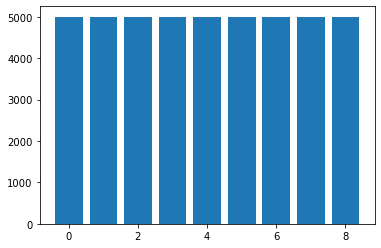

Wall time: 6.46 s


In [53]:
%%time
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

n_class_sample=5000

strategy = {0:n_class_sample, 1:n_class_sample, 2:n_class_sample, 3:n_class_sample, 4:n_class_sample, 5:n_class_sample,
            6:n_class_sample, 7:n_class_sample, 8:n_class_sample}
           
oversample = SMOTE(sampling_strategy=strategy,k_neighbors=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [55]:
print(X_train.shape)
print(X_valid.shape)

(45000, 189)
(1992, 189)


#### Run PCA

In [56]:
High_var_cols

# Adding catg with numeric features
features = N_features+High_var_cols
features = pd.unique(features).tolist()

In [57]:
#Updating train and test data accordingly 
X_train_f = X_train[features].copy()
X_valid_f = X_valid[features].copy()
test_f = test[features].copy()

In [58]:
X_train_f.shape

(45000, 68)

##### H2O Model on SMOTE data

In [61]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\Users\dubrangala\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DUBRAN~1\AppData\Local\Temp\tmp7o1z094_
  JVM stdout: C:\Users\DUBRAN~1\AppData\Local\Temp\tmp7o1z094_\h2o_dubrangala_started_from_python.out
  JVM stderr: C:\Users\DUBRAN~1\AppData\Local\Temp\tmp7o1z094_\h2o_dubrangala_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Kolkata
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.4
H2O_cluster_version_age:    1 month and 3 days
H2O_cluster_name:           H2O_from_python_dubrangala_1k97fa
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.052 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.5 final
--------------------------  ---------------------------------------------------------

In [ ]:
X_train_f['target'] = y_train
X_valid_f['target'] = y_valid

X_train_h20 = h2o.H2OFrame(X_train_f)
X_valid_h20 = h2o.H2OFrame(X_valid_f)

# Identify predictors and response
x = list(features)
y = "target"

X_train_h20[y] = X_train_h20[y].asfactor()
X_valid_h20[y] = X_valid_h20[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_smte = H2OAutoML(max_models=15, seed=123, stopping_metric = 'misclassification')
aml_smte.train(x=x, y=y, training_frame=X_train_h20, validation_frame=X_valid_h20)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
08:20:20.759: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
08:20:20.776: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████

In [65]:
preds = aml_smte.leader.predict(X_valid_h20)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [68]:
pred_h20_valid = h2o.as_list(preds['predict']).predict.values

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(y_valid,pred_h20_valid)
print('Confusion matrix : \n',matrix)

report = classification_report(y_valid,pred_h20_valid)

Confusion matrix : 
 [[ 14  32  13   5   0   0   0   1   0]
 [  7 161  40 119   0   6   1  11   0]
 [ 11  91  53  22   0   1   0   4   0]
 [  0  70  10 255   0  48   5 128   0]
 [  0   0   0   0   1   4   4   1   0]
 [  0   2   0  37   1 107  26 110   0]
 [  0   0   0   3   3  56  37  36   0]
 [  0  19   3 141   0  83  22 173   0]
 [  6   2   5   1   0   0   0   0   1]]


In [74]:
print('Confusion matrix : \n',report)


Confusion matrix : 
               precision    recall  f1-score   support

           0       0.37      0.22      0.27        65
           1       0.43      0.47      0.45       345
           2       0.43      0.29      0.35       182
           3       0.44      0.49      0.46       516
           4       0.20      0.10      0.13        10
           5       0.35      0.38      0.36       283
           6       0.39      0.27      0.32       135
           7       0.37      0.39      0.38       441
           8       1.00      0.07      0.12        15

    accuracy                           0.40      1992
   macro avg       0.44      0.30      0.32      1992
weighted avg       0.41      0.40      0.40      1992



In [77]:
p2_prediction_wt = pd.read_csv('phase2_prediction_lgb_wt.csv') 
p2_prediction_wt.head()

patient_id  class_pred_h2o_p2                         h2o_class_p1  \
0  PID0x4175                  0  Leber's hereditary optic neuropathy   
1  PID0x21f5                  7               Mitochondrial myopathy   
2  PID0x49b8                  5                            Tay-Sachs   
3  PID0x2d97                  3                       Leigh syndrome   
4  PID0x58da                  2                             Diabetes   

   class_pred_lgb_p2            lgb_class_p2  
0                  1         Cystic fibrosis  
1                  5               Tay-Sachs  
2                  7  Mitochondrial myopathy  
3                  3          Leigh syndrome  
4                  1         Cystic fibrosis

In [83]:
X_score1 = h2o.H2OFrame(test_f)
preds_h20 = aml_smte.leader.predict(X_score1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [84]:
p2_prediction_wt['class_pred_h2o_p2_smote'] = h2o.as_list(preds_h20['predict']).predict.values
p2_prediction_wt['h2o_class_p2_smote'] = p2_prediction_wt['class_pred_h2o_p2_smote'].apply(lambda x:class_decoding[x])
Counter(p2_prediction_wt.h2o_class_p2_smote)

Counter({'Cystic fibrosis': 2837,
         'Mitochondrial myopathy': 1377,
         'Leigh syndrome': 2886,
         "Leber's hereditary optic neuropathy": 348,
         'Diabetes': 1383,
         'Hemochromatosis': 107,
         'Tay-Sachs': 467,
         "Alzheimer's": 57,
         'Cancer': 3})

In [85]:
p2_prediction_wt.to_csv("phase2_prediction_h20_smote.csv", index=False)

#### LGBM SMOTE:

In [86]:
df_train = X_train_f.copy()
X_score = test_f.copy()

In [91]:
from  lightgbm import LGBMClassifier
from datetime import datetime
space = {  'num_leaves': hp.quniform('num_leaves', 20, 800, 10),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 0.95, 0.015),
            'learning_rate':hp.quniform('learning_rate', 0.015, 0.22, 0.005),
            'min_child_samples': hp.quniform('min_child_samples', 2, 100,2),
            'lambda_l1': hp.lognormal('lambda_l1', 1e-8, 3.0),
            'lambda_l2':  hp.lognormal('lambda_l2', 1e-8, 3.0),
            'bagging_freq': hp.quniform('bagging_freq', 2, 50,1),
            'subsample': hp.quniform('subsample', 0.1, 0.95, 0.015),
            'device': 'cpu',
            'first_metric_only':False,
            'n_jobs':-1,
            'eval_names': 'hackathon',
            'tree_learner': 'serial',
            'random_state': randSeed} 

# predict the majority class
def majorityPredictor(arr):    
    lst = arr.tolist()
    occ_= max(lst,key=lst.count)
    return occ_

def getPredictors_multi(selected_classfier,params,df_train,X_score,n_splits,seed_): 
    track_accuracy=[]
    y_score_tot = []   
    y_score_prob_tot = []
    folds=StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=seed_)
    for train_index, test_index in folds.split(df_train,df_train['target']):
        split_trn, split_val = df_train.iloc[train_index], df_train.iloc[test_index]
        y_train = split_trn['target']
        X_train = split_trn.drop(['target'],axis=1)
        y_valid = split_val['target']
        X_valid = split_val.drop(['target'],axis=1)
        accuracy_1,y_pred_score, y_pred_score_prob = myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score)
        track_accuracy.append(accuracy_1)
        y_score_tot.append(y_pred_score)
        y_score_prob_tot.append(y_pred_score_prob)
        
    mean_accuracy_=  np.mean(track_accuracy)
    print("Mean Accuracy: "+str(mean_accuracy_))
    
    final=pd.DataFrame(y_score_tot).T
    final_s = y_score_prob_tot
   
    return final,mean_accuracy_, final_s

param_score=[]
## Creating a loss function for Hyper parameter tuning and saving  hyper parameter values and the corresponding accuracy
##  for the defined parameters
def score_multi(params):
    print(params)
    y_pred_score_multi,multi_acc_, final_s = getPredictors_multi(selected_classfier,params,
                                                                                 df_train,X_score,n_splits=5,
                                                                                 seed_=randSeed)
    
    pd.DataFrame([selected_classfier,params,multi_acc_,
                  datetime.now().strftime('%Y_%m_%d_%H_%M_%S')]).T.to_csv('hyper_multi.csv',mode='a', header=False)

    return -multi_acc_
	
	
def myClassfier_multi(selected_classfier,params,X_train, y_train,X_valid,y_valid,X_score): 
      
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    X_score = X_score.to_numpy()
    if(selected_classfier =='lightgbm'):
          
        clf = LGBMClassifier(objective              = 'multiclass',
                            #categorical_feature      = cat_cols,
                            #n_estimators             = int(params[ 'n_estimators']),
                            num_leaves               = int(params[ 'num_leaves']),
                            #max_bin = 64,
                            colsample_bytree         = params[ 'colsample_bytree'],
                            learning_rate            = params[ 'learning_rate'],
                            #early_stopping_round    =int( params[ 'early_stopping_round']),
                            #max_depth                = 30,
                            min_child_samples        = int(params[ 'min_child_samples']) ,
                            #lambda_l1                = params['lambda_l1'],
                            #lambda_l2                = params['lambda_l2'],
                            subsample                = params['subsample'],
                            bagging_freq             = int(params['bagging_freq']),
                            verbosity                = -1,
                            device                   = params[ 'device'],
                            first_metric_only        = params[ 'first_metric_only'],
                            #eval_metric              = params[ 'eval_metric'],
                            #metric                   = params[ 'metric'],
                            n_jobs                   = int(params[ 'n_jobs']),
                            #eval_names               = params[ 'eval_names'],
                            random_state             = int(params[ 'random_state']),
                            tree_learner            = params[ 'tree_learner'],
                            #class_weight = sample_weights
                            ) 
        
        clf.fit(X_train,y_train,verbose=0, feature_name='auto', categorical_feature = 'auto') 
    
    y_pred= clf.predict(X_valid)
    y_score_pred = clf.predict(X_score)
    y_score_pred_prob = clf.predict_proba(X_score)
    accuracy_1=accuracy_score(y_valid,y_pred)
    del clf
    gc.collect()
            
    return accuracy_1,y_score_pred, y_score_pred_prob
	
	


In [92]:
## Code for hyper paramter tuning  using Light GBM as the classifier and 1000 evaluations
selected_classfier='lightgbm'
      
# Use the fmin function from Hyperopt to find the best hyperparameters
best_lightgbm = fmin(score_multi, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=250,rstate= np.random.RandomState(randSeed))

{'bagging_freq': 15.0, 'colsample_bytree': 0.765, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.2785178546988023, 'lambda_l2': 24.28210493447922, 'learning_rate': 0.17500000000000002, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.825, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will b

bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                               
Mean Accuracy: 0.5915777777777778                                                                                      
{'bagging_freq': 17.0, 'colsample_bytree': 0.255, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.484935638644304, 'lambda_l2': 0.20758511163197, 'learning_rate': 0.17500000000000002, 'min_child_samples': 12.0, 'n_jobs': -1, 'num_leaves': 540.0, 'random_state': 17, 'subsample': 0.87, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=17, subsample_freq=0 will be i

bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
Mean Accuracy: 0.6662666666666667                                                                                      
{'bagging_freq': 23.0, 'colsample_bytree': 0.21, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 142.2037375347965, 'lambda_l2': 43.015645618287195, 'learning_rate': 0.18, 'min_child_samples': 16.0, 'n_jobs': -1, 'num_leaves': 110.0, 'random_state': 17, 'subsample': 0.21, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=23, subsample_freq=0 will be ignored. Curren

bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=31, subsample_freq=0 will be ignored. Current value: bagging_freq=31                               
Mean Accuracy: 0.6306222222222223                                                                                      
{'bagging_freq': 21.0, 'colsample_bytree': 0.63, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.014497072794450847, 'lambda_l2': 0.6004778465514929, 'learning_rate': 0.195, 'min_child_samples': 26.0, 'n_jobs': -1, 'num_leaves': 340.0, 'rand

bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
Mean Accuracy: 0.7298                                                                                                  
{'bagging_freq': 13.0, 'colsample_bytree

bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                    

{'bagging_freq': 18.0, 'colsample_bytree': 0.885, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.35432136514064577, 'lambda_l2': 3833.7752831013413, 'learning_rate': 0.11, 'min_child_samples': 10.0, 'n_jobs': -1, 'num_leaves': 600.0, 'random_state': 17, 'subsample': 0.69, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=18, subsample_freq=0 will be ignored. Cur

bagging_freq is set=23, subsample_freq=0 will be ignored. Current value: bagging_freq=23                               
Mean Accuracy: 0.17724444444444445                                                                                     
{'bagging_freq': 16.0, 'colsample_bytree': 0.6599999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.7776844796577952, 'lambda_l2': 6.942791592492063, 'learning_rate': 0.045, 'min_child_samples': 68.0, 'n_jobs': -1, 'num_leaves': 650.0, 'random_state': 17, 'subsample': 0.255, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be

bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5                                 
Mean Accuracy: 0.7429111111111111                                                                                      
{'bagging_freq': 10.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.2675225731553376, 'lambda_l2': 0.004941655138920878, 'learning_rate': 0.015, 'min_child_samples': 96.0, 'n_jobs': -1, 'num_leaves': 310.0, 'random_state': 17, 'subsample': 0.615, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=10, subsample_freq=0 will be ignored. C

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35                               
Mean Accuracy: 0.6899111111111111                                                                                      
{'bagging_freq': 18.0, 'colsample_bytree': 0.495, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.2957369545479366, 'lambda_l2': 0.08327396659710576, 'learning_rate': 0.06, 'min_child_samples': 66.0, 'n_jobs': -1, 'num_leaves': 540.0, 'random_state': 17, 'subsample': 0.885, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                        

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
Mean Accuracy: 0.7280888888888889                                                                                      
{'bagging_freq': 21.0, 'colsample_bytree': 0.63, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.3131397201496739, 'lambd

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38                               
Mean Accuracy: 0.4392666666666667       

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                    

{'bagging_freq': 12.0, 'colsample_bytree': 0.945, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.6722414230620604, 'lambda_l2': 0.21555556034765044, 'learning_rate': 0.14, 'min_child_samples': 50.0, 'n_jobs': -1, 'num_leaves': 590.0, 'random_state': 17, 'subsample': 0.735, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=12, subsample_freq=0 will be ignored. Cu

bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
Mean Accuracy: 0.7511555555555556                                                                                      
{'bagging_freq': 9.0, 'colsample_bytree': 0.6599999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.561042490784406, 'lambda_l2': 0.08574385594474897, 'learning_rate': 0.21, 'min_child_samples': 60.0, 'n_jobs': -1, 'num_leaves': 430.0, 'random_state': 17, 'subsample': 0.945, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be i

bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                               
Mean Accuracy: 0.5572444444444444                                                                                      
{'bagging_freq': 2.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.8794364315132526, 'lambda_l2': 0.07182335557422749, 'learning_rate': 0.17500000000000002, 'min_child_samples': 66.0, 'n_jobs': -1, 'num_leaves': 350.0, 'random_state': 17, 'subsample': 0.855, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=2, subsample_freq=0 will be

bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
Mean Accuracy: 0.6157999999999999                                                                                      
{'bagging_freq': 5.0, 'colsample_bytree': 0.6749999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.8501639920988998, 'lambda_l2': 0.03706954367705663, 'learning_rate': 0.21, 'min_child_samples': 54.0, 'n_jobs': -1, 'num_leaves': 5

bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
Mean Accuracy: 0.6261111111111111                                                                                      
{'bagging_freq': 42.0, 'colsample_bytree

bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=24, subsample_freq=0

{'bagging_freq': 4.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.861827542454429, 'lambda_l2': 0.133108957925603, 'learning_rate': 0.215, 'min_child_samples': 38.0, 'n_jobs': -1, 'num_leaves': 260.0, 'random_state': 17, 'subsample': 0.87, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current 

bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13                               
Mean Accuracy: 0.7314888888888889                                                                                      
{'bagging_freq': 27.0, 'colsample_bytree': 0.51, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.027285989375585684, 'lambda_l2': 0.0634337041051749, 'learning_rate': 0.18, 'min_child_samples': 30.0, 'n_jobs': -1, 'num_leaves': 320.0, 'random_state': 17, 'subsample': 0.885, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=27, subsample_freq=0 will be ignored. Current value: bagging_freq=27                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=27, subsample_freq=0 will be ignored. Cu

bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
Mean Accuracy: 0.13362222222222223                                                                                     
{'bagging_freq': 20.0, 'colsample_bytree': 0.8999999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 4.174628118068359, 'lambda_l2': 0.13083841584341413, 'learning_rate': 0.14, 'min_child_samples': 70.0, 'n_jobs': -1, 'num_leaves': 590.0, 'random_state': 17, 'subsample': 0.585, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=20, subsample_freq=0 will be

bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
Mean Accuracy: 0.7394000000000001                                                                                      
{'bagging_freq': 3.0, 'colsample_bytree': 0.24, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.5720655291282298, 'lambda_l2': 9.210404208492262, 'learning_rate': 0.19, 'min_child_samples': 12.0, 'n_jobs': -1, 'num_leaves': 380.0, 'random_st

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
Mean Accuracy: 0.7220444444444445                                                                                      
{'bagging_freq': 10.0, 'colsample_bytree': 0.9299999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.9659704198

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                                 
Mean Accuracy: 0.7330666666666665       

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                    

{'bagging_freq': 4.0, 'colsample_bytree': 0.105, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.8571833212399284, 'lambda_l2': 0.04073424019967904, 'learning_rate': 0.02, 'min_child_samples': 70.0, 'n_jobs': -1, 'num_leaves': 390.0, 'random_state': 17, 'subsample': 0.705, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Curr

bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                               
Mean Accuracy: 0.7213111111111111                                                                                      
{'bagging_freq': 3.0, 'colsample_bytree': 0.84, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.05363732693669955, 'lambda_l2': 0.0342415859777083, 'learning_rate': 0.22, 'min_child_samples': 30.0, 'n_jobs': -1, 'num_leaves': 330.0, 'random_state': 17, 'subsample': 0.735, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=3, subsample_freq=0 will be ignored. Curre

bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30                               
Mean Accuracy: 0.5945333333333334                                                                                      
{'bagging_freq': 10.0, 'colsample_bytree': 0.44999999999999996, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.9469372579427566, 'lambda_l2': 0.01853076145416135, 'learning_rate': 0.085, 'min_child_samples': 90.0, 'n_jobs': -1, 'num_leaves': 690.0, 'random_state': 17, 'subsample': 0.48, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=10, subsample_freq=0 will 

bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                               
Mean Accuracy: 0.7538222222222222                                                                                      
{'bagging_freq': 14.0, 'colsample_bytree': 0.8099999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.6610558180183705, 'lambda_l2': 0.7117757717590603, 'learning_rate': 0.185, 'min_child_samples': 36.0, 'n_jobs': -1, 'num_leaves': 

bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20                               
Mean Accuracy: 0.3970666666666667                                                                                      
{'bagging_freq': 16.0, 'colsample_bytree

bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 

{'bagging_freq': 4.0, 'colsample_bytree': 0.735, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.0494640624463774, 'lambda_l2': 0.8768141922320709, 'learning_rate': 0.155, 'min_child_samples': 20.0, 'n_jobs': -1, 'num_leaves': 480.0, 'random_state': 17, 'subsample': 0.7949999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be 

bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
Mean Accuracy: 0.6148666666666667                                                                                      
{'bagging_freq': 14.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 4.140653973840014, 'lambda_l2': 0.87973885491336, 'learning_rate': 0.13, 'min_child_samples': 26.0, 'n_jobs': -1, 'num_leaves': 450.0, 'random_state': 17, 'subsample': 0.765, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=14, subsample_freq=0 will be ignored. Current

bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22                               
Mean Accuracy: 0.1410888888888889                                                                                      
{'bagging_freq': 3.0, 'colsample_bytree': 0.72, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.122881878075461, 'lambda_l2': 0.38642789294993074, 'learning_rate': 0.18, 'min_child_samples': 28.0, 'n_jobs': -1, 'num_leaves': 620.0, 'random_state': 17, 'subsample': 0.78, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=3, subsample_freq=0 will be ignored. Current

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=45, subsample_freq=0 will be ignored. Current value: bagging_freq=45                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=45, subsample_freq=0 will be ignored. Current value: bagging_freq=45                               
Mean Accuracy: 0.14377777777777775                                                                                     
{'bagging_freq': 20.0, 'colsample_bytree': 0.57, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 3.179396161101545, 'lambda_l2': 0.9789650730820283, 'learning_rate': 0.135, 'min_child_samples': 20.0, 'n_jobs': -1, 'num_leaves': 540.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                             

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6                                 
Mean Accuracy: 0.7461111111111112                                                                                      
{'bagging_freq': 13.0, 'colsample_bytree': 0.87, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.6086561040890492, 'lambd

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7                                 
Mean Accuracy: 0.7409555555555556       

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16                               
[LightGBM] [Warning]                    

{'bagging_freq': 36.0, 'colsample_bytree': 0.495, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.7049519829921125, 'lambda_l2': 2.2213118779399066, 'learning_rate': 0.185, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 730.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=36, subsample_freq=0 will be ignored. Current value: bagging_freq=36                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=36, subsample_freq=0 will b

bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3                                 
Mean Accuracy: 0.6976666666666665                                                                                      
{'bagging_freq': 8.0, 'colsample_bytree': 0.705, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.1118773031434883, 'lambda_l2': 3.217287746133629, 'learning_rate': 0.095, 'min_child_samples': 40.0, 'n_jobs': -1, 'num_leaves': 390.0, 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be i

bagging_freq is set=32, subsample_freq=0 will be ignored. Current value: bagging_freq=32                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=32, subsample_freq=0 will be ignored. Current value: bagging_freq=32                               
Mean Accuracy: 0.14993333333333334                                                                                     
{'bagging_freq': 4.0, 'colsample_bytree': 0.9299999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.9889761072309277, 'lambda_l2': 17.25513013573548, 'learning_rate': 0.19, 'min_child_samples': 74.0, 'n_jobs': -1, 'num_leaves': 430.0, 'random_state': 17, 'subsample': 0.765, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=4, subsample_freq=0 will be ig

bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=25, subsample_freq=0 will be ignored. Current value: bagging_freq=25                               
Mean Accuracy: 0.5895111111111111                                                                                      
{'bagging_freq': 5.0, 'colsample_bytree': 0.8999999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 0.000546657737056398, 'lambda_l2': 11.580127027363675, 'learning_rate': 0.145, 'min_child_samples': 52.0, 'n_jobs': -1, 'num_leaves':

bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8                                 
Mean Accuracy: 0.7387333333333334                                                                                      
{'bagging_freq': 27.0, 'colsample_bytree

bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=15, subsample_freq=0

{'bagging_freq': 11.0, 'colsample_bytree': 0.705, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.5514251799571108, 'lambda_l2': 0.17214833725191248, 'learning_rate': 0.17, 'min_child_samples': 44.0, 'n_jobs': -1, 'num_leaves': 700.0, 'random_state': 17, 'subsample': 0.9149999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will b

bagging_freq is set=17, subsample_freq=0 will be ignored. Current value: bagging_freq=17                               
Mean Accuracy: 0.6335333333333334                                                                                      
{'bagging_freq': 21.0, 'colsample_bytree': 0.69, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 1.4561531815943132, 'lambda_l2': 1.0351947118615359, 'learning_rate': 0.2, 'min_child_samples': 36.0, 'n_jobs': -1, 'num_leaves': 340.0, 'random_state': 17, 'subsample': 0.84, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Current value: bagging_freq=21                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=21, subsample_freq=0 will be ignored. Curren

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=48, subsample_freq=0 will be ignored. Current value: bagging_freq=48                               
Mean Accuracy: 0.15135555555555555                                                                                     
{'bagging_freq': 14.0, 'colsample_bytree': 0.645, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 31.77111077817976, 'lambda_l2': 1.1900441292267183, 'learning_rate': 0.105, 'min_child_samples': 56.0, 'n_jobs': -1, 'num_leaves': 450.0, 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14                               
[LightGBM] [Warning]                            

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11                               
Mean Accuracy: 0.38108888888888887                                                                                     
{'bagging_freq': 26.0, 'colsample_bytree': 0.615, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 10.699850934943662, 'lambda_l2': 0.21801675608958448, 'learning_rate': 0.145, 'min_child_samples': 32.0, 'n_jobs': -1, 'num_leaves': 540.0, 'random_state': 17, 'subsample': 0.855, 'tree_learner': 'serial'}
[LightGBM] [Warning]                                       

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34                               
Mean Accuracy: 0.7368444444444445                                                                                      
{'bagging_freq': 38.0, 'colsample_bytree': 0.9149999999999999, 'device': 'cpu', 'eval_names': 'hackathon', 'first_metric_only': False, 'lambda_l1': 2.0878357755

[LightGBM] [Warning]                                                                                                   
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                 
[LightGBM] [Warning]                                                                                                   
bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2                                 
Mean Accuracy: 0.7492000000000001       

In [93]:
best_lightgbm

{'bagging_freq': 14.0,
 'colsample_bytree': 0.825,
 'lambda_l1': 1.3677512328921755,
 'lambda_l2': 0.3718368026387762,
 'learning_rate': 0.2,
 'min_child_samples': 36.0,
 'num_leaves': 550.0,
 'subsample': 0.9299999999999999}

In [94]:
lgbm_params={'bagging_freq': 14.0, 'colsample_bytree': 0.825, 'device': 'cpu', 'eval_names': 'tanzu',
             'first_metric_only': False, 'lambda_l1':  1.3677512328921755, 'lambda_l2': 0.3718368026387762, 
             'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 36.0, 'n_jobs': -1, 'num_leaves': 550.0,
             'objective': 'multiclass', 'random_state': 17, 'subsample': 0.9299999999999999, 'tree_learner': 'serial'}
selected_classfier='lightgbm'
lgb_p2_smote, mean_accuracy_, prob_mg1= getPredictors_multi(selected_classfier,lgbm_params,df_train,X_score,
                                                        n_splits=5,seed_=randSeed)



[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
Mean Accuracy: 0.7538222222222222


In [101]:
y_score_multi_p2_smote = lgb_p2_smote.astype(int).apply(majorityPredictor,axis=1) 
y_score_multi_p2_smote.value_counts()

3    2943
1    2735
7    1434
2    1253
0     464
5     461
6     102
8      73
dtype: int64

In [102]:
p2_prediction_wt['class_pred_lgb_p2_smote'] = y_score_multi_p2_smote
p2_prediction_wt['lgb_class_p2_smote'] = p2_prediction_wt['class_pred_lgb_p2_smote'].apply(lambda x:class_decoding[x])
Counter(p2_prediction_wt.lgb_class_p2_smote)

Counter({'Cystic fibrosis': 2735,
         'Leigh syndrome': 2943,
         'Mitochondrial myopathy': 1434,
         'Diabetes': 1253,
         "Leber's hereditary optic neuropathy": 464,
         'Tay-Sachs': 461,
         "Alzheimer's": 73,
         'Hemochromatosis': 102})

In [103]:
p2_prediction_wt.to_csv("phase2_prediction_lgb_smote.csv", index=False)

In [104]:
my_fold1 = pd.DataFrame()
for j in range(len(prob_mg1)):
    col = ['col'+str(i)+str(j) for i in range(9)]
    c = pd.DataFrame(prob_mg1[j], columns=col)
    my_fold1 = pd.concat([my_fold1, c], axis=1)
lgb_prob_scoreq = my_fold1.copy()
my_fold1.head(2)

col00     col10     col20     col30     col40     col50     col60  \
0  0.066453  0.864482  0.063730  0.004165  0.000001  0.000004  0.000009   
1  0.000033  0.000142  0.000047  0.577429  0.000004  0.266976  0.076978   

      col70     col80     col01     col11     col21     col31         col41  \
0  0.000237  0.000919  0.003048  0.967364  0.029053  0.000405  2.513981e-07   
1  0.078390  0.000002  0.000024  0.000116  0.000004  0.000255  7.490856e-07   

      col51         col61     col71         col81     col02     col12  \
0  0.000007  8.525825e-07  0.000037  8.563503e-05  0.164041  0.811613   
1  0.246644  1.595447e-02  0.737002  3.312370e-07  0.000079  0.002368   

      col22     col32     col42     col52     col62    col72     col82  \
0  0.023082  0.000906  0.000001  0.000036  0.000006  0.00005  0.000266   
1  0.000073  0.324303  0.000008  0.032714  0.128374  0.51208  0.000002   

      col03     col13     col23     col33         col43     col53     col63  \
0  0.232003  0.739432  0.027085  0.000999  5.941719e-07  0.000002  0.000003   
1  0.000173  0.001562  0.000145  0.421953  1.299245e-05  0.140165  0.024696   

      col73     col83     col04     col14     col24     col34         col44  \
0  0.000133  0.000342  0.004763  0.989296  0.005809  0.000064  1.508866e-07   
1  0.411287  0.000006  0.000054  0.001252  0.000011  0.203169  4.688243e-06   

          col54         col64     col74     col84  
0  7.325590e-07  8.237081e-07  0.000036  0.000031  
1  4.164925e-01  1.341656e-02  0.365599  0.000002

In [106]:
lgb_prob_scoreq['lgb_s_p0'] = my_fold1[['col00','col01','col02','col03','col04']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p1'] = my_fold1[['col10','col11','col12','col13','col14']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p2'] = my_fold1[['col20','col21','col22','col23','col24']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p3'] = my_fold1[['col30','col31','col32','col33','col34']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p4'] = my_fold1[['col40','col41','col42','col43','col44']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p5'] = my_fold1[['col50','col51','col52','col53','col54']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p6'] = my_fold1[['col60','col61','col62','col63','col64']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p7'] = my_fold1[['col70','col71','col72','col73','col74']].mean(axis=1)
lgb_prob_scoreq['lgb_s_p8'] = my_fold1[['col80','col81','col82','col83','col84']].mean(axis=1)
lgb_prob_scoreq.head(2)

col00     col10     col20     col30     col40     col50     col60  \
0  0.066453  0.864482  0.063730  0.004165  0.000001  0.000004  0.000009   
1  0.000033  0.000142  0.000047  0.577429  0.000004  0.266976  0.076978   

      col70     col80     col01     col11     col21     col31         col41  \
0  0.000237  0.000919  0.003048  0.967364  0.029053  0.000405  2.513981e-07   
1  0.078390  0.000002  0.000024  0.000116  0.000004  0.000255  7.490856e-07   

      col51         col61     col71         col81     col02     col12  \
0  0.000007  8.525825e-07  0.000037  8.563503e-05  0.164041  0.811613   
1  0.246644  1.595447e-02  0.737002  3.312370e-07  0.000079  0.002368   

      col22     col32     col42     col52     col62    col72     col82  \
0  0.023082  0.000906  0.000001  0.000036  0.000006  0.00005  0.000266   
1  0.000073  0.324303  0.000008  0.032714  0.128374  0.51208  0.000002   

      col03     col13     col23     col33         col43     col53     col63  \
0  0.232003  0.739432  0.027085  0.000999  5.941719e-07  0.000002  0.000003   
1  0.000173  0.001562  0.000145  0.421953  1.299245e-05  0.140165  0.024696   

      col73     col83     col04     col14     col24     col34         col44  \
0  0.000133  0.000342  0.004763  0.989296  0.005809  0.000064  1.508866e-07   
1  0.411287  0.000006  0.000054  0.001252  0.000011  0.203169  4.688243e-06   

          col54         col64     col74     col84    lgb_p0    lgb_p1  \
0  7.325590e-07  8.237081e-07  0.000036  0.000031  0.094062  0.874437   
1  4.164925e-01  1.341656e-02  0.365599  0.000002  0.000072  0.001088   

     lgb_p2    lgb_p3        lgb_p4    lgb_p5    lgb_p6    lgb_p7    lgb_p8  \
0  0.029752  0.001308  6.353818e-07  0.000010  0.000004  0.000098  0.000329   
1  0.000056  0.305422  5.990376e-06  0.220598  0.051884  0.420871  0.000002   

   lgb_s_p0  lgb_s_p1  lgb_s_p2  lgb_s_p3      lgb_s_p4  lgb_s_p5  lgb_s_p6  \
0  0.094062  0.874437  0.029752  0.001308  6.353818e-07  0.000010  0.000004   
1  0.000072  0.001088  0.000056  0.305422  5.990376e-06  0.220598  0.051884   

   lgb_s_p7  lgb_s_p8  
0  0.000098  0.000329  
1  0.420871  0.000002

In [109]:
p2_score_prob_wt = pd.concat([p2_score_prob_wt, lgb_prob_scoreq[['lgb_s_p0','lgb_s_p1','lgb_s_p2','lgb_s_p3','lgb_s_p4','lgb_s_p5','lgb_s_p6','lgb_s_p7','lgb_s_p8']]], axis=1)
p2_score_prob_wt.head(2)



preidct_h20  h2o_wt_p0  h2o_wt_p1  h2o_wt_p2  h2o_wt_p3  h2o_wt_p4  \
0            0   0.664632   0.091037   0.185489   0.013883   0.000497   
1            7   0.030829   0.029778   0.010766   0.102577   0.002935   

   h2o_wt_p5  h2o_wt_p6  h2o_wt_p7  h2o_wt_p8    lgb_p0    lgb_p1    lgb_p2  \
0   0.005913   0.004186   0.007802   0.026560  0.287493  0.443773  0.257603   
1   0.282736   0.226261   0.312960   0.001158  0.000165  0.006797  0.000924   

     lgb_p3    lgb_p4    lgb_p5    lgb_p6    lgb_p7    lgb_p8  lgb_s_p0  \
0  0.005609  0.000032  0.001196  0.000539  0.001344  0.002412  0.094062   
1  0.060775  0.000017  0.432482  0.159959  0.338864  0.000016  0.000072   

   lgb_s_p1  lgb_s_p2  lgb_s_p3      lgb_s_p4  lgb_s_p5  lgb_s_p6  lgb_s_p7  \
0  0.874437  0.029752  0.001308  6.353818e-07  0.000010  0.000004  0.000098   
1  0.001088  0.000056  0.305422  5.990376e-06  0.220598  0.051884  0.420871   

   lgb_s_p8  
0  0.000329  
1  0.000002

##### Final Model Ensemble - Voting classifier

In [127]:
import os

# Getting the current work directory (cwd)
thisdir = os.getcwd()

# r=root, d=directories, f = files
j = 0
mydata = pd.DataFrame()
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.startswith("mysubmission"):
            print(os.path.join(r, file))
            temp = pd.read_csv(os.path.join(r, file))
            ccc = list(temp.columns) ## colnames
            temp.columns = [i+str(j) for i in ccc] ## rename colnames
            mydata = pd.concat([mydata, temp], axis=1)
            j=j+1
            
            
            

C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission1.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission2.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission3.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission4_em.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission5_lgb.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission6_rf.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission7-1_lgb_subclass.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission7-2_h20_both.csv
C:\Users\dubrangala\OneDrive - VMware, Inc\Case Studies\hackerarth_prediction\dataset\mysubmission7-2_h20_both_1.csv
C:\Users\dubran

In [128]:
mydata.head()

Patient Id0                             Genetic Disorder0  \
0   PID0x4175  Multifactorial genetic inheritance disorders   
1   PID0x21f5   Mitochondrial genetic inheritance disorders   
2   PID0x49b8              Single-gene inheritance diseases   
3   PID0x2d97   Mitochondrial genetic inheritance disorders   
4   PID0x58da              Single-gene inheritance diseases   

       Disorder Subclass0 Patient Id1  \
0                Diabetes   PID0x4175   
1  Mitochondrial myopathy   PID0x21f5   
2               Tay-Sachs   PID0x49b8   
3          Leigh syndrome   PID0x2d97   
4         Cystic fibrosis   PID0x58da   

                              Genetic Disorder1      Disorder Subclass1  \
0  Multifactorial genetic inheritance disorders                Diabetes   
1   Mitochondrial genetic inheritance disorders  Mitochondrial myopathy   
2   Mitochondrial genetic inheritance disorders  Mitochondrial myopathy   
3   Mitochondrial genetic inheritance disorders          Leigh syndrome   
4  Multifactorial genetic inheritance disorders                Diabetes   

  Patient Id2                             Genetic Disorder2  \
0   PID0x4175  Multifactorial genetic inheritance disorders   
1   PID0x21f5   Mitochondrial genetic inheritance disorders   
2   PID0x49b8   Mitochondrial genetic inheritance disorders   
3   PID0x2d97   Mitochondrial genetic inheritance disorders   
4   PID0x58da  Multifactorial genetic inheritance disorders   

       Disorder Subclass2 Patient Id3  \
0                Diabetes   PID0x4175   
1  Mitochondrial myopathy   PID0x21f5   
2  Mitochondrial myopathy   PID0x49b8   
3          Leigh syndrome   PID0x2d97   
4                Diabetes   PID0x58da   

                              Genetic Disorder3      Disorder Subclass3  \
0  Multifactorial genetic inheritance disorders                Diabetes   
1              Single-gene inheritance diseases  Mitochondrial myopathy   
2   Mitochondrial genetic inheritance disorders  Mitochondrial myopathy   
3   Mitochondrial genetic inheritance disorders          Leigh syndrome   
4  Multifactorial genetic inheritance disorders                Diabetes   

  Patient Id4                             Genetic Disorder4  \
0   PID0x4175  Multifactorial genetic inheritance disorders   
1   PID0x21f5              Single-gene inheritance diseases   
2   PID0x49b8   Mitochondrial genetic inheritance disorders   
3   PID0x2d97   Mitochondrial genetic inheritance disorders   
4   PID0x58da              Single-gene inheritance diseases   

       Disorder Subclass4 Patient Id5  \
0                Diabetes   PID0x4175   
1  Mitochondrial myopathy   PID0x21f5   
2  Mitochondrial myopathy   PID0x49b8   
3          Leigh syndrome   PID0x2d97   
4                Diabetes   PID0x58da   

                              Genetic Disorder5      Disorder Subclass5  \
0  Multifactorial genetic inheritance disorders                Diabetes   
1   Mitochondrial genetic inheritance disorders  Mitochondrial myopathy   
2   Mitochondrial genetic inheritance disorders  Mitochondrial myopathy   
3   Mitochondrial genetic inheritance disorders          Leigh syndrome   
4  Multifactorial genetic inheritance disorders                Diabetes   

  Patient Id6                             Genetic Disorder6  \
0   PID0x4175  Multifactorial genetic inheritance disorders   
1   PID0x21f5              Single-gene inheritance diseases   
2   PID0x49b8   Mitochondrial genetic inheritance disorders   
3   PID0x2d97   Mitochondrial genetic inheritance disorders   
4   PID0x58da              Single-gene inheritance diseases   

       Disorder Subclass6 Patient Id7  \
0                Diabetes   PID0x4175   
1  Mitochondrial myopathy   PID0x21f5   
2  Mitochondrial myopathy   PID0x49b8   
3          Leigh syndrome   PID0x2d97   
4                Diabetes   PID0x58da   

                              Genetic Disorder7 Disorder Subclass7  \
0  Multifactorial genetic inheritance disorders           Diabetes   
1    

In [133]:
id_col = mydata[[col for col in mydata.columns if 'Patient' in col]]
genetic_dis = mydata[[col for col in mydata.columns if 'Genetic' in col]]
dis_subclass = mydata[[col for col in mydata.columns if 'Disorder Subclass' in col]]

In [143]:
## genetic disorder class
dictv = ['Mitochondrial genetic inheritance disorders', 'Multifactorial genetic inheritance disorders', 'Single-gene inheritance diseases']
mc = [col for col in mydata.columns if 'Genetic' in col]
gd_p = pd.DataFrame()
gd_p['patient_id'] = mydata['Patient Id0'].values
i = 0
for j in mc:
    a = np.where(genetic_dis[j]=='Mitochondrial genetic inheritance disorders', 1, 0)
    b = np.where(genetic_dis[j]=='Multifactorial genetic inheritance disorders', 1, 0)
    c = np.where(genetic_dis[j]=='Single-gene inheritance diseases', 1, 0)
    gd_p['A'+str(i)] = a
    gd_p['B'+str(i)] = b
    gd_p['C'+str(i)] = c
    i = i+1

In [151]:
gd_p['Mitochondrial genetic inheritance disorders'] = gd_p[["A"+str(i) for i in range(23)]].sum(axis=1)
gd_p['Multifactorial genetic inheritance disorders'] = gd_p[["B"+str(i) for i in range(23)]].sum(axis=1)
gd_p['Single-gene inheritance diseases'] = gd_p[["C"+str(i) for i in range(23)]].sum(axis=1)
gd_p['gd_label'] = gd_p[dictv].idxmax(axis=1)
gd_p.gd_label.value_counts()

Mitochondrial genetic inheritance disorders     5016
Single-gene inheritance diseases                2665
Multifactorial genetic inheritance disorders    1784
Name: gd_label, dtype: int64

Mitochondrial genetic inheritance disorders  \
0                                               0   
1                                               5   
2                                              22   
3                                              23   
4                                               0   
...                                           ...   
9460                                           12   
9461                                           19   
9462                                           23   
9463                                            1   
9464                                            1   

      Multifactorial genetic inheritance disorders  \
0                                               23   
1                                                0   
2                                                0   
3                                                0   
4                                                9   
...                                            ...   
9460                                             3   
9461                                             2   
9462                                             0   
9463                                            22   
9464                                            21   

      Single-gene inheritance diseases  \
0                                    0   
1                                   18   
2                                    1   
3                                    0   
4                                   14   
...                                ...   
9460                                 8   
9461                                 2   
9462                                 0   
9463                                 0   
9464                                 1   

                                          gd_label patient_id  
0     Multifactorial genetic inheritance disorders  PID0x4175  
1                 Single-gene inheritance diseases  PID0x21f5  
2      Mitochondrial genetic inheritance disorders  PID0x49b8  
3      Mitochondrial genetic inheritance disorders  PID0x2d97  
4                 Single-gene inheritance diseases  PID0x58da  
...                                            ...        ...  
9460   Mitochondrial genetic inheritance disorders  PID0x81e1  
9461   Mitochondrial genetic inheritance disorders  PID0x3514  
9462   Mitochondrial genetic inheritance disorders  PID0x5408  
9463  Multifactorial genetic inheritance disorders  PID0x2017  
9464  Multifactorial genetic inheritance disorders  PID0x7f61  

[9465 rows x 5 columns]

In [164]:
gd_p[dictv+['gd_label','patient_id']].to_csv("genetic_disorder_predictions_vote.csv", index=False)

In [140]:
genetic_dis.to_csv("genetic_disorder_predictions.csv", index=False)

In [202]:
## Disorder Subclass disorder class
dictv = ["Tay-Sachs","Mitochondrial myopathy","Leigh syndrome","Leber's hereditary optic neuropathy","Hemochromatosis","Diabetes","Cystic fibrosis","Cancer","Alzheimer's"]
mc = [col for col in mydata.columns if 'Disorder Subclass' in col]
ds_p = pd.DataFrame()
ds_p['patient_id'] = mydata['Patient Id0'].values
k = 0
for j in mc:
    a = np.where(dis_subclass[j]=="Alzheimer's", 1, 0)
    b = np.where(dis_subclass[j]=="Cancer", 1, 0)
    c = np.where(dis_subclass[j]=="Cystic fibrosis", 1, 0)
    d = np.where(dis_subclass[j]=="Diabetes", 1, 0)
    e = np.where(dis_subclass[j]=="Hemochromatosis", 1, 0)
    f = np.where(dis_subclass[j]=="Leber's hereditary optic neuropathy", 1, 0)
    g = np.where(dis_subclass[j]=="Leigh syndrome", 1, 0)
    h = np.where(dis_subclass[j]=="Mitochondrial myopathy", 1, 0)
    i = np.where(dis_subclass[j]=="Tay-Sachs", 1, 0)
    ds_p['A'+str(k)] = a
    ds_p['B'+str(k)] = b
    ds_p['C'+str(k)] = c
    ds_p['D'+str(k)] = d
    ds_p['E'+str(k)] = e
    ds_p['F'+str(k)] = f
    ds_p['G'+str(k)] = g
    ds_p['H'+str(k)] = h
    ds_p['I'+str(k)] = i
    k = k+1

In [203]:
ds_p["Alzheimer's"] = ds_p[['A'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Cancer"] = ds_p[['B'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Cystic fibrosis"] = ds_p[['C'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Diabetes"] = ds_p[['D'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Hemochromatosis"] = ds_p[['E'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Leber's hereditary optic neuropathy"] = ds_p[['F'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Leigh syndrome"] = ds_p[['G'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Mitochondrial myopathy"] = ds_p[['H'+str(i) for i in range(22)]].sum(axis=1)
ds_p["Tay-Sachs"] = ds_p[['I'+str(i) for i in range(22)]].sum(axis=1)


In [205]:
ds_p['gd_label'] = ds_p[dictv].idxmax(axis=1)
ds_p.gd_label.value_counts()

Leigh syndrome                         3093
Cystic fibrosis                        2213
Mitochondrial myopathy                 1421
Diabetes                               1409
Tay-Sachs                               719
Leber's hereditary optic neuropathy     345
Alzheimer's                             132
Hemochromatosis                         130
Cancer                                    3
Name: gd_label, dtype: int64

In [206]:
ds_p[dictv+['gd_label','patient_id']].to_csv("genetic_disorder_subclass_predictions_vote.csv", index=False)